In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

# Import data

In [2]:
df = pd.read_csv('./../data-workfile/search-and-bookings.csv', index_col='Unnamed: 0')

In [3]:
df.head()

search_log_session_id                   uuid  session_id utm_source  \
0                   4034  1145549807.1726611234  1726611549         na   
1                   4037  2039466988.1726611511  1726611615   facebook   
2                   4069  1556994523.1726611965  1726612033     google   
3                   4034  1145549807.1726611234  1726611549         na   
4                   4102   901475575.1726612653  1726612722     google   

  utm_medium utm_campaign hotel_id  search_log_id         utc_datetime  \
0  (not set)           na  hotel_1         112645  2024-09-17 22:19:09   
1        cpc   other_camp  hotel_1         112648  2024-09-17 22:20:15   
2        cpc          NaN  hotel_1         112680  2024-09-17 22:27:13   
3  (not set)           na  hotel_1         112682  2024-09-17 22:28:30   
4        cpc          NaN  hotel_1         112714  2024-09-17 22:38:42   

  lang_code  ... ROOMHH_room_price_min ROOMHH_room_price_max pieces  \
0        hu  ...                   NaN                   NaN    NaN   
1        hu  ...                   NaN                   NaN    NaN   
2        de  ...                   NaN                   NaN    NaN   
3        hu  ...                   NaN                   NaN    NaN   
4        en  ...                684.25                771.19    NaN   

   sum_price  total_price_final_y  rooms_total_price  upsell_total_price  \
0        NaN                  NaN                NaN                 NaN   
1        NaN                  NaN                NaN                 NaN   
2        NaN                  NaN                NaN                 NaN   
3        NaN                  NaN                NaN                 NaN   
4        NaN                  NaN                NaN                 NaN   

   vouchers_total_price  loyalty_discount_total  redeemed_loyalty_points_total  
0                   NaN                     NaN                            NaN  
1                   NaN                     NaN                            NaN  
2                   NaN                     NaN                            NaN  
3                   NaN                     NaN                            NaN  
4                   NaN                     NaN                            NaN  

[5 rows x 52 columns]

In [4]:
df.columns

Index(['search_log_session_id', 'uuid', 'session_id', 'utm_source',
       'utm_medium', 'utm_campaign', 'hotel_id', 'search_log_id',
       'utc_datetime', 'lang_code', 'currency', 'arrival', 'departure', 'days',
       'nights', 'adults', 'children', 'conversion', 'search_log_room_id',
       'sel_num_of_rooms', 'picked_price_median', 'picked_room', '0_age',
       '1_age', '2_age', '3_age', '4_age', 'baby_bed', 'ROOMAA_room_price_min',
       'ROOMAA_room_price_max', 'ROOMBB_room_price_min',
       'ROOMBB_room_price_max', 'ROOMCC_room_price_min',
       'ROOMCC_room_price_max', 'ROOMDD_room_price_min',
       'ROOMDD_room_price_max', 'ROOMEE_room_price_min',
       'ROOMEE_room_price_max', 'ROOMFF_room_price_min',
       'ROOMFF_room_price_max', 'ROOMGG_room_price_min',
       'ROOMGG_room_price_max', 'ROOMHH_room_price_min',
       'ROOMHH_room_price_max', 'pieces', 'sum_price', 'total_price_final_y',
       'rooms_total_price', 'upsell_total_price', 'vouchers_total_price',
      

In [5]:
# rename a cloumn
df.rename(columns={'total_price_final_y':'total_price_final'}, inplace=True)

# Feature engineering

- Currency conversion
- variable type conversion
- Generate new variables

### Currency conversion

In [6]:
# currency conversion

# ccrape down the EUR exchange rate data from MNB's webpage

import requests
from bs4 import BeautifulSoup

# Define the URL
url = 'https://www.mnb.hu/arfolyam-tablazat?deviza=rbCurrencyActual&devizaSelected=EUR&datefrom=2024.09.17.&datetill=2024.10.18.&order=1'

# Fetch the page content
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

table = soup.find('table') 

# rows into a table
table_data = []
for row in table.find_all('tr'):
    cells = row.find_all(['td', 'th'])
    table_data.append([cell.get_text(strip=True) for cell in cells])

eur_price = pd.DataFrame(table_data[1:], columns=table_data[0])  # first row to header

eur_price = eur_price.drop(index=[0,1]).reset_index()

eur_price = eur_price.rename(columns={'':'date'})[['date','EUR']]

In [7]:
# dates to YYYY-MM-DD format

hungarian_to_english = {
    'január': 'January', 'február': 'February', 'március': 'March', 'április': 'April',
    'május': 'May', 'június': 'June', 'július': 'July', 'augusztus': 'August',
    'szeptember': 'September', 'október': 'October', 'november': 'November', 'december': 'December',
    'hétfő': 'Monday', 'kedd': 'Tuesday', 'szerda': 'Wednesday', 'csütörtök': 'Thursday',
    'péntek': 'Friday', 'szombat': 'Saturday', 'vasárnap': 'Sunday'
}

def convert_hungarian_date(date_str):
    for hun, eng in hungarian_to_english.items():
        date_str = date_str.replace(hun, eng)
    date_obj = datetime.strptime(date_str, '%Y. %B %d., %A')
    return date_obj.strftime('%Y-%m-%d')

# apply the function to the df column
eur_price['date'] = eur_price['date'].apply(convert_hungarian_date)
eur_price['date'] = pd.to_datetime(eur_price['date'])

In [8]:
# Convert date column to datetime and value column to numeric
eur_price.set_index('date', inplace=True)

# Create a complete date range from the first to the last date
date_range = pd.date_range(start=eur_price.index.min(), end=eur_price.index.max(), freq='D')

# Reindex the DataFrame to include all dates in the range
eur_price = eur_price.reindex(date_range)

# fill nans (weekends and holidays)
eur_price['EUR'] = eur_price['EUR'].fillna(method='ffill')

In [9]:
# define a conversion function
def conversion(x):
    rate = eur_price[eur_price.index == x]['EUR'].values
    if rate:
        return float(rate[0].replace(',', '.')) 
    else:
        return None

In [10]:
df['simple_date'] = pd.to_datetime(df['utc_datetime'], format='%Y-%m-%d %H:%M:%S').dt.strftime('%Y-%m-%d')

# Set the default conversion rate to 1
df['conversion_rate'] = 1

# Update 'conversion_rate' only where 'currency' is 'EUR'
df.loc[df['currency'] == 'EUR', 'conversion_rate'] = df.loc[df['currency'] == 'EUR', 'simple_date'].apply(conversion)

In [11]:
# mean room price for the entire duration
df['mean_room_price'] =  df['rooms_total_price']/df['sel_num_of_rooms']

In [12]:
# execute the conversions
df['total_price_final'] = df['conversion_rate']*df['total_price_final']
df['rooms_total_price'] = df['conversion_rate']*df['rooms_total_price']
df['upsell_total_price'] = df['conversion_rate']*df['upsell_total_price']
df['vouchers_total_price'] = df['conversion_rate']*df['vouchers_total_price']
df['loyalty_discount_total'] = df['conversion_rate']*df['loyalty_discount_total']
df['mean_room_price'] = df['conversion_rate']*df['mean_room_price']

### Feature engineering

In [13]:
# generate new variables for offered prices
df['offered_price_median'] = (df[['ROOMAA_room_price_min', 'ROOMAA_room_price_max','ROOMBB_room_price_min', 'ROOMBB_room_price_max','ROOMCC_room_price_min', 'ROOMCC_room_price_max','ROOMDD_room_price_min', 'ROOMDD_room_price_max','ROOMEE_room_price_min', 'ROOMEE_room_price_max',
       'ROOMFF_room_price_min', 'ROOMFF_room_price_max','ROOMGG_room_price_min', 'ROOMGG_room_price_max','ROOMHH_room_price_min', 'ROOMHH_room_price_max']].median(axis=1)/df['nights'])/df['sel_num_of_rooms']
df['offered_price_min'] = (df[['ROOMAA_room_price_min','ROOMBB_room_price_min','ROOMCC_room_price_min','ROOMDD_room_price_min','ROOMEE_room_price_min',
       'ROOMFF_room_price_min','ROOMGG_room_price_min','ROOMHH_room_price_min']].min(axis=1)/df['nights'])/df['sel_num_of_rooms']
df['offered_price_max'] = (df[['ROOMAA_room_price_max', 'ROOMBB_room_price_max', 'ROOMCC_room_price_max', 'ROOMDD_room_price_max', 'ROOMEE_room_price_max',
       'ROOMFF_room_price_max', 'ROOMGG_room_price_max', 'ROOMHH_room_price_max']].max(axis=1)/df['nights'])/df['sel_num_of_rooms']

df['offered_price_median'] = df['offered_price_median'] * df['conversion_rate']
df['offered_price_min'] = df['offered_price_min'] * df['conversion_rate']
df['offered_price_max'] = df['offered_price_max'] * df['conversion_rate']

# drop the unnecessary variables
df.drop(columns=['conversion_rate', 'simple_date'], inplace=True)

In [14]:
# new column, if_children = 1, if children included
df['if_children'] = 0
df['if_children'].loc[df['children'] > 0] = 1

# mean room price per night and per room
df['total_price_p_night'] = df['mean_room_price']/df['nights']

# to datetime type
df['arrival'] = pd.to_datetime(df['arrival'])
df['departure'] = pd.to_datetime(df['departure'])
df['utc_datetime'] = pd.to_datetime(df['utc_datetime'])

In [15]:
# create flags for weekdays and holidays

import holidays
hungarian_holidays = holidays.Hungary()

df['day_of_week'] = df['utc_datetime'].dt.dayofweek + 1
df['is_holiday'] = ((df['day_of_week'].isin([6, 7])) | (df['utc_datetime'].dt.date.apply(lambda x: x in hungarian_holidays)))

In [16]:
# perform a segmentation based on search time
# extract date information
    # - day of the week
    # - weekend and public holiday or not
    # - time of the day
    
# time of day
def get_time_of_day(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour < 24:
        return 'evening'
    else:
        return 'night'

df['time_of_day'] = df['utc_datetime'].dt.hour.apply(get_time_of_day)

In [17]:
# extract information from the arrival and departure information
# time netween arrival and booking
df['lead_time'] = (df['arrival'] - df['utc_datetime']).dt.days

In [18]:
# segmentation according to lead time

# group lead time into categories
def lead_time_category(days):
    if days <= 7:
        return 'last_minute'
    elif days <= 30:
        return 'short_term'
    elif days <= 90:
        return 'medium_term'
    else:
        return 'long_term'
df['lead_time_category'] = df['lead_time'].apply(lead_time_category)

In [19]:
# create new features according to date information

# day of the week for arrival and departure
df['arrival_day_of_week'] = df['arrival'].dt.dayofweek + 1
df['departure_day_of_week'] = df['departure'].dt.dayofweek + 1

# holiday or weekend flag for arrival and departure
df['arrival_is_holiday'] = (df['arrival_day_of_week'].isin([6, 7]) | (df['arrival'].dt.date.apply(lambda x: x in hungarian_holidays)))
df['departure_is_holiday'] = (df['departure_day_of_week'].isin([6, 7]) | (df['departure'].dt.date.apply(lambda x: x in hungarian_holidays)))


# create new variable for the entire stay period

#generate a list of dates for each stay period
df['stay_dates'] = df.apply(lambda x: pd.date_range(x['arrival'], x['departure'], freq='D'), axis=1)
# check if stay includes a weekend or a public holiday
df['stay_includes_weekend'] = df['stay_dates'].apply(lambda dates: any(((date.weekday() in [5, 6]) | (date in hungarian_holidays)) for date in dates))
# extract all unique days of the week included in the stay period
df['days_of_week_in_stay'] = df['stay_dates'].apply(lambda dates: {date.weekday() + 1 for date in dates})
# count the number of specific weekdays
df['num_saturdays'] = df['stay_dates'].apply(lambda dates: sum(date.weekday() == 5 for date in dates))
df['num_sundays'] = df['stay_dates'].apply(lambda dates: sum(date.weekday() == 6 for date in dates))

df.drop(columns='days', inplace=True)

In [20]:
df.columns

Index(['search_log_session_id', 'uuid', 'session_id', 'utm_source',
       'utm_medium', 'utm_campaign', 'hotel_id', 'search_log_id',
       'utc_datetime', 'lang_code', 'currency', 'arrival', 'departure',
       'nights', 'adults', 'children', 'conversion', 'search_log_room_id',
       'sel_num_of_rooms', 'picked_price_median', 'picked_room', '0_age',
       '1_age', '2_age', '3_age', '4_age', 'baby_bed', 'ROOMAA_room_price_min',
       'ROOMAA_room_price_max', 'ROOMBB_room_price_min',
       'ROOMBB_room_price_max', 'ROOMCC_room_price_min',
       'ROOMCC_room_price_max', 'ROOMDD_room_price_min',
       'ROOMDD_room_price_max', 'ROOMEE_room_price_min',
       'ROOMEE_room_price_max', 'ROOMFF_room_price_min',
       'ROOMFF_room_price_max', 'ROOMGG_room_price_min',
       'ROOMGG_room_price_max', 'ROOMHH_room_price_min',
       'ROOMHH_room_price_max', 'pieces', 'sum_price', 'total_price_final',
       'rooms_total_price', 'upsell_total_price', 'vouchers_total_price',
       'loyalty_

# Analysis

## Basic funnel analysis for an overview

In [21]:
# prepare data for funnel analysis

# hotel 1
hotel1 = df[df['hotel_id']=='hotel_1'].drop(columns='hotel_id').copy()
hotel1['utc_datetime'] = pd.to_datetime(hotel1['utc_datetime'], format='%Y-%m-%d %H:%M:%S').dt.strftime('%Y-%m-%d')
hotel1 = hotel1[hotel1['utc_datetime'] > '2024-09-17'].copy()
# keep the uniqe users
hotel1.drop_duplicates(subset='uuid', keep='last', inplace=True)  # there are some guests, who booked rooms several times (61 pieces in total). I keep the last booking

# hotel 2
hotel2 = df[df['hotel_id']=='hotel_2'].drop(columns='hotel_id').copy()
hotel2['utc_datetime'] = pd.to_datetime(hotel2['utc_datetime'], format='%Y-%m-%d %H:%M:%S').dt.strftime('%Y-%m-%d')
hotel2 = hotel2[hotel2['utc_datetime'] > '2024-09-17'].copy()
# keep the uniqe users
hotel2.drop_duplicates(subset='uuid', keep='last', inplace=True)  # there are some guests, who booked rooms several times (61 pieces in total). I keep the last booking

# hotel 3
hotel3 = df[df['hotel_id']=='hotel_3'].drop(columns='hotel_id').copy()
hotel3['utc_datetime'] = pd.to_datetime(hotel3['utc_datetime'], format='%Y-%m-%d %H:%M:%S').dt.strftime('%Y-%m-%d')
hotel3 = hotel3[hotel3['utc_datetime'] > '2024-09-17'].copy()
# keep the uniqe users
hotel3.drop_duplicates(subset='uuid', keep='last', inplace=True)  # there are some guests, who booked rooms several times (61 pieces in total). I keep the last booking

In [22]:
# create funnel data or each hotel
funnel1 = list()
funnel1.append(len(hotel1))
funnel1.append(len(hotel1[(hotel1[['ROOMAA_room_price_min','ROOMBB_room_price_min','ROOMCC_room_price_min','ROOMDD_room_price_min','ROOMEE_room_price_min','ROOMFF_room_price_min','ROOMGG_room_price_min','ROOMHH_room_price_min']].notna().sum(axis=1))>0])) # where there was at least 1 offered room
funnel1.append((hotel1['conversion']==1).sum())

funnel2 = list()
funnel2.append(len(hotel2))
funnel2.append(len(hotel2[(hotel2[['ROOMAA_room_price_min','ROOMBB_room_price_min','ROOMCC_room_price_min','ROOMDD_room_price_min','ROOMEE_room_price_min','ROOMFF_room_price_min','ROOMGG_room_price_min','ROOMHH_room_price_min']].notna().sum(axis=1))>0]))
funnel2.append((hotel2['conversion']==1).sum())

funnel3 = list()
funnel3.append(len(hotel3))
funnel3.append(len(hotel3[(hotel3[['ROOMAA_room_price_min','ROOMBB_room_price_min','ROOMCC_room_price_min','ROOMDD_room_price_min','ROOMEE_room_price_min','ROOMFF_room_price_min','ROOMGG_room_price_min','ROOMHH_room_price_min']].notna().sum(axis=1))>0]))
funnel3.append((hotel3['conversion']==1).sum())

In [23]:
fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Funnel(
    y = ["Datepicker site visit", "Room offered", "Room booked"],
    x =  np.array(funnel1)/len(hotel1)*100,
    textposition = "inside",
    textinfo = "percent initial",
    name='Hotel 1'),row=1, col=1)

fig.add_trace(go.Funnel(
    y = ["Datepicker site visit", "Room offered", "Room booked"],
    x =  np.array(funnel2)/len(hotel2)*100,
    textposition = "inside",
    textinfo = "percent initial",
    name='Hotel 2'),row=2, col=1)

fig.add_trace(go.Funnel(
    y = ["Datepicker site visit", "Room offered", "Room booked"],
    x =  np.array(funnel3)/len(hotel3)*100,
    textposition = "inside",
    textinfo = "percent initial",
    name='Hotel 3'),row=3, col=1)


fig.update_layout(
    autosize=False,
    width=700,
    height=900,
    title='Funnel for each Hotel')

In [24]:
# calculate the difference between converted and not converted funnels:
hotel1_not_converted = hotel1[hotel1['conversion']==0]
hotel2_not_converted = hotel2[hotel2['conversion']==0]
hotel3_not_converted = hotel3[hotel3['conversion']==0]

funnel1_n_conv = list()
funnel1_n_conv.append(len(hotel1_not_converted))
funnel1_n_conv.append(len(hotel1_not_converted[(hotel1_not_converted[['ROOMAA_room_price_min','ROOMBB_room_price_min','ROOMCC_room_price_min','ROOMDD_room_price_min','ROOMEE_room_price_min','ROOMFF_room_price_min','ROOMGG_room_price_min','ROOMHH_room_price_min']].notna().sum(axis=1))>0])) # where there was at least 1 offered room
funnel2_n_conv = list()
funnel2_n_conv.append(len(hotel2_not_converted))
funnel2_n_conv.append(len(hotel2_not_converted[(hotel2_not_converted[['ROOMAA_room_price_min','ROOMBB_room_price_min','ROOMCC_room_price_min','ROOMDD_room_price_min','ROOMEE_room_price_min','ROOMFF_room_price_min','ROOMGG_room_price_min','ROOMHH_room_price_min']].notna().sum(axis=1))>0])) # where there was at least 1 offered room
funnel3_n_conv = list()
funnel3_n_conv.append(len(hotel3_not_converted))
funnel3_n_conv.append(len(hotel3_not_converted[(hotel3_not_converted[['ROOMAA_room_price_min','ROOMBB_room_price_min','ROOMCC_room_price_min','ROOMDD_room_price_min','ROOMEE_room_price_min','ROOMFF_room_price_min','ROOMGG_room_price_min','ROOMHH_room_price_min']].notna().sum(axis=1))>0])) # where there was at least 1 offered room

In [25]:
fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Funnel(
    y = ["Datepicker site visit", "Room offered"],
    x =  (np.array(funnel1_n_conv)/len(hotel1_not_converted))*100,
    textposition = "inside",
    textinfo = "percent initial",
    name='Hotel 1'),row=1, col=1)

fig.add_trace(go.Funnel(
    y = ["Datepicker site visit", "Room offered"],
    x =  (np.array(funnel2_n_conv)/len(hotel2_not_converted))*100,
    textposition = "inside",
    textinfo = "percent initial",
    name='Hotel 2'),row=2, col=1)

fig.add_trace(go.Funnel(
    y = ["Datepicker site visit", "Room offered"],
    x =  (np.array(funnel3_n_conv)/len(hotel3_not_converted))*100,
    textposition = "inside",
    textinfo = "percent initial",
    name='Hotel 3'),row=3, col=1)


fig.update_layout(
    autosize=False,
    width=700,
    height=900,
    title='Funnel for each Hotel, where the visitors did NOT convert')

### Time-delay between the first datepicker visit and then the booking

In [23]:
# calculate the time difference between the first visit and the booking

return_time = []
for hotel_num in ['hotel_1', 'hotel_2', 'hotel_3']:
    for index, row in df[df['uuid'].duplicated(keep='first') & (df['conversion'] == 1) & (df['hotel_id']==hotel_num)]['uuid'].items():
    
        i_first = df[df['uuid'].duplicated(keep=False) & (df['hotel_id']==hotel_num) & (df['uuid']==row)]['uuid'].index[0]
        i_last = df[df['uuid'].duplicated(keep=False) & (df['hotel_id']==hotel_num) & (df['uuid']==row)]['uuid'].index[-1]

        return_time.append({
            'uuid': row,
            'first_visit': df.loc[i_first, 'utc_datetime'],
            'last_visit': df.loc[i_last, 'utc_datetime'],
            'hotel_id': hotel_num
        })
    
return_time = pd.DataFrame(return_time)

In [24]:
return_time['time_diff'] = (pd.to_datetime(return_time['last_visit'], format='%Y-%m-%d %H:%M:%S') - pd.to_datetime(return_time['first_visit'], format='%Y-%m-%d %H:%M:%S')).dt.total_seconds() / 3600 # in hours

Text(0.5, 1.0, 'Number of hours between\nfirst search and booking')

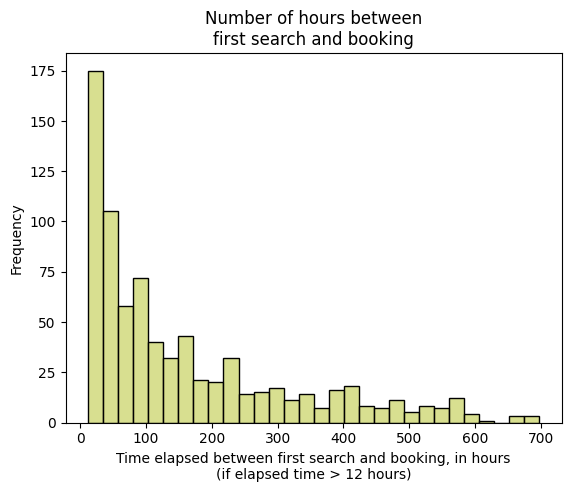

In [26]:
sns.histplot(return_time[(return_time['time_diff']>12)]['time_diff'], bins=30, color='#CCD56B')
plt.xlabel('Time elapsed between first search and booking, in hours''\n''(if elapsed time > 12 hours)')
plt.ylabel('Frequency')
plt.title('Number of hours between''\n''first search and booking')

<Axes: ylabel='Frequency'>

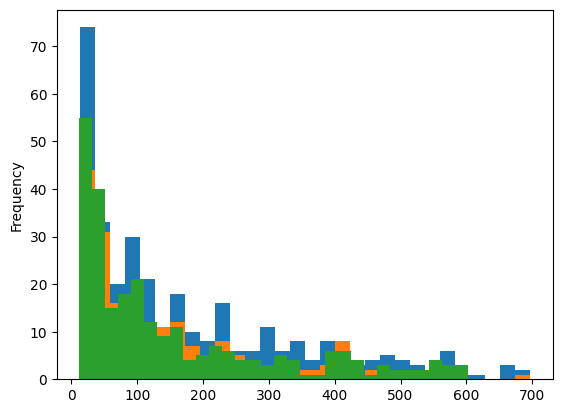

In [27]:
return_time[(return_time['hotel_id']=='hotel_1') & (return_time['time_diff']>12)]['time_diff'].plot(kind='hist', bins=30)
return_time[(return_time['hotel_id']=='hotel_2') & (return_time['time_diff']>12)]['time_diff'].plot(kind='hist', bins=30)
return_time[(return_time['hotel_id']=='hotel_3') & (return_time['time_diff']>12)]['time_diff'].plot(kind='hist', bins=30)

<Axes: xlabel='total_price_final', ylabel='rooms_total_price'>

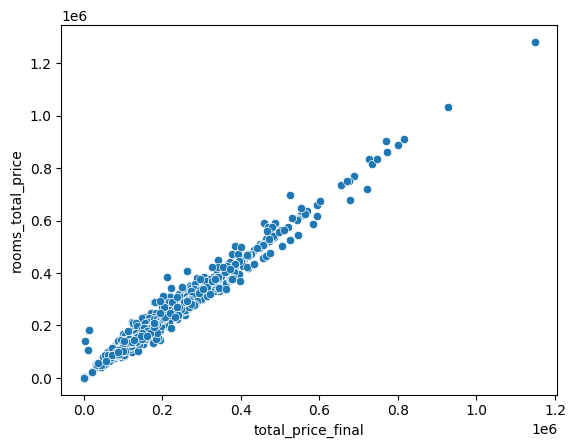

In [28]:
sns.scatterplot(data=df, x='total_price_final' ,y='rooms_total_price')


<Axes: xlabel='total_price_final', ylabel='mean_room_price'>

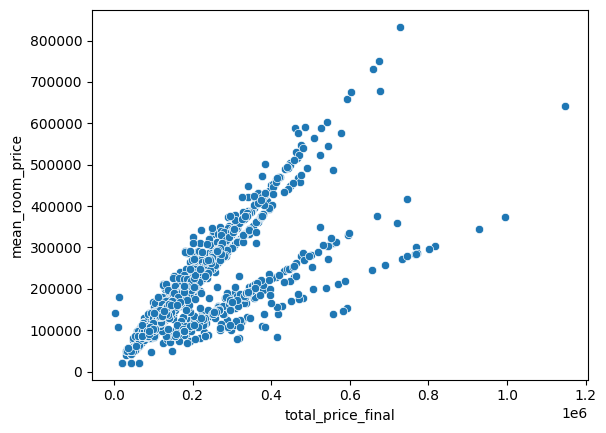

In [50]:
sns.scatterplot(data=df, x='total_price_final' ,y='mean_room_price')

### RFM

In [97]:
# RFM segmentation, based on: mean_room_price, days
# define segment boundaries based low duration = mean-1*std, medium duration = mean+-1*std, long duration = mean+1*std

df['rfm_monetary_score'] = pd.qcut(df['total_price_p_night'], 4, labels=['Low', 'Medium', 'High', 'Premium'])
df['rfm_duration_score'] = pd.cut(df['nights'], bins=[min(df['nights'])] + list([2, 4]) + [max(df['nights'])], labels=['1','2-3','4-9'] ,right=True)

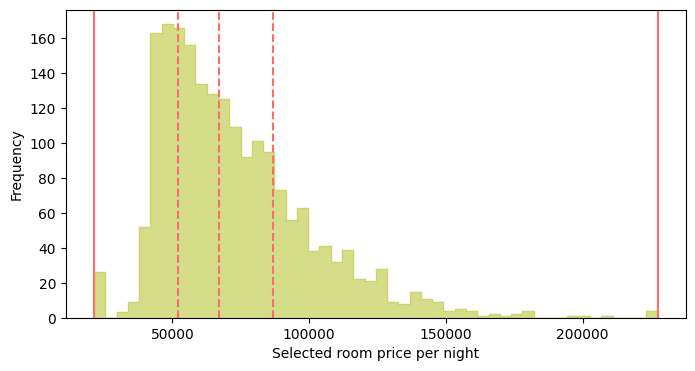

In [98]:
fig, ax = plt.subplots(1,1, figsize=(8,4))

sns.histplot(data=df['total_price_p_night'], bins=50, color='#CCD56B', alpha=0.8, element="step")
plt.xlabel('Selected room price per night')
plt.ylabel('Frequency')

#dashed lines
plt.axvline(df['total_price_p_night'].quantile(0),color='#FF6D69', linestyle='-')
plt.axvline(df['total_price_p_night'].quantile(0.25),color='#FF6D69', linestyle='--')
plt.axvline(df['total_price_p_night'].quantile(0.50),color='#FF6D69', linestyle='--')
plt.axvline(df['total_price_p_night'].quantile(0.75),color='#FF6D69', linestyle='--')
plt.axvline(df['total_price_p_night'].quantile(1),color='#FF6D69', linestyle='-')

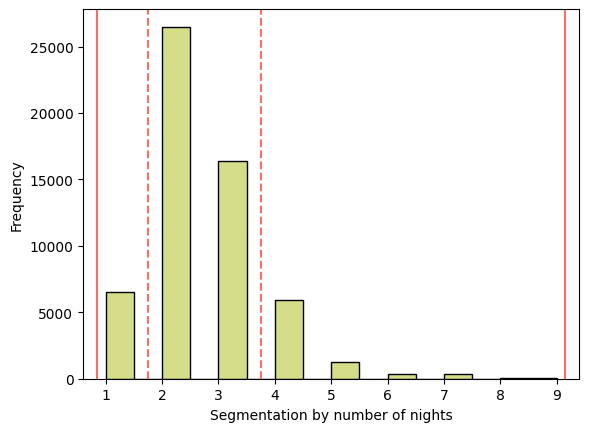

In [99]:
fig, ax = plt.subplots(1,1)

sns.histplot(data=df[df['nights']>0]['nights'], color='#CCD56B', alpha=0.8, binwidth=0.5) #, bins=9, element="step")
plt.xlabel('Segmentation by number of nights')
plt.ylabel('Frequency')

#dashed lines
plt.axvline(0.85,color='#FF6D69', linestyle='-')
plt.axvline(1.75,color='#FF6D69', linestyle='--')
plt.axvline(3.75,color='#FF6D69', linestyle='--')
plt.axvline(9.15,color='#FF6D69', linestyle='-')

In [100]:
df[df['nights']>0]['nights'].value_counts()

nights
2    26502
3    16415
1     6552
4     5932
5     1235
7      379
6      353
8       41
9       33
Name: count, dtype: int64

In [101]:
df['total_price_p_night'].quantile([0.25, 0.5, 0.75])

0.25    52247.340000
0.50    67008.097024
0.75    86893.342500
Name: total_price_p_night, dtype: float64

In [102]:
# add mean children age column
df['children_age_mean'] = df[['0_age', '1_age', '2_age', '3_age', '4_age']].mean(axis=1)

In [103]:
df.columns

Index(['search_log_session_id', 'search_log_id', 'session_id',
       'search_log_room_id', 'uuid', 'utc_datetime', 'utm_source',
       'utm_medium', 'utm_campaign', 'lang_code', 'currency', 'arrival',
       'departure', 'nights', 'adults', 'children', 'if_children',
       'children_age_mean', 'conversion', 'sel_num_of_rooms',
       'mean_room_price', 'total_price_p_night', 'picked_room', 'baby_bed',
       'pieces', 'sum_price', 'total_price_final', 'rooms_total_price',
       'upsell_total_price', 'vouchers_total_price', 'loyalty_discount_total',
       'redeemed_loyalty_points_total', 'hotel_id', 'rfm_monetary_score',
       'rfm_duration_score', '0_age', '1_age', '2_age', '3_age', '4_age',
       'ROOMAA_room_price_min', 'offered_price_median', 'offered_price_min',
       'offered_price_max', 'ROOMAA_room_price_max', 'ROOMBB_room_price_min',
       'ROOMBB_room_price_max', 'ROOMCC_room_price_min',
       'ROOMCC_room_price_max', 'ROOMDD_room_price_min',
       'ROOMDD_room_pric

In [104]:
# rearrange columns

df = df[['search_log_session_id', 'search_log_id', 'session_id', 'search_log_room_id','uuid', 'utc_datetime', 'utm_source',
   'utm_medium', 'utm_campaign','lang_code', 'currency', 'arrival', 'departure', 'nights',
    'adults', 'children', 'if_children',  'children_age_mean', 'conversion',
    'sel_num_of_rooms', 'mean_room_price', 'total_price_p_night','picked_room', 'baby_bed', 'pieces', 'sum_price', 'total_price_final',
    'rooms_total_price', 'upsell_total_price', 'vouchers_total_price',
    'loyalty_discount_total', 'redeemed_loyalty_points_total', 'hotel_id', 'rfm_monetary_score', 'rfm_duration_score', '0_age',
    '1_age', '2_age', '3_age', '4_age', 'ROOMAA_room_price_min','offered_price_median','offered_price_min','offered_price_max',
    'ROOMAA_room_price_max', 'ROOMBB_room_price_min','ROOMBB_room_price_max', 'ROOMCC_room_price_min',
    'ROOMCC_room_price_max', 'ROOMDD_room_price_min','ROOMDD_room_price_max', 'ROOMEE_room_price_min',
    'ROOMEE_room_price_max', 'ROOMFF_room_price_min','ROOMFF_room_price_max', 'ROOMGG_room_price_min',
    'ROOMGG_room_price_max', 'ROOMHH_room_price_min','ROOMHH_room_price_max', 'day_of_week',
    'is_holiday', 'time_of_day', 'stay_dates', 'lead_time',
    'lead_time_category', 'arrival_day_of_week', 'departure_day_of_week',
    'arrival_is_holiday', 'departure_is_holiday', 'stay_includes_weekend',
    'days_of_week_in_stay', 'num_saturdays', 'num_sundays']]

In [105]:
hotel1 = df[df['hotel_id']=='hotel_1'].drop(columns='hotel_id').copy()
hotel2 = df[df['hotel_id']=='hotel_2'].drop(columns='hotel_id').copy()
hotel3 = df[df['hotel_id']=='hotel_3'].drop(columns='hotel_id').copy()

In [106]:
df_unique = df.drop_duplicates(subset='uuid', keep='last')
hotel1_unique = hotel1.drop_duplicates(subset='uuid', keep='last')
hotel2_unique = hotel2.drop_duplicates(subset='uuid', keep='last')
hotel3_unique = hotel3.drop_duplicates(subset='uuid', keep='last')

# Analysis

Text(0.5, 1.0, 'Distribution of Lead time')

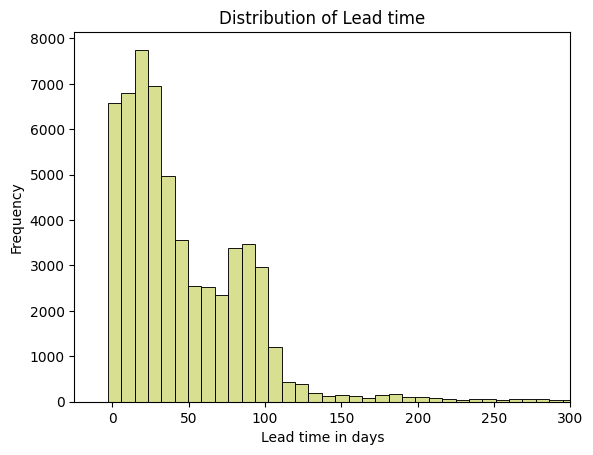

In [107]:
sns.histplot(data=df['lead_time'], bins=50, color='#CCD56B')
plt.xlabel('Lead time in days')
plt.ylabel('Frequency')
plt.xlim(right=300)
plt.title('Distribution of Lead time')

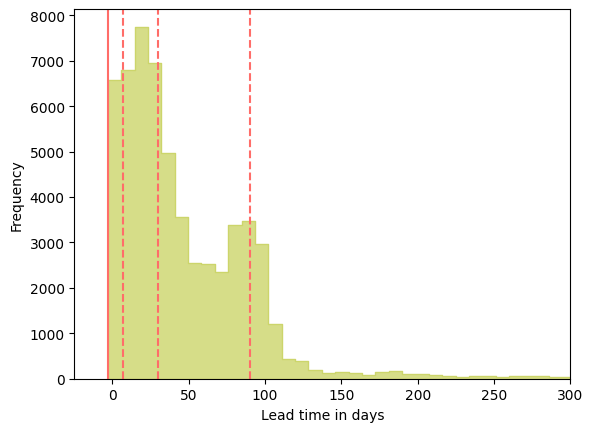

In [108]:
sns.histplot(data=df['lead_time'], bins=50, color='#CCD56B', alpha=0.8, element="step")
plt.xlabel('Lead time in days')
plt.ylabel('Frequency')
plt.xlim(right=300)

#dashed lines
plt.axvline(-3,color='#FF6D69', linestyle='-')
plt.axvline(7,color='#FF6D69', linestyle='--')
plt.axvline(30,color='#FF6D69', linestyle='--')
plt.axvline(90,color='#FF6D69', linestyle='--')

<Axes: ylabel='Frequency'>

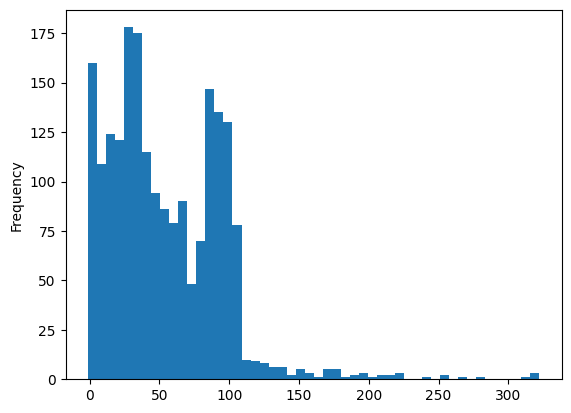

In [109]:
df[df['conversion']==1]['lead_time'].plot(kind='hist', bins=50)

<Axes: xlabel='lead_time', ylabel='Density'>

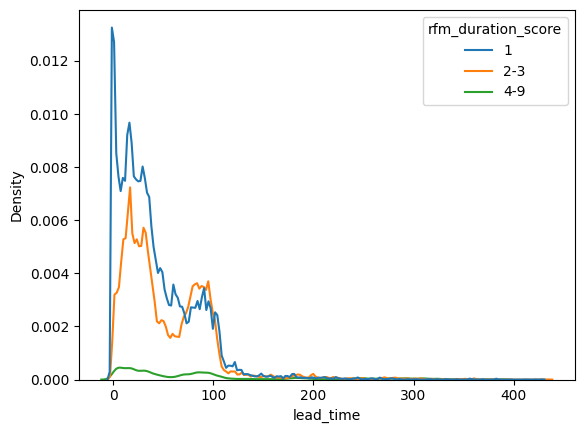

In [110]:
sns.kdeplot(data=df, x='lead_time', bw_adjust=0.2, hue='rfm_duration_score')

<Axes: xlabel='lead_time', ylabel='Density'>

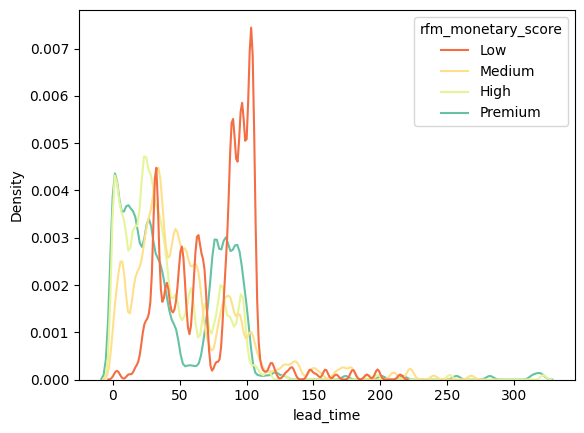

In [111]:
sns.kdeplot(data=df, x='lead_time', bw_adjust=0.2, hue='rfm_monetary_score',palette='Spectral')

<Axes: xlabel='lead_time', ylabel='Density'>

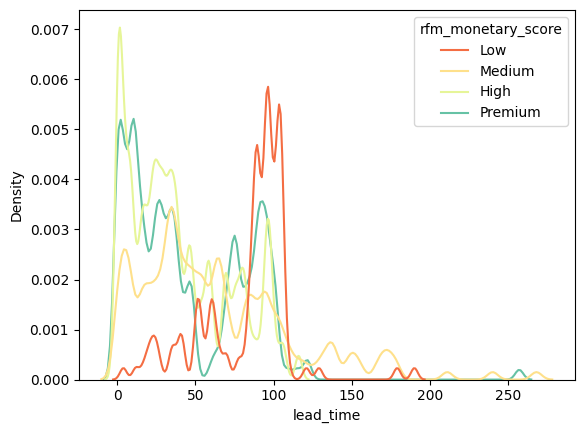

In [112]:
sns.kdeplot(data=df[df['hotel_id']=='hotel_1'], x='lead_time', bw_adjust=0.2, hue='rfm_monetary_score',palette='Spectral')

<Axes: xlabel='lead_time', ylabel='Density'>

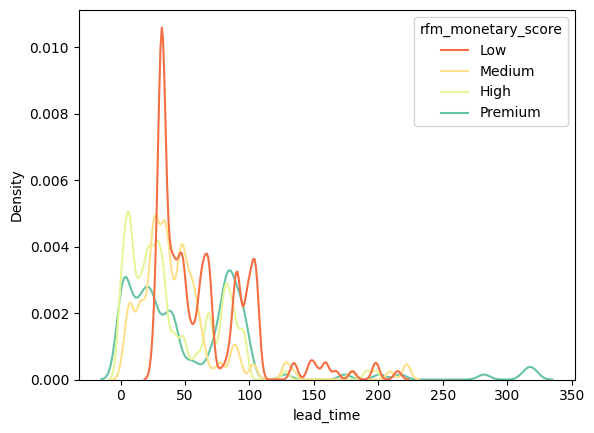

In [113]:
sns.kdeplot(data=df[df['hotel_id']=='hotel_2'], x='lead_time', bw_adjust=0.2, hue='rfm_monetary_score',palette='Spectral')

<Axes: xlabel='lead_time', ylabel='Density'>

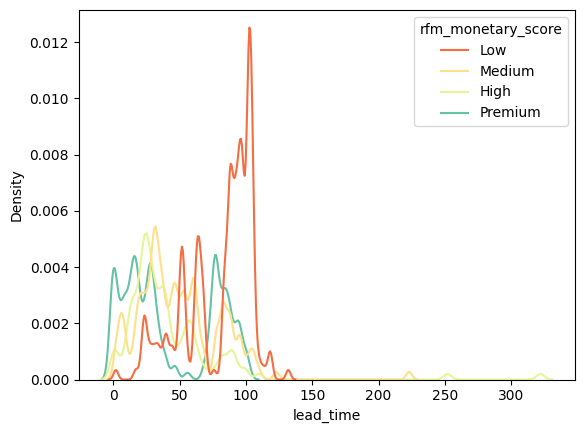

In [114]:
sns.kdeplot(data=df[df['hotel_id']=='hotel_3'], x='lead_time', bw_adjust=0.2, hue='rfm_monetary_score',palette='Spectral')

<Axes: xlabel='lead_time', ylabel='Count'>

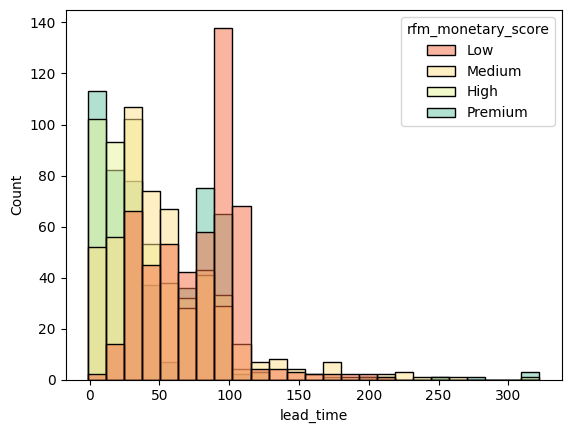

In [115]:
sns.histplot(data=df, x='lead_time', bins=25, hue='rfm_monetary_score',palette='Spectral')

<Axes: xlabel='nights', ylabel='lead_time'>

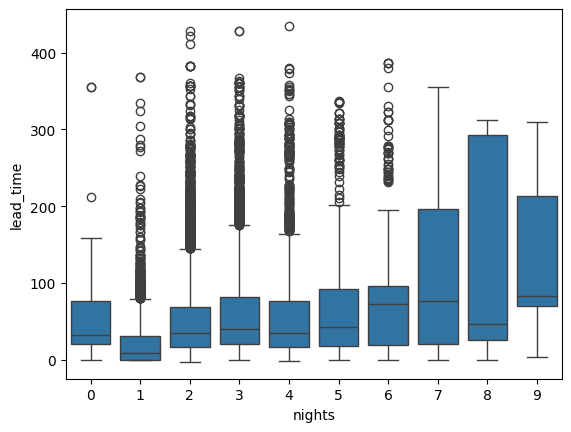

In [116]:
sns.boxplot(data=df, y='lead_time', x='nights')

<Axes: xlabel='nights', ylabel='lead_time'>

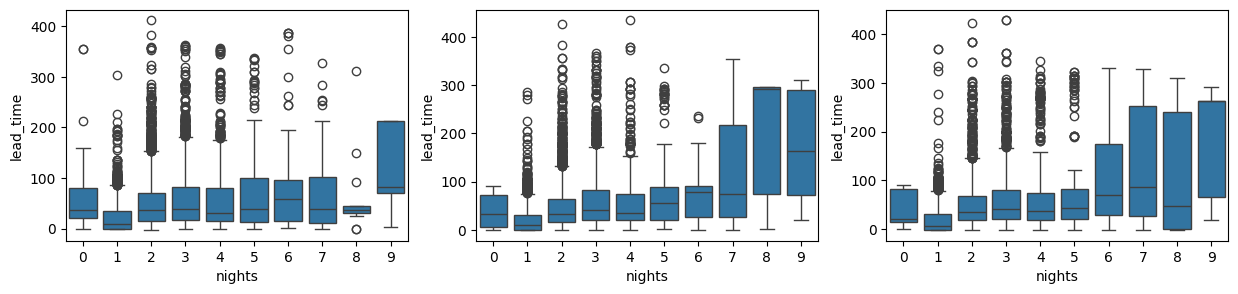

In [117]:
# Hows does the stay duration influences the lead time?
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,3))
sns.boxplot(ax=ax1 ,data=hotel1, y='lead_time', x='nights')
sns.boxplot(ax=ax2 ,data=hotel2, y='lead_time', x='nights')
sns.boxplot(ax=ax3 ,data=hotel3, y='lead_time', x='nights')

In [118]:
hotel1[['rfm_duration_score', 'lead_time']].groupby(by='rfm_duration_score').median()

lead_time
rfm_duration_score           
1                        32.0
2-3                      37.0
4-9                      40.0

In [119]:
custom_palette = ["#CCD56B", "#6CAF65", "#008464"]

Text(0, 0.5, 'Lead idő,\nnapokban')

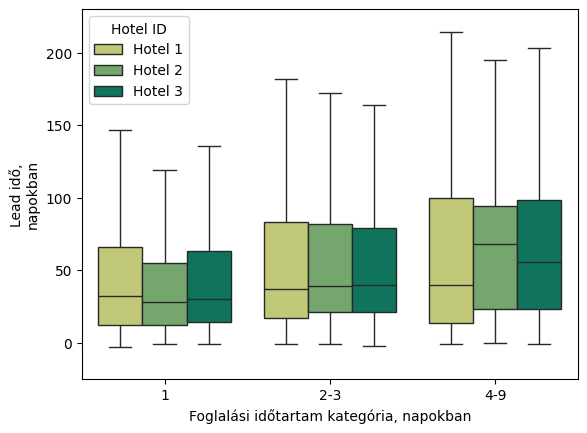

In [120]:
sns.boxplot(data=df.assign(hotel_id=df['hotel_id'].map({'hotel_1': 'Hotel 1', 'hotel_2': 'Hotel 2', 'hotel_3':'Hotel 3'})), y='lead_time', x='rfm_duration_score', hue='hotel_id',fliersize=False, palette=custom_palette).set_ylim(top=230)
plt.legend(loc='upper left', title='Hotel ID')
plt.xlabel('Foglalási időtartam kategória, napokban')
plt.ylabel('Lead idő,''\n''napokban')

In [121]:
df.columns

Index(['search_log_session_id', 'search_log_id', 'session_id',
       'search_log_room_id', 'uuid', 'utc_datetime', 'utm_source',
       'utm_medium', 'utm_campaign', 'lang_code', 'currency', 'arrival',
       'departure', 'nights', 'adults', 'children', 'if_children',
       'children_age_mean', 'conversion', 'sel_num_of_rooms',
       'mean_room_price', 'total_price_p_night', 'picked_room', 'baby_bed',
       'pieces', 'sum_price', 'total_price_final', 'rooms_total_price',
       'upsell_total_price', 'vouchers_total_price', 'loyalty_discount_total',
       'redeemed_loyalty_points_total', 'hotel_id', 'rfm_monetary_score',
       'rfm_duration_score', '0_age', '1_age', '2_age', '3_age', '4_age',
       'ROOMAA_room_price_min', 'offered_price_median', 'offered_price_min',
       'offered_price_max', 'ROOMAA_room_price_max', 'ROOMBB_room_price_min',
       'ROOMBB_room_price_max', 'ROOMCC_room_price_min',
       'ROOMCC_room_price_max', 'ROOMDD_room_price_min',
       'ROOMDD_room_pric

<Axes: xlabel='nights', ylabel='Count'>

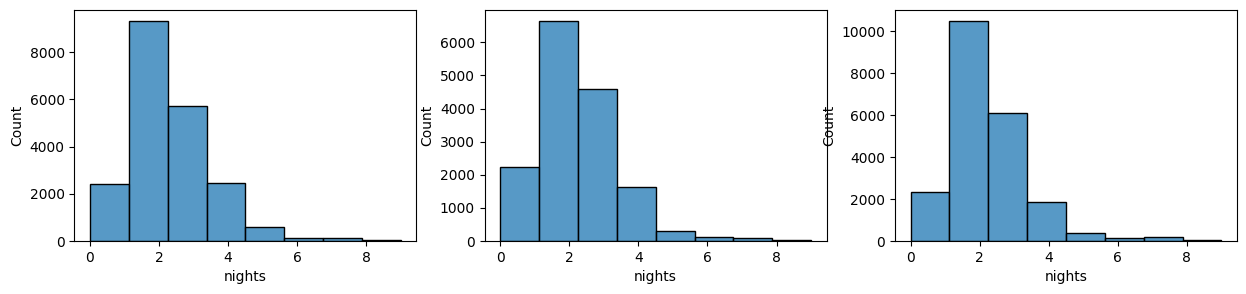

In [122]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,3))
sns.histplot(ax=ax1, data=hotel1, x='nights', bins=8)
sns.histplot(ax=ax2, data=hotel2, x='nights', bins=8)
sns.histplot(ax=ax3, data=hotel3, x='nights', bins=8)

<Axes: xlabel='nights', ylabel='total_price_p_night'>

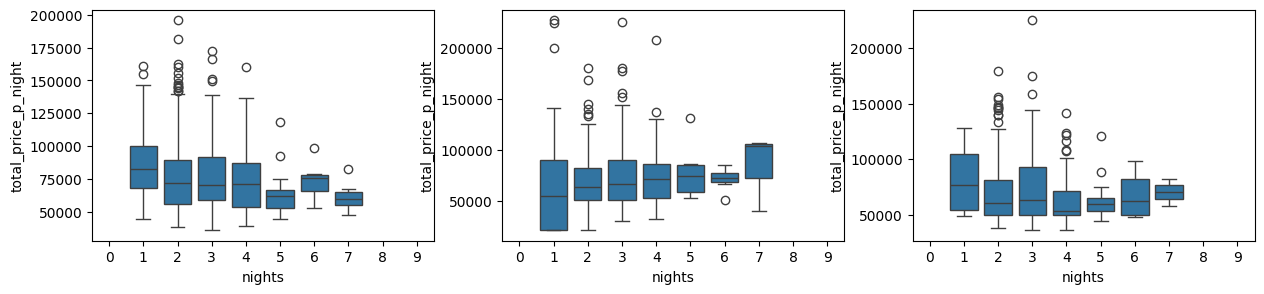

In [123]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,3))
sns.boxplot(ax=ax1, data=hotel1, x ='nights', y='total_price_p_night')
sns.boxplot(ax=ax2, data=hotel2, x ='nights', y='total_price_p_night')
sns.boxplot(ax=ax3, data=hotel3, x ='nights', y='total_price_p_night')

<Axes: xlabel='total_price_p_night', ylabel='Count'>

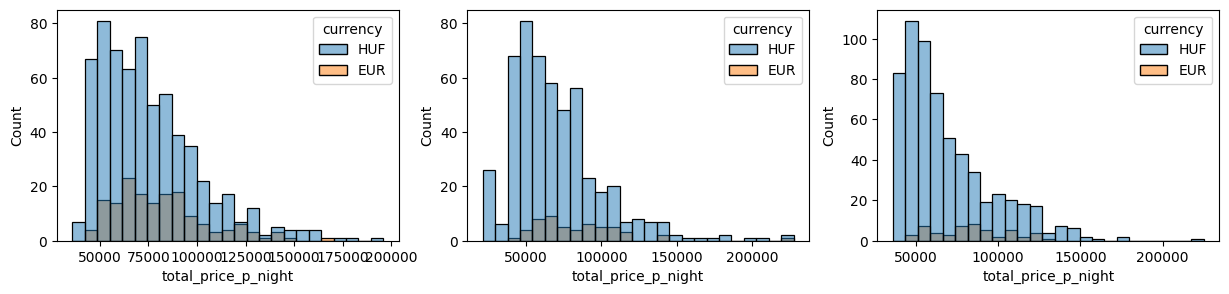

In [124]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,3))
sns.histplot(ax=ax1, data=hotel1, x='total_price_p_night', bins=25, hue='currency')
sns.histplot(ax=ax2, data=hotel2, x='total_price_p_night', bins=25, hue='currency')
sns.histplot(ax=ax3, data=hotel3, x='total_price_p_night', bins=25, hue='currency')  #lognorm distribution

In [125]:
hotel1.columns

Index(['search_log_session_id', 'search_log_id', 'session_id',
       'search_log_room_id', 'uuid', 'utc_datetime', 'utm_source',
       'utm_medium', 'utm_campaign', 'lang_code', 'currency', 'arrival',
       'departure', 'nights', 'adults', 'children', 'if_children',
       'children_age_mean', 'conversion', 'sel_num_of_rooms',
       'mean_room_price', 'total_price_p_night', 'picked_room', 'baby_bed',
       'pieces', 'sum_price', 'total_price_final', 'rooms_total_price',
       'upsell_total_price', 'vouchers_total_price', 'loyalty_discount_total',
       'redeemed_loyalty_points_total', 'rfm_monetary_score',
       'rfm_duration_score', '0_age', '1_age', '2_age', '3_age', '4_age',
       'ROOMAA_room_price_min', 'offered_price_median', 'offered_price_min',
       'offered_price_max', 'ROOMAA_room_price_max', 'ROOMBB_room_price_min',
       'ROOMBB_room_price_max', 'ROOMCC_room_price_min',
       'ROOMCC_room_price_max', 'ROOMDD_room_price_min',
       'ROOMDD_room_price_max', 'ROO

In [126]:
# with every room search
pd.concat([df[['hotel_id','adults', 'children', 'if_children', 'conversion','sel_num_of_rooms',
               'total_price_p_night','children_age_mean', 'baby_bed','rfm_duration_score']],
           df[['upsell_total_price', 'loyalty_discount_total','redeemed_loyalty_points_total']].replace(to_replace=0, value=None)], axis=1).groupby(by=['hotel_id','rfm_duration_score']).mean().style.format('{0:,.2f}').bar(color='#d65f5f')

In [127]:
# this drops the duplicates in uuid!!! - keeping only the last room search
pd.concat([df[['hotel_id','uuid','adults', 'children', 'if_children', 'conversion','sel_num_of_rooms',
               'total_price_p_night','children_age_mean', 'baby_bed','rfm_duration_score']],
           df[['upsell_total_price', 'loyalty_discount_total','redeemed_loyalty_points_total']].replace(to_replace=0, value=None)], axis=1).drop_duplicates(subset='uuid', keep='last').drop(columns='uuid').groupby(by=['hotel_id','rfm_duration_score']).mean().style.format('{0:,.2f}').bar(color='#d65f5f')

In [128]:
# groupby if=weekend

In [129]:
# with every conversion
pd.concat([df[['hotel_id','adults', 'children', 'if_children','sel_num_of_rooms','nights',
               'children_age_mean', 'baby_bed','rfm_monetary_score']],
           df[['upsell_total_price', 'loyalty_discount_total','redeemed_loyalty_points_total']].replace(to_replace=0, value=None)], axis=1).groupby(by=['hotel_id','rfm_monetary_score']).mean().style.format('{0:,.2f}').bar(color='#d65f5f')

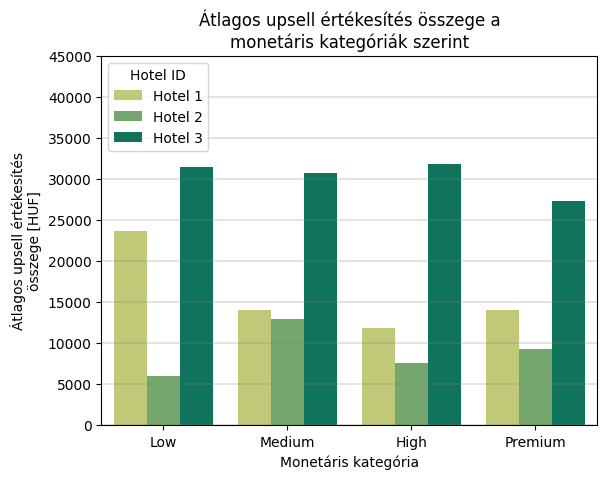

In [130]:
sns.barplot(data=df.assign(hotel_id=df['hotel_id'].map({'hotel_1': 'Hotel 1', 'hotel_2': 'Hotel 2', 'hotel_3':'Hotel 3'})), x='rfm_monetary_score', y=df['upsell_total_price'].replace(to_replace=0, value=None), hue='hotel_id', estimator="mean", errorbar=None, palette=custom_palette)
plt.legend(loc='upper left', title='Hotel ID')
plt.ylim(top=45000)
plt.xlabel('Monetáris kategória')
plt.ylabel('Átlagos upsell értékesítés''\n''összege [HUF]')
plt.title('Átlagos upsell értékesítés összege a''\n''monetáris kategóriák szerint')
plt.grid(which='major', axis='y', color='gray', linewidth=0.3)

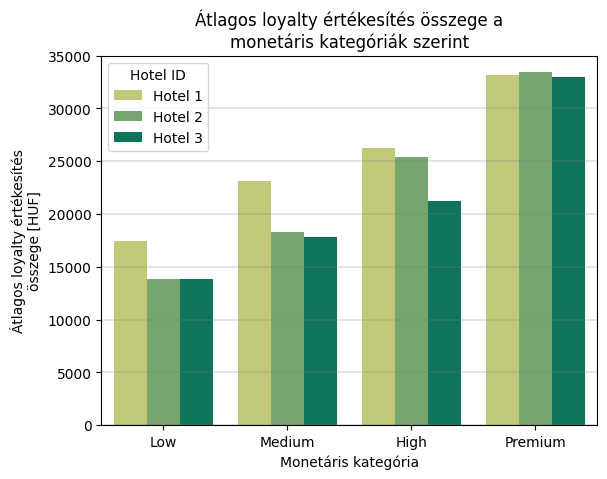

In [131]:
sns.barplot(data=df.assign(hotel_id=df['hotel_id'].map({'hotel_1': 'Hotel 1', 'hotel_2': 'Hotel 2', 'hotel_3':'Hotel 3'})), x='rfm_monetary_score', y=df['loyalty_discount_total'].replace(to_replace=0, value=None), hue='hotel_id', errorbar=None, estimator="mean", palette=custom_palette)

plt.legend(loc='upper left', title='Hotel ID')
plt.ylim(top=35000)
plt.xlabel('Monetáris kategória')
plt.ylabel('Átlagos loyalty értékesítés''\n''összege [HUF]')
plt.title('Átlagos loyalty értékesítés összege a''\n''monetáris kategóriák szerint')
plt.grid(which='major', axis='y', color='gray', linewidth=0.3)

In [132]:
# with every conversion
pd.concat([df[['hotel_id','if_children',
               'children_age_mean','rfm_monetary_score']],
           df[['upsell_total_price', 'loyalty_discount_total']].replace(to_replace=0, value=None)], axis=1).groupby(by=['hotel_id','rfm_monetary_score']).mean().style.format('{0:,.2f}').bar(color='#d65f5f')

In [133]:
df[df['if_children']==True][['hotel_id','children','rfm_monetary_score']].groupby(by=['hotel_id','rfm_monetary_score']).mean()

children
hotel_id rfm_monetary_score          
hotel_1  Low                 1.227273
         Medium              1.818182
         High                1.718310
         Premium             1.755102
hotel_2  Low                 1.240000
         Medium              1.200000
         High                1.534884
         Premium             1.657534
hotel_3  Low                 1.571429
         Medium              1.157895
         High                1.533333
         Premium             1.732143

In [134]:
# who converted and who not
pd.concat([df_unique[['hotel_id','adults', 'children', 'if_children','sel_num_of_rooms','nights',
               'children_age_mean', 'baby_bed','conversion']],
           df_unique[['upsell_total_price', 'loyalty_discount_total','redeemed_loyalty_points_total']].replace(to_replace=0, value=None)], axis=1).groupby(by=['hotel_id','conversion']).mean().style.format('{0:,.2f}').bar(color='#d65f5f')

Text(0, 0.5, 'average number of childrens')

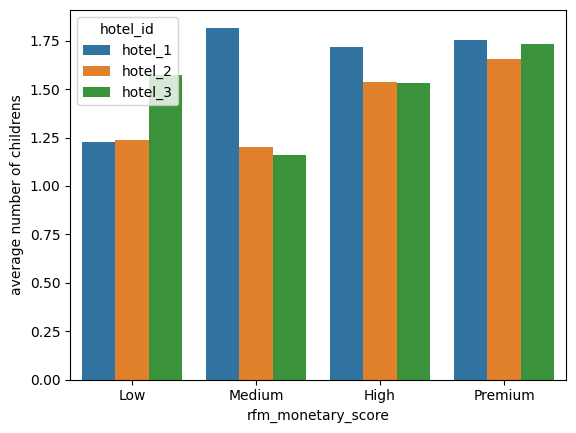

In [135]:
sns.barplot(data=df[df['if_children']==True][['hotel_id','children','rfm_monetary_score']].groupby(by=['hotel_id','rfm_monetary_score']).mean().reset_index(), x='rfm_monetary_score', y='children', hue='hotel_id')
plt.ylabel('average number of childrens')

<Axes: xlabel='rfm_monetary_score'>

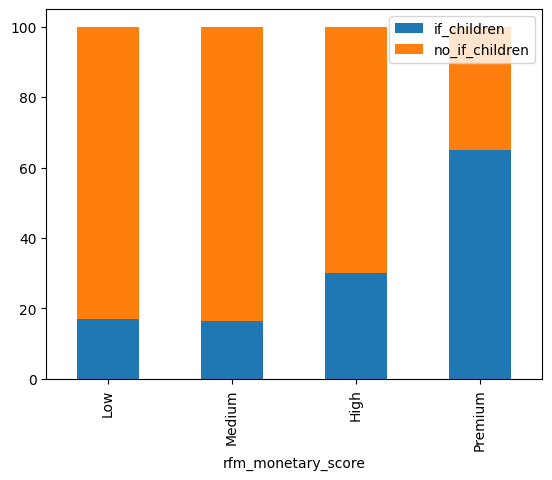

In [136]:
test = (hotel1[['if_children','rfm_monetary_score']].groupby(by='rfm_monetary_score').mean()*100).reset_index()
test['no_if_children'] = 100-test['if_children']
test.plot(x='rfm_monetary_score',kind='bar',stacked=True)

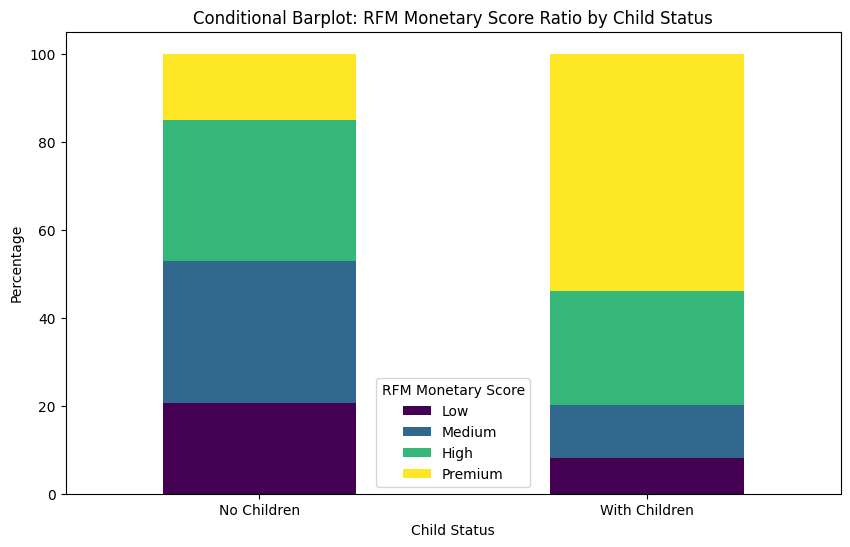

In [137]:
# for hotel 1

# Step 1: Calculate counts by 'if_children' and 'rfm_monetary_score'
counts = (
    hotel1[['if_children', 'rfm_monetary_score']]
    .groupby(['if_children', 'rfm_monetary_score'])
    .size()
    .reset_index(name='count'))  # Name the count column explicitly

# Step 2: Normalize the counts to percentages within each 'if_children' group
counts['percentage'] = (
    counts.groupby('if_children')['count']
    .transform(lambda x: 100 * x / x.sum()))

# Step 3: Pivot the data to reshape for plotting
pivot = counts.pivot(
    index='if_children',          # Rows: If Children (0 or 1)
    columns='rfm_monetary_score', # Columns: RFM monetary score
    values='percentage'           # Values: Percentage
).fillna(0)  # Fill any missing values with 0

# Step 4: Plot the data
pivot.plot(kind='bar', stacked=True, figsize=(10, 6), cmap="viridis")
plt.title('Conditional Barplot: RFM Monetary Score Ratio by Child Status')
plt.xlabel('Child Status')
plt.ylabel('Percentage')
plt.xticks(ticks=[0, 1], labels=['No Children', 'With Children'], rotation=0)
plt.legend(title='RFM Monetary Score')
plt.show()


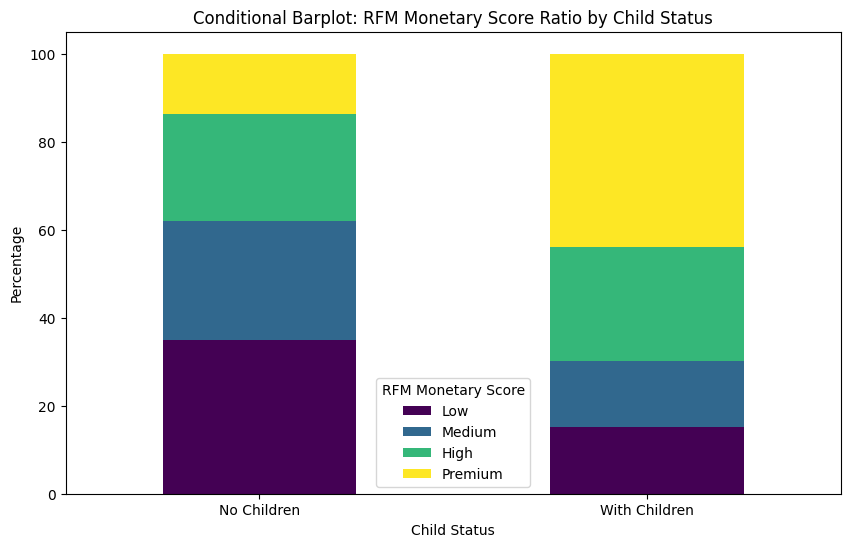

In [138]:
# for hotel 2

# Step 1: Calculate counts by 'if_children' and 'rfm_monetary_score'
counts = (
    hotel2[['if_children', 'rfm_monetary_score']]
    .groupby(['if_children', 'rfm_monetary_score'])
    .size()
    .reset_index(name='count'))  # Name the count column explicitly

# Step 2: Normalize the counts to percentages within each 'if_children' group
counts['percentage'] = (
    counts.groupby('if_children')['count']
    .transform(lambda x: 100 * x / x.sum()))

# Step 3: Pivot the data to reshape for plotting
pivot = counts.pivot(
    index='if_children',          # Rows: If Children (0 or 1)
    columns='rfm_monetary_score', # Columns: RFM monetary score
    values='percentage'           # Values: Percentage
).fillna(0)  # Fill any missing values with 0

# Step 4: Plot the data
pivot.plot(kind='bar', stacked=True, figsize=(10, 6), cmap="viridis")
plt.title('Conditional Barplot: RFM Monetary Score Ratio by Child Status')
plt.xlabel('Child Status')
plt.ylabel('Percentage')
plt.xticks(ticks=[0, 1], labels=['No Children', 'With Children'], rotation=0)
plt.legend(title='RFM Monetary Score')
plt.show()

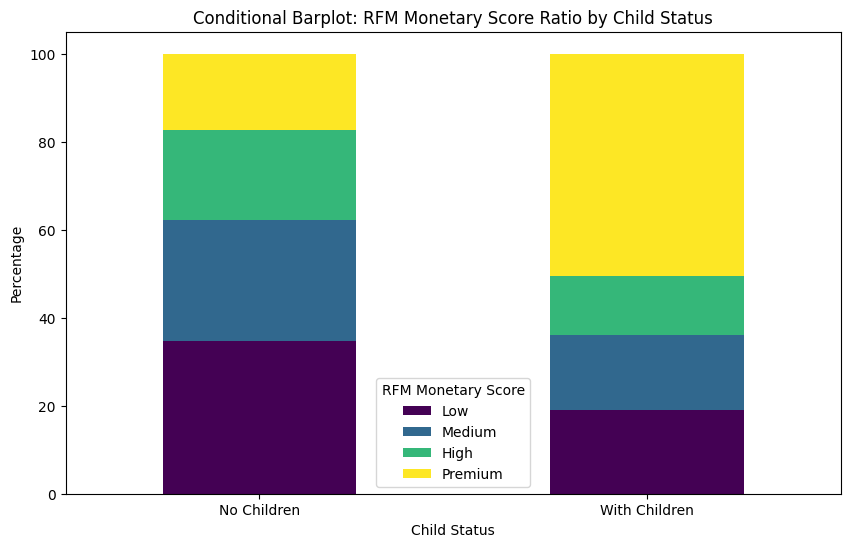

In [139]:
# for hotel 3

# Step 1: Calculate counts by 'if_children' and 'rfm_monetary_score'
counts = (
    hotel3[['if_children', 'rfm_monetary_score']]
    .groupby(['if_children', 'rfm_monetary_score'])
    .size()
    .reset_index(name='count'))  # Name the count column explicitly

# Step 2: Normalize the counts to percentages within each 'if_children' group
counts['percentage'] = (
    counts.groupby('if_children')['count']
    .transform(lambda x: 100 * x / x.sum()))

# Step 3: Pivot the data to reshape for plotting
pivot = counts.pivot(
    index='if_children',          # Rows: If Children (0 or 1)
    columns='rfm_monetary_score', # Columns: RFM monetary score
    values='percentage'           # Values: Percentage
).fillna(0)  # Fill any missing values with 0

# Step 4: Plot the data
pivot.plot(kind='bar', stacked=True, figsize=(10, 6), cmap="viridis")
plt.title('Conditional Barplot: RFM Monetary Score Ratio by Child Status')
plt.xlabel('Child Status')
plt.ylabel('Percentage')
plt.xticks(ticks=[0, 1], labels=['No Children', 'With Children'], rotation=0)
plt.legend(title='RFM Monetary Score')
plt.show()

In [140]:
custom_palette

['#CCD56B', '#6CAF65', '#008464']

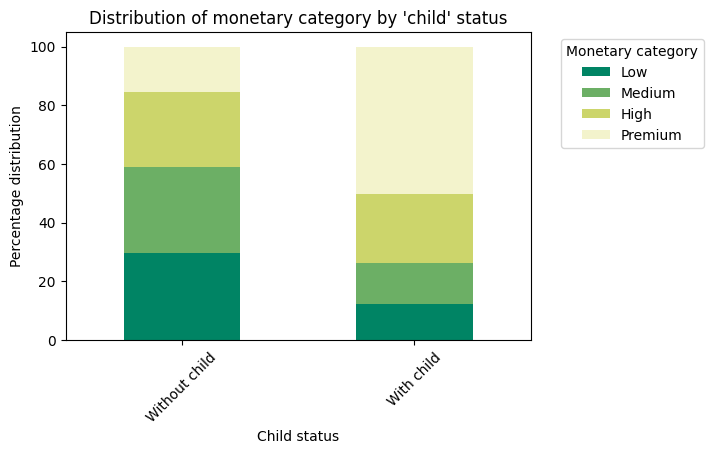

In [141]:
# for df

import matplotlib.colors

# Step 1: Calculate counts by 'if_children' and 'rfm_monetary_score'
counts = (
    df[['if_children', 'rfm_monetary_score']]
    .groupby(['if_children', 'rfm_monetary_score'])
    .size()
    .reset_index(name='count'))  # Name the count column explicitly

# Step 2: Normalize the counts to percentages within each 'if_children' group
counts['percentage'] = (
    counts.groupby('if_children')['count']
    .transform(lambda x: 100 * x / x.sum()))

# Step 3: Pivot the data to reshape for plotting
pivot = counts.pivot(
    index='if_children',          # Rows: If Children (0 or 1)
    columns='rfm_monetary_score', # Columns: RFM monetary score
    values='percentage'           # Values: Percentage
).fillna(0)  # Fill any missing values with 0

# Step 4: Plot the data
pivot.plot(kind='bar', stacked=True, figsize=(6, 4), cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ['#008464', '#6CAF65', '#CCD56B', '#F3F3CC']))
plt.title("Distribution of monetary category by 'child' status")
plt.xlabel('Child status')
plt.ylabel('Percentage distribution')
plt.xticks(ticks=[0, 1], labels=['Without child', 'With child'], rotation=45)
plt.legend(title='Monetary category', loc='upper left',bbox_to_anchor=(1.05, 1))

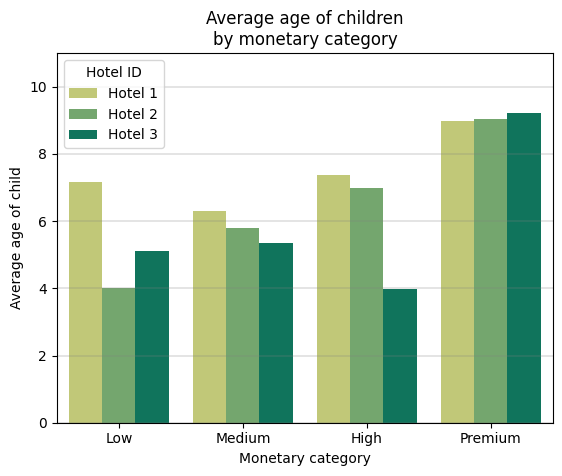

In [142]:
sns.barplot(data=df.assign(hotel_id=df['hotel_id'].map({'hotel_1': 'Hotel 1', 'hotel_2': 'Hotel 2', 'hotel_3':'Hotel 3'})), x='rfm_monetary_score', y='children_age_mean', hue='hotel_id', errorbar=None, palette=custom_palette)
plt.ylim(top=11)

plt.legend(loc='upper left', title='Hotel ID')
plt.xlabel('Monetary category')
plt.ylabel('Average age of child')
plt.title('Average age of children''\n''by monetary category')
plt.grid(which='major', axis='y', color='gray', linewidth=0.3)

<Axes: xlabel='if_children', ylabel='rfm_monetary_score'>

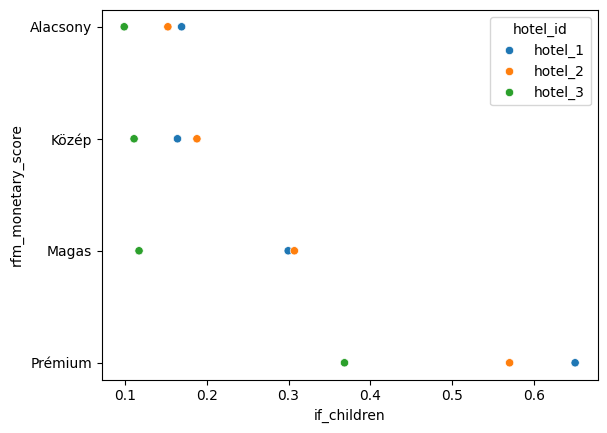

In [96]:
sns.scatterplot(data=df[['hotel_id','if_children','rfm_monetary_score']].groupby(by=['hotel_id','rfm_monetary_score']).mean().reset_index(), y='rfm_monetary_score', x='if_children', hue='hotel_id')

In [97]:
df[['hotel_id','children','rfm_monetary_score']].groupby(by=['hotel_id','rfm_monetary_score']).mean().reset_index()

hotel_id rfm_monetary_score  children
0   hotel_1           Alacsony  0.207692
1   hotel_1              Közép  0.298507
2   hotel_1              Magas  0.514768
3   hotel_1            Prémium  1.141593
4   hotel_2           Alacsony  0.189024
5   hotel_2              Közép  0.225564
6   hotel_2              Magas  0.471429
7   hotel_2            Prémium  0.945312
8   hotel_3           Alacsony  0.155660
9   hotel_3              Közép  0.128655
10  hotel_3              Magas  0.179688
11  hotel_3            Prémium  0.638158

In [98]:
# with every conversion
pd.concat([df[['hotel_id','adults', 'if_children','sel_num_of_rooms','nights','total_price_p_night','conversion']],
           df[['upsell_total_price', 'loyalty_discount_total','redeemed_loyalty_points_total']].replace(to_replace=0, value=None)], axis=1).groupby(by=['hotel_id','if_children']).mean().style.format('{0:,.2f}').bar(color='#d65f5f')

<Axes: xlabel='if_children', ylabel='total_price_p_night'>

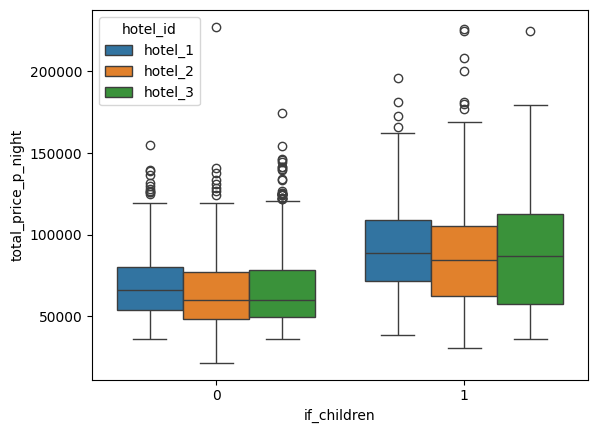

In [99]:
sns.boxplot(data=df, x='if_children', y='total_price_p_night', hue='hotel_id')

<Axes: xlabel='hotel_id', ylabel='upsell_total_price'>

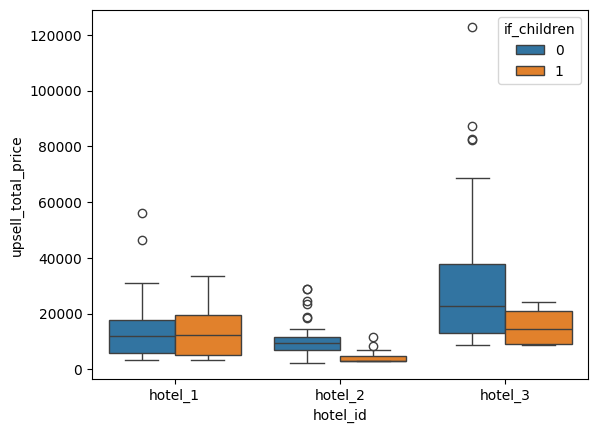

In [100]:
sns.boxplot(data=df[df['upsell_total_price']>0], x='hotel_id', y='upsell_total_price', hue='if_children')

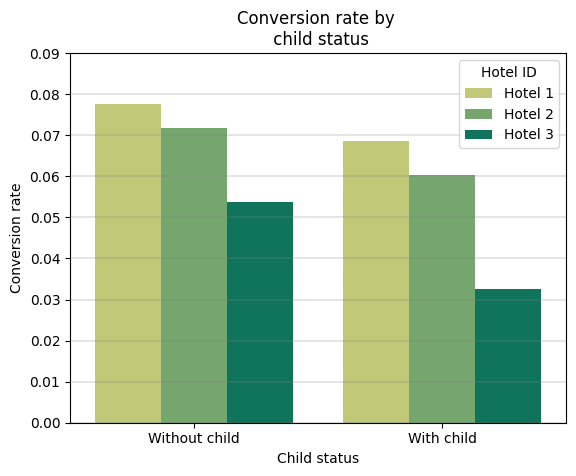

In [145]:
sns.barplot(data=df_unique[['hotel_id','if_children','conversion']].groupby(by=['hotel_id','if_children']).mean().reset_index().assign(hotel_id=df_unique[['hotel_id','if_children','conversion']].groupby(by=['hotel_id','if_children']).mean().reset_index()['hotel_id'].map({'hotel_1': 'Hotel 1', 'hotel_2': 'Hotel 2', 'hotel_3':'Hotel 3'})), 
            x='if_children', y='conversion', hue='hotel_id', palette=custom_palette)
plt.xticks(ticks=[0, 1], labels=['Without child', 'With child'])
plt.ylim(top=0.09)
plt.legend(loc='upper right', title='Hotel ID')
plt.xlabel('Child status')
plt.ylabel('Conversion rate')
plt.title('Conversion rate by ''\n'' child status')
plt.grid(which='major', axis='y', color='gray', linewidth=0.3)

In [149]:
df_to_plot = df_unique.copy()
df_to_plot['upsell_total_price'].replace(to_replace=0, value=None, inplace=True)

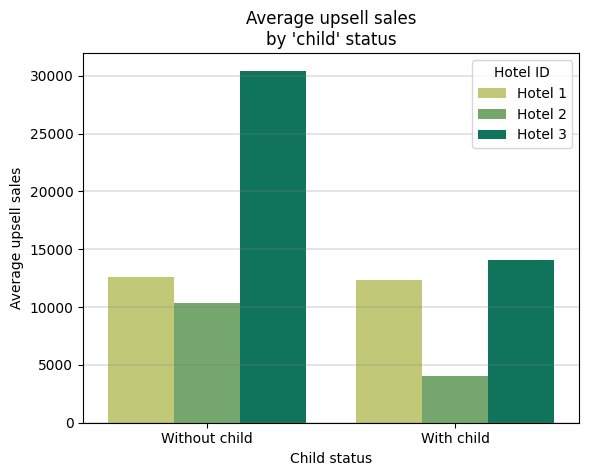

In [151]:
sns.barplot(data=df_to_plot[['hotel_id','if_children','upsell_total_price']].groupby(by=['hotel_id','if_children']).mean().reset_index().assign(hotel_id=df_unique[['hotel_id','if_children','upsell_total_price']].groupby(by=['hotel_id','if_children']).mean().reset_index()['hotel_id'].map({'hotel_1': 'Hotel 1', 'hotel_2': 'Hotel 2', 'hotel_3':'Hotel 3'})), 
            x='if_children', y='upsell_total_price', hue='hotel_id', palette=custom_palette)

plt.xticks(ticks=[0, 1], labels=['Without child', 'With child'])
plt.legend(loc='upper right', title='Hotel ID')
plt.xlabel('Child status')
plt.ylabel('Average upsell sales')
plt.title("Average upsell sales""\n""by 'child' status")
plt.grid(which='major', axis='y', color='gray', linewidth=0.3)

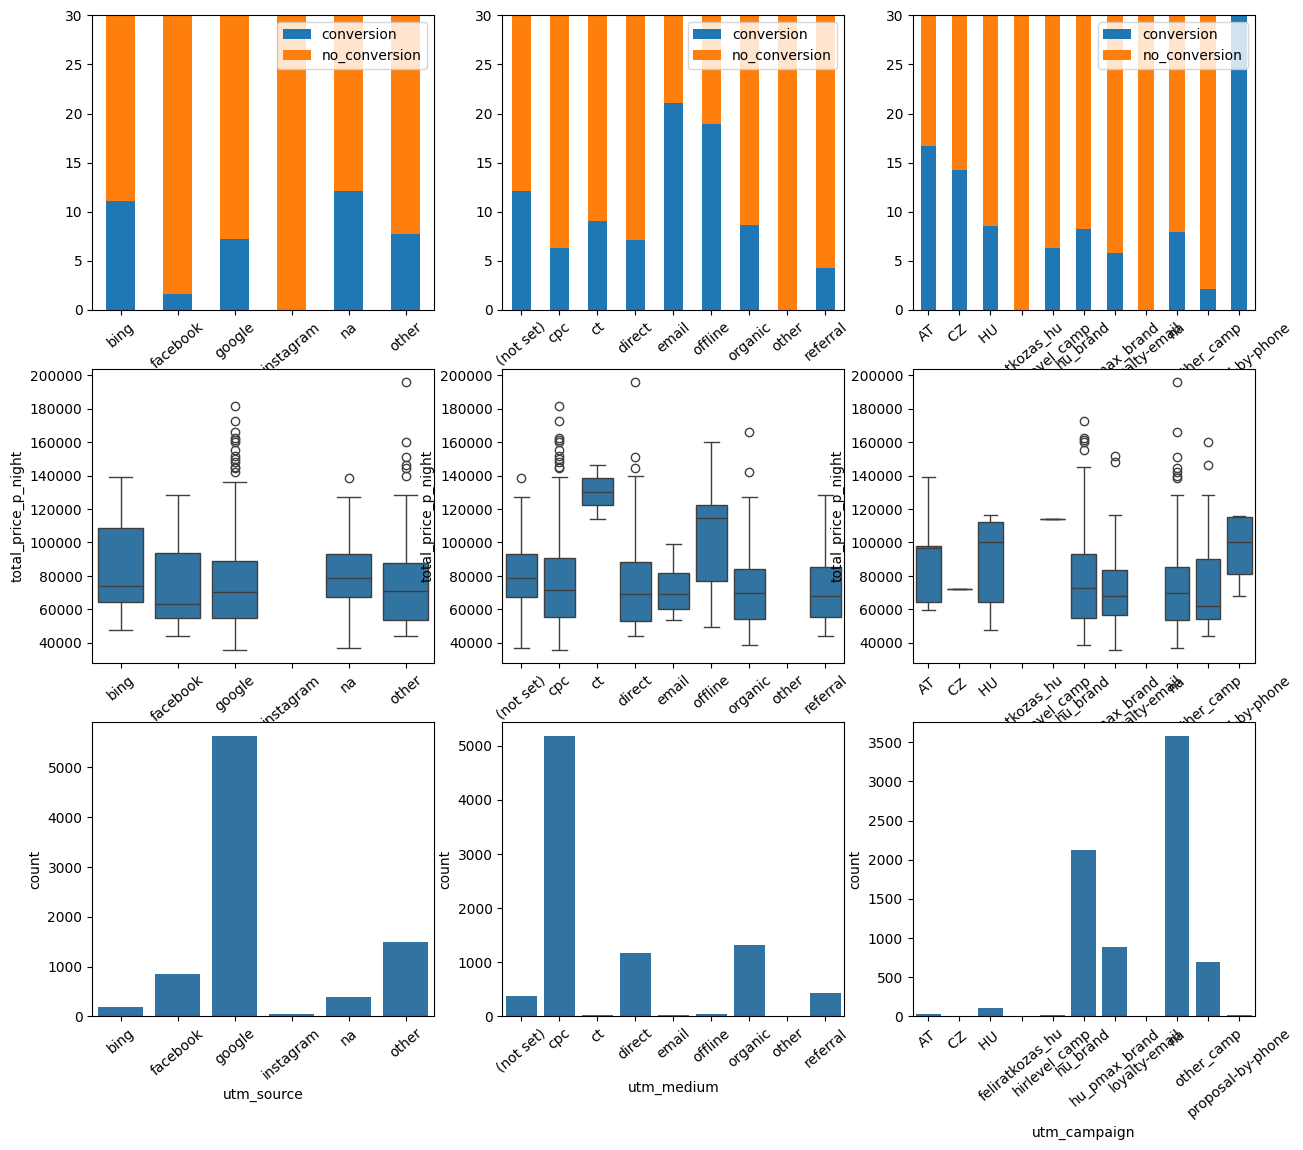

In [104]:
# stacked barplot according to utm_campaign, medium and source for each hotel

fig, ((ax1, ax2, ax3), (ax21, ax22, ax23), (ax31, ax32, ax33)) = plt.subplots(3,3, figsize=(15,13))

test = (hotel1_unique[['conversion','utm_source']].groupby(by='utm_source').mean()*100).reset_index()
test['no_conversion'] = 100-test['conversion']
test.plot(x='utm_source',kind='bar',stacked=True, ax=ax1).tick_params(axis='x', rotation=40)
ax1.set_ylim(top=30)

test2 = (hotel1_unique[['conversion','utm_medium']].groupby(by='utm_medium').mean()*100).reset_index()
test2['no_conversion'] = 100-test2['conversion']
test2.plot(x='utm_medium',kind='bar',stacked=True, ax=ax2).tick_params(axis='x', rotation=40)
ax2.set_ylim(top=30)

test3 = (hotel1_unique[['conversion','utm_campaign']].groupby(by='utm_campaign').mean()*100).reset_index()
test3['no_conversion'] = 100-test3['conversion']
test3.plot(x='utm_campaign',kind='bar',stacked=True, ax=ax3).tick_params(axis='x', rotation=40)
ax3.set_ylim(top=30)

sns.boxplot(data=hotel1_unique, x='utm_source', y='total_price_p_night', ax=ax21, order=['bing', 'facebook', 'google', 'instagram', 'na', 'other']).tick_params(axis='x', rotation=40)
sns.boxplot(data=hotel1_unique, x='utm_medium', y='total_price_p_night', ax=ax22, order=['(not set)', 'cpc', 'ct', 'direct', 'email', 'offline','organic','other','referral']).tick_params(axis='x', rotation=40)
sns.boxplot(data=hotel1_unique, x='utm_campaign', y='total_price_p_night', ax=ax23, order=['AT ', 'CZ ', 'HU ', 'feliratkozas_hu', 'hirlevel_camp', 'hu_brand','hu_pmax_brand','loyalty-email','na','other_camp','proposal-by-phone']).tick_params(axis='x', rotation=40)

sns.countplot(data=hotel1_unique, x='utm_source', ax=ax31, order=['bing', 'facebook', 'google', 'instagram', 'na', 'other']).tick_params(axis='x', rotation=40)
sns.countplot(data=hotel1_unique, x='utm_medium', ax=ax32, order=['(not set)', 'cpc', 'ct', 'direct', 'email', 'offline','organic','other','referral']).tick_params(axis='x', rotation=40)
sns.countplot(data=hotel1_unique, x='utm_campaign', ax=ax33, order=['AT ', 'CZ ', 'HU ', 'feliratkozas_hu', 'hirlevel_camp', 'hu_brand','hu_pmax_brand','loyalty-email','na','other_camp','proposal-by-phone']).tick_params(axis='x', rotation=40)

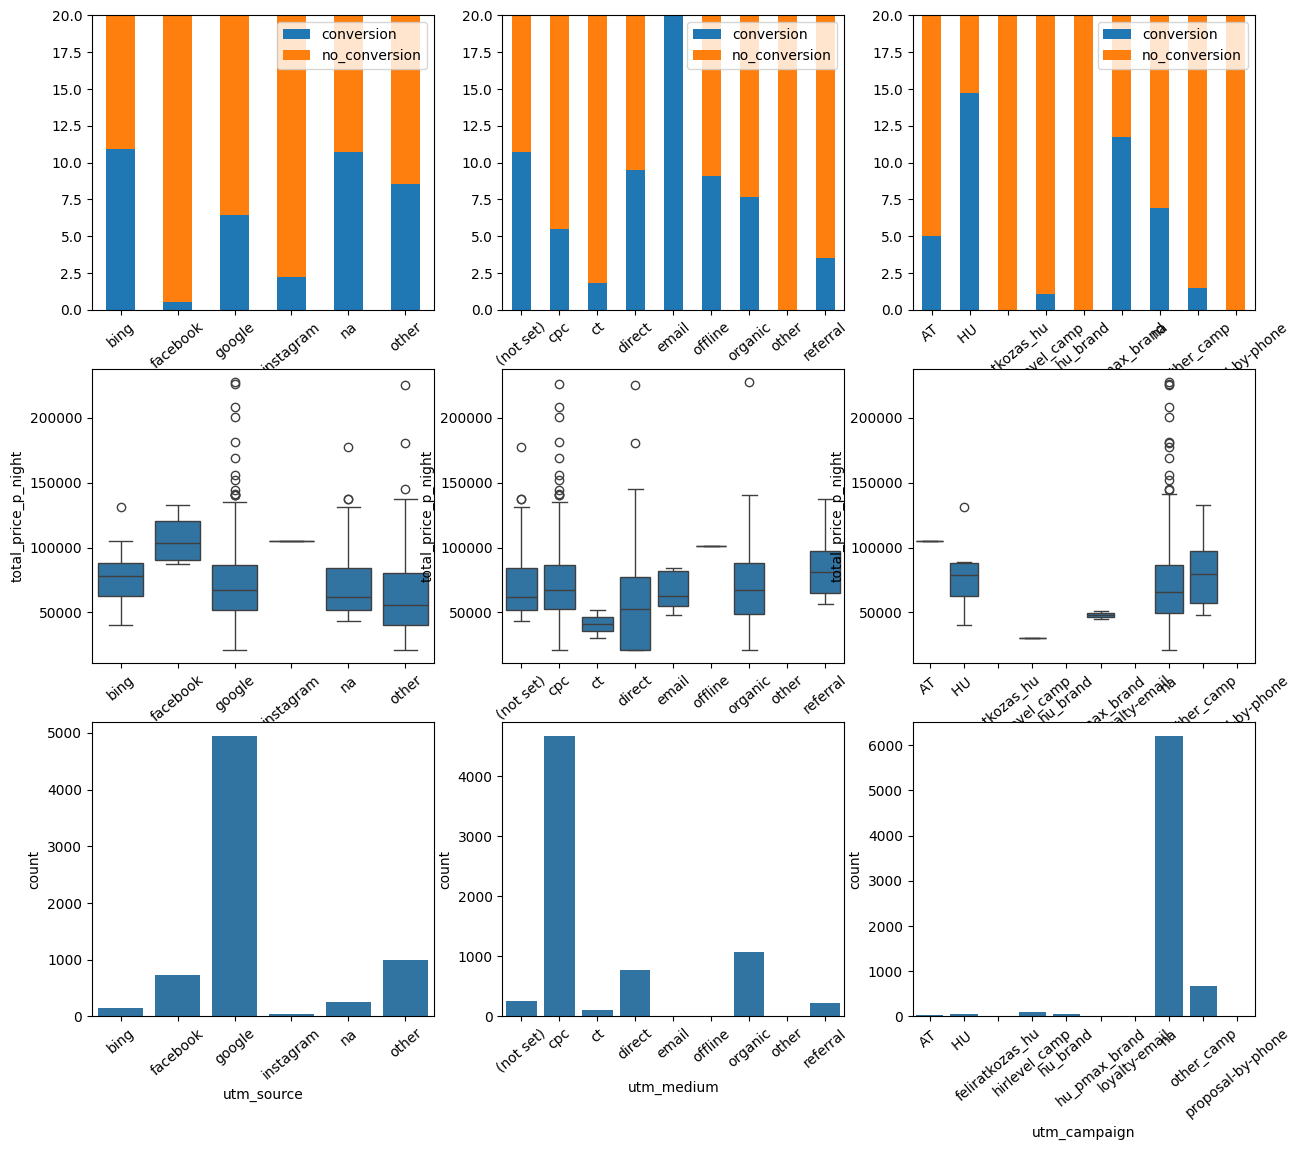

In [105]:
fig, ((ax1, ax2, ax3), (ax21, ax22, ax23), (ax31, ax32, ax33)) = plt.subplots(3,3, figsize=(15,13))

test = (hotel2_unique[['conversion','utm_source']].groupby(by='utm_source').mean()*100).reset_index()
test['no_conversion'] = 100-test['conversion']
test.plot(x='utm_source',kind='bar',stacked=True, ax=ax1).tick_params(axis='x', rotation=40)
ax1.set_ylim(top=20)

test2 = (hotel2_unique[['conversion','utm_medium']].groupby(by='utm_medium').mean()*100).reset_index()
test2['no_conversion'] = 100-test2['conversion']
test2.plot(x='utm_medium',kind='bar',stacked=True, ax=ax2).tick_params(axis='x', rotation=40)
ax2.set_ylim(top=20)

test3 = (hotel2_unique[['conversion','utm_campaign']].groupby(by='utm_campaign').mean()*100).reset_index()
test3['no_conversion'] = 100-test3['conversion']
test3.plot(x='utm_campaign',kind='bar',stacked=True, ax=ax3).tick_params(axis='x', rotation=40)
ax3.set_ylim(top=20)

sns.boxplot(data=hotel2_unique, x='utm_source', y='total_price_p_night', ax=ax21, order=['bing', 'facebook', 'google', 'instagram', 'na', 'other']).tick_params(axis='x', rotation=40)
sns.boxplot(data=hotel2_unique, x='utm_medium', y='total_price_p_night', ax=ax22, order=['(not set)', 'cpc', 'ct', 'direct', 'email', 'offline','organic', 'other', 'referral']).tick_params(axis='x', rotation=40)
sns.boxplot(data=hotel2_unique, x='utm_campaign', y='total_price_p_night', ax=ax23, order=['AT ', 'HU ', 'feliratkozas_hu', 'hirlevel_camp', 'hu_brand','hu_pmax_brand','loyalty-email','na','other_camp','proposal-by-phone']).tick_params(axis='x', rotation=40)

sns.countplot(data=hotel2_unique, x='utm_source', ax=ax31, order=['bing', 'facebook', 'google', 'instagram', 'na', 'other']).tick_params(axis='x', rotation=40)
sns.countplot(data=hotel2_unique, x='utm_medium', ax=ax32, order=['(not set)', 'cpc', 'ct', 'direct', 'email', 'offline','organic', 'other', 'referral']).tick_params(axis='x', rotation=40)
sns.countplot(data=hotel2_unique, x='utm_campaign', ax=ax33, order=['AT ', 'HU ', 'feliratkozas_hu', 'hirlevel_camp', 'hu_brand','hu_pmax_brand','loyalty-email','na','other_camp','proposal-by-phone']).tick_params(axis='x', rotation=40)

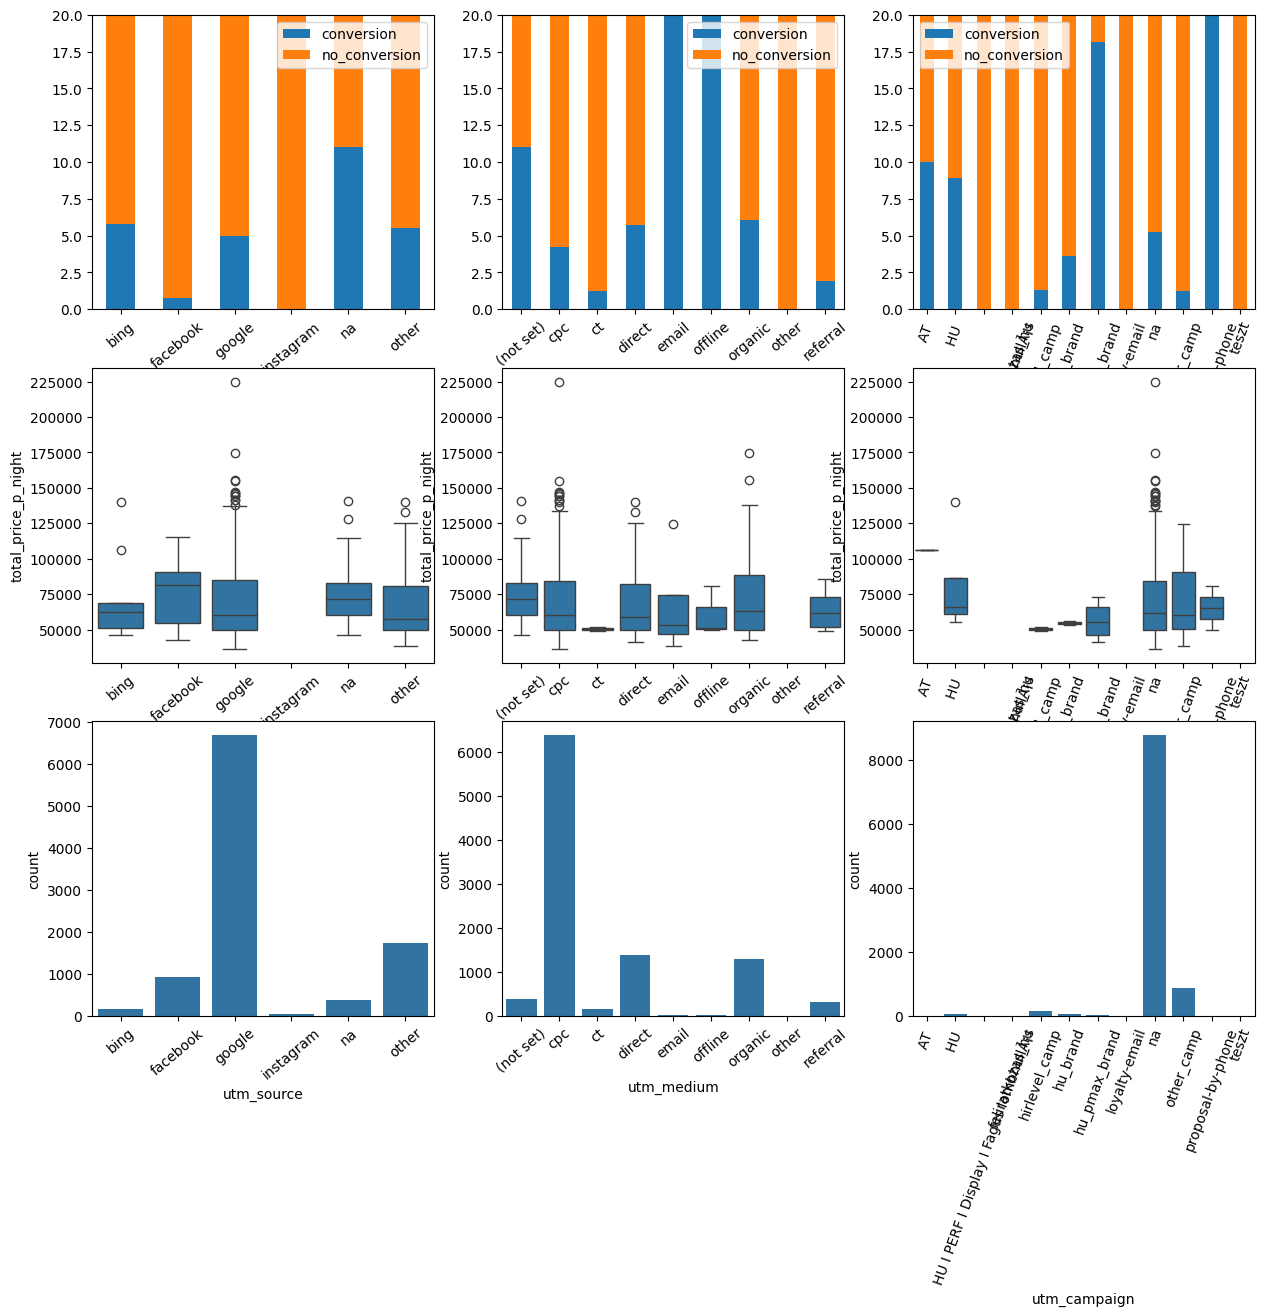

In [106]:
fig, ((ax1, ax2, ax3), (ax21, ax22, ax23), (ax31, ax32, ax33)) = plt.subplots(3,3, figsize=(15,13))

test = (hotel3_unique[['conversion','utm_source']].groupby(by='utm_source').mean()*100).reset_index()
test['no_conversion'] = 100-test['conversion']
test.plot(x='utm_source',kind='bar',stacked=True, ax=ax1).tick_params(axis='x', rotation=40)
ax1.set_ylim(top=20)

test2 = (hotel3_unique[['conversion','utm_medium']].groupby(by='utm_medium').mean()*100).reset_index()
test2['no_conversion'] = 100-test2['conversion']
test2.plot(x='utm_medium',kind='bar',stacked=True, ax=ax2).tick_params(axis='x', rotation=40)
ax2.set_ylim(top=20)

test3 = (hotel3_unique[['conversion','utm_campaign']].groupby(by='utm_campaign').mean()*100).reset_index()
test3['no_conversion'] = 100-test3['conversion']
test3.plot(x='utm_campaign',kind='bar',stacked=True, ax=ax3).tick_params(axis='x', rotation=70)
ax3.set_ylim(top=20)

sns.boxplot(data=hotel3_unique, x='utm_source', y='total_price_p_night', ax=ax21, order=['bing', 'facebook', 'google', 'instagram', 'na', 'other']).tick_params(axis='x', rotation=40)
sns.boxplot(data=hotel3_unique, x='utm_medium', y='total_price_p_night', ax=ax22, order=['(not set)', 'cpc', 'ct', 'direct', 'email', 'offline','organic', 'other', 'referral']).tick_params(axis='x', rotation=40)
sns.boxplot(data=hotel3_unique, x='utm_campaign', y='total_price_p_night', ax=ax23, order=['AT ', 'HU ', 'HU I PERF I Display I Fagus lombhullÃ¡s', 'feliratkozas_hu','hirlevel_camp', 'hu_brand','hu_pmax_brand','loyalty-email','na','other_camp','proposal-by-phone','teszt']).tick_params(axis='x', rotation=70)

sns.countplot(data=hotel3_unique, x='utm_source', ax=ax31, order=['bing', 'facebook', 'google', 'instagram', 'na', 'other']).tick_params(axis='x', rotation=40)
sns.countplot(data=hotel3_unique, x='utm_medium', ax=ax32, order=['(not set)', 'cpc', 'ct', 'direct', 'email', 'offline','organic', 'other', 'referral']).tick_params(axis='x', rotation=40)
sns.countplot(data=hotel3_unique, x='utm_campaign', ax=ax33, order=['AT ', 'HU ', 'HU I PERF I Display I Fagus lombhullÃ¡s', 'feliratkozas_hu','hirlevel_camp', 'hu_brand','hu_pmax_brand','loyalty-email','na','other_camp','proposal-by-phone','teszt']).tick_params(axis='x', rotation=70)

In [107]:
# adott napon mennyi volt a ppc költés, és azon a napon adott ppc forrásból mennyi bevétel jött

ppc_data = pd.read_csv('./../data-workfile/ppc_performance.csv', index_col='Unnamed: 0')



<Axes: xlabel='currency', ylabel='nights'>

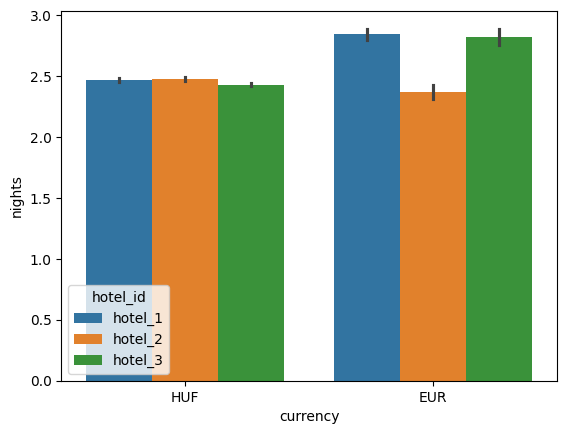

In [108]:
sns.barplot(data=df, x='currency', y='nights', hue='hotel_id', estimator='mean')

<Axes: xlabel='rfm_duration_score', ylabel='children_age_mean'>

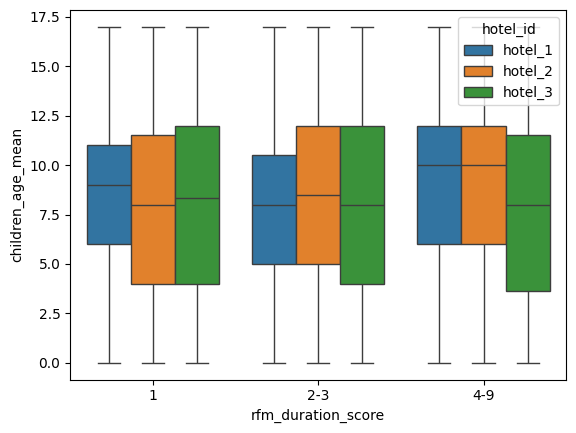

In [109]:
sns.boxplot(data=df[df['if_children']==True], x='rfm_duration_score', y='children_age_mean', hue='hotel_id')

<Axes: xlabel='currency'>

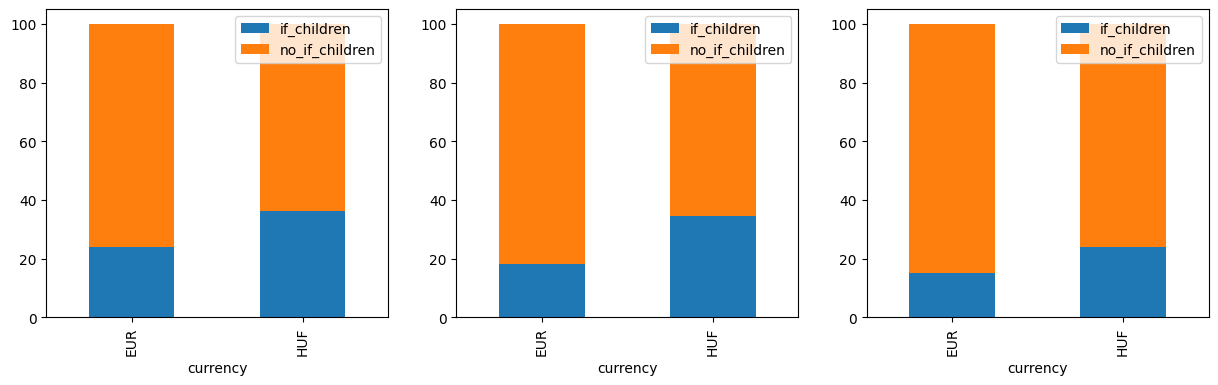

In [110]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))

test = (hotel1_unique[['if_children','currency']].groupby(by='currency').mean()*100).reset_index()
test['no_if_children'] = 100-test['if_children']
test.plot(ax=ax1, x='currency',kind='bar',stacked=True)

test = (hotel2_unique[['if_children','currency']].groupby(by='currency').mean()*100).reset_index()
test['no_if_children'] = 100-test['if_children']
test.plot(ax=ax2, x='currency',kind='bar',stacked=True)

test = (hotel3_unique[['if_children','currency']].groupby(by='currency').mean()*100).reset_index()
test['no_if_children'] = 100-test['if_children']
test.plot(ax=ax3, x='currency',kind='bar',stacked=True)

(0.0, 20.0)

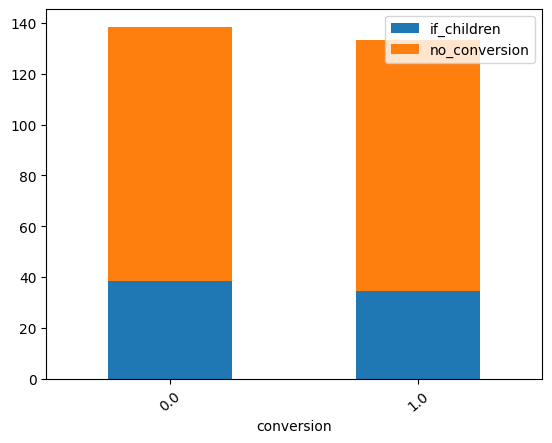

In [111]:
test = (hotel1[['if_children','conversion']].groupby(by='conversion').mean()*100).reset_index()
test['no_conversion'] = 100-test['conversion']
test.plot(x='conversion',kind='bar',stacked=True).tick_params(axis='x', rotation=40)
ax1.set_ylim(top=20)

In [112]:
df[['hotel_id','total_price_p_night','rfm_duration_score']].groupby(by=['hotel_id','rfm_duration_score']).median()

total_price_p_night
hotel_id rfm_duration_score                     
hotel_1  1                          73440.000000
         2-3                        70848.147778
         4-9                        62172.000000
hotel_2  1                          63575.550000
         2-3                        67321.945000
         4-9                        74187.036667
hotel_3  1                          61261.000000
         2-3                        61499.507867
         4-9                        61371.000000

# Search patterns and key variables

- what are the visitors looking for?

<Axes: xlabel='arrival'>

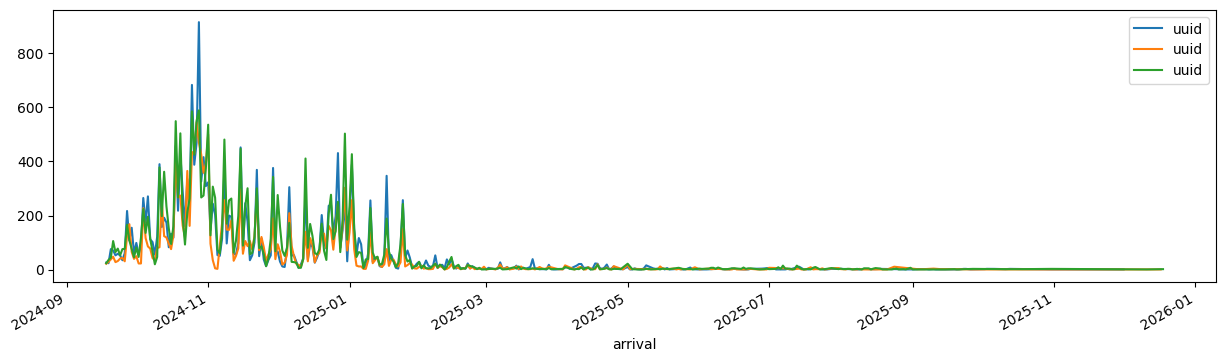

In [113]:
fig, ax1 = plt.subplots(1,1,figsize=(15,4))
hotel1[['arrival','uuid']].groupby(by='arrival').count().plot(ax=ax1)
hotel2[['arrival','uuid']].groupby(by='arrival').count().plot(ax=ax1)
hotel3[['arrival','uuid']].groupby(by='arrival').count().plot(ax=ax1)

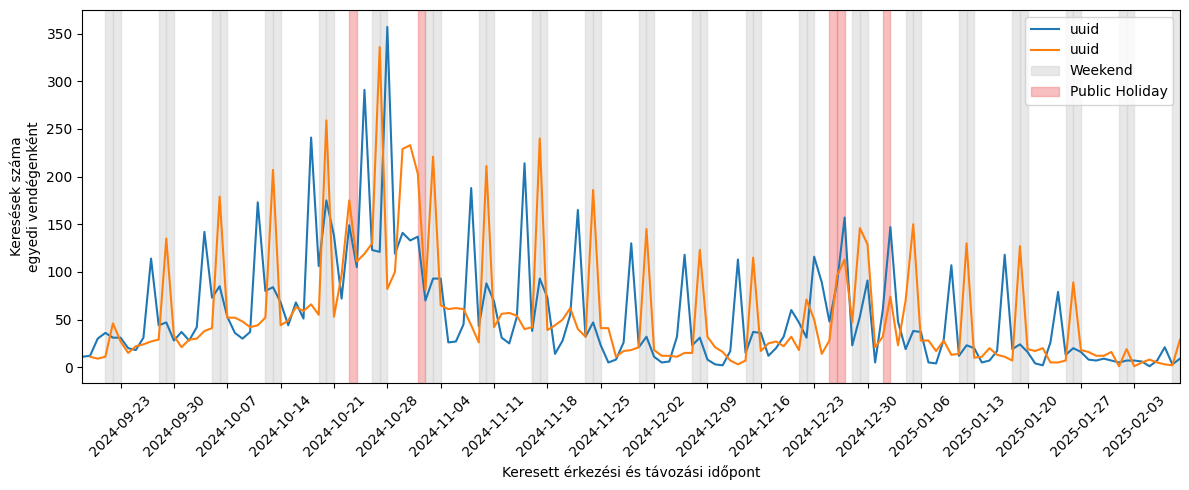

In [153]:
import matplotlib.dates as mdates
from datetime import timedelta

# Hungarian public holidays
public_holidays = [
    "2024-10-23",  # Revolution Day
    "2024-11-01",  # All Saints' Day
    "2024-12-25",  # Christmas Day
    "2024-12-26",  # Second Day of Christmas
    "2025-01-01",  # New Year's Day
    "2025-03-15",  # Revolution Memorial Day
]
# public holidays to datetime
public_holidays = pd.to_datetime(public_holidays)
fig, ax1 = plt.subplots(1, 1, figsize=(12, 5))

hotel1_unique[hotel1_unique['arrival'] < '2025-02-10'][['arrival', 'uuid']].groupby(by='arrival').count().plot(ax=ax1, label='Hotel 1')
hotel1_unique[hotel1_unique['departure'] < '2025-02-10'][['departure', 'uuid']].groupby(by='departure').count().plot(ax=ax1, label='Hotel 1')

# highlight weekends
start_date = pd.to_datetime('2024-09-01')  # Adjust based on your data range
end_date = pd.to_datetime('2025-02-10')
current_date = start_date

while current_date <= end_date:
    if current_date.weekday() >= 5:  # Saturday (5) and Sunday (6)
        ax1.axvspan(current_date, current_date + timedelta(days=1), color='lightgrey', alpha=0.5, label='Weekend' if current_date == start_date else None)
    current_date += timedelta(days=1)

# highlight public holidays
for holiday in public_holidays:
    if start_date <= holiday <= end_date:
        ax1.axvspan(holiday, holiday + timedelta(days=1), color='lightcoral', alpha=0.5, label='Public Holiday' if holiday == public_holidays[0] else None)

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
plt.xticks(rotation=45)

ax1.set_xlabel('Keresett érkezési és távozási időpont')
ax1.set_ylabel('Keresések száma''\n''egyedi vendégenként')
ax1.legend()
plt.tight_layout()


<Axes: xlabel='departure_day_of_week', ylabel='count'>

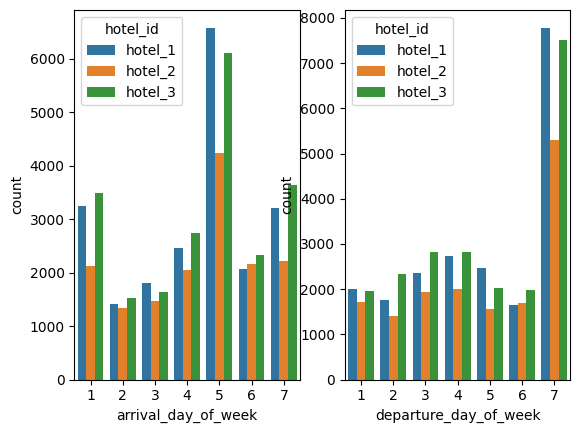

In [154]:
fig, (ax1, ax2) = plt.subplots(1,2)
sns.countplot(ax=ax1, data=df, x='arrival_day_of_week', hue='hotel_id')
sns.countplot(ax=ax2, data=df, x='departure_day_of_week', hue='hotel_id')

<Axes: xlabel='arrival_day_of_week'>

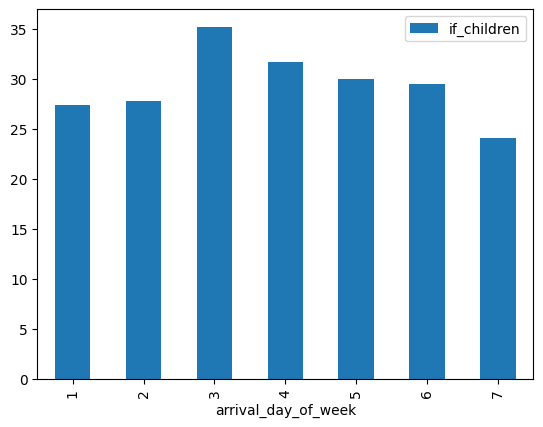

In [155]:
(df_unique[['if_children','arrival_day_of_week']].groupby(by='arrival_day_of_week').mean()*100).plot(kind='bar')

<Axes: xlabel='departure_day_of_week'>

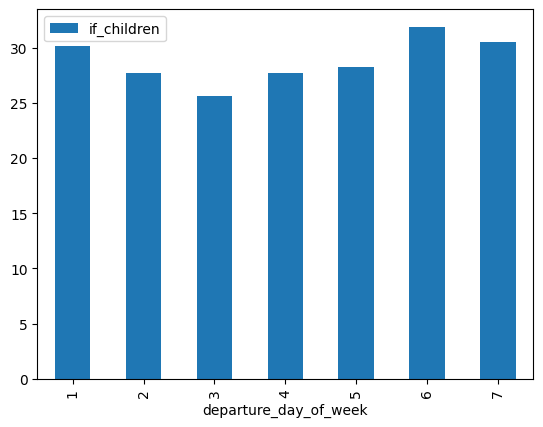

In [156]:
(df_unique[['if_children','departure_day_of_week']].groupby(by='departure_day_of_week').mean()*100).plot(kind='bar')

<Axes: xlabel='day_of_week', ylabel='count'>

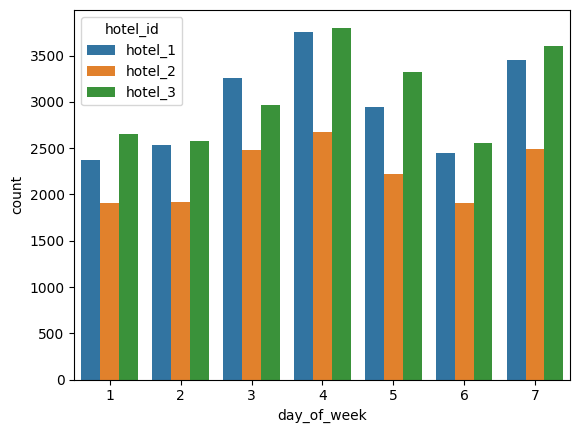

In [157]:
# on which day the guests search for hotel rooms?
sns.countplot(data=df, x='day_of_week', hue='hotel_id')

<Axes: xlabel='time_of_day', ylabel='count'>

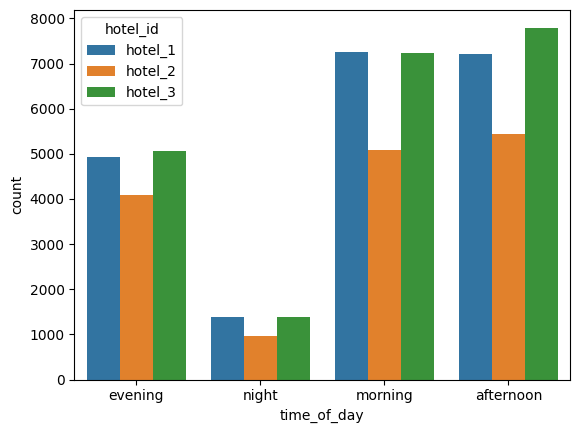

In [158]:
# on which time of the day the guests search for hotel rooms?

sns.countplot(data=df, x='time_of_day', hue='hotel_id')

<Axes: xlabel='currency', ylabel='lead_time'>

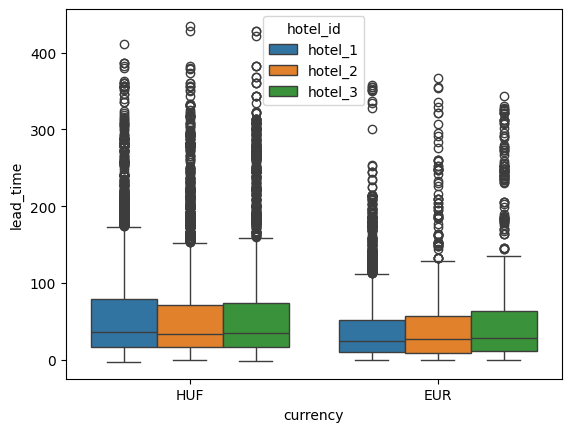

In [159]:
sns.boxplot(data=df[['currency','hotel_id', 'lead_time']], x='currency', y='lead_time', hue='hotel_id')

In [160]:
# define the specific order for 'lead_time_category'
order = ['last_minute', 'short_term', 'medium_term', 'long_term']
df['lead_time_category'] = pd.Categorical(df['lead_time_category'], categories=order, ordered=True)

df[['nights', 'if_children', 'children_age_mean', 'conversion', 'total_price_p_night','hotel_id','lead_time_category']].groupby(by=['hotel_id', 'lead_time_category'], sort=True).mean().style.format('{0:,.2f}').bar(color='#d65f5f')

In [161]:
# only unique uuids
# define the specific order for 'lead_time_category'
df_unique['lead_time_category'] = pd.Categorical(df_unique['lead_time_category'], categories=order, ordered=True)

df_unique[['nights', 'if_children', 'children_age_mean', 'conversion', 'total_price_p_night','hotel_id','lead_time_category']].groupby(by=['hotel_id', 'lead_time_category'], sort=True).mean().style.format('{0:,.2f}').bar(color='#d65f5f')

<Axes: xlabel='stay_includes_weekend', ylabel='count'>

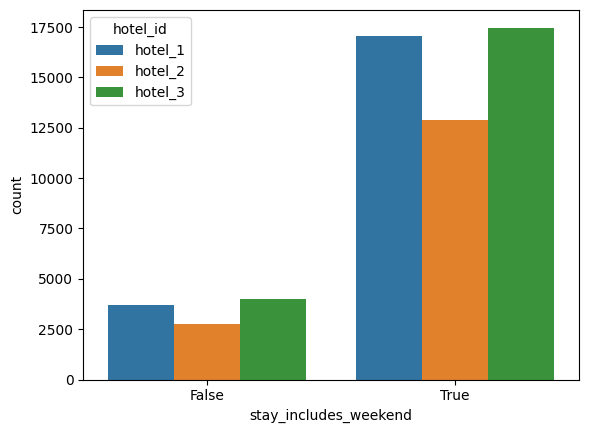

In [162]:
sns.countplot(data=df, x='stay_includes_weekend', hue='hotel_id')

<Axes: xlabel='days_of_week_in_stay'>

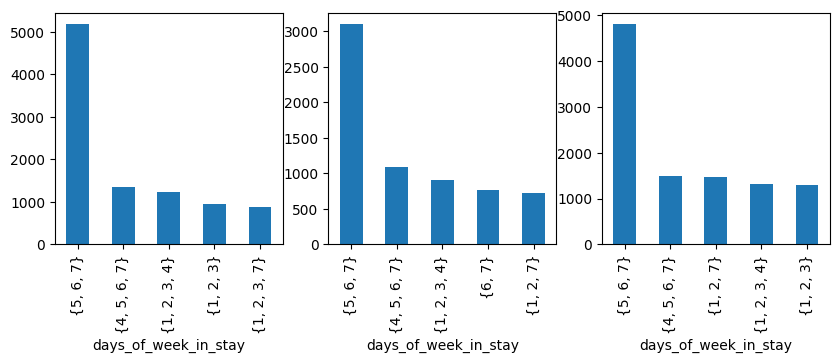

In [163]:
# most common weekday combinations
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(10,3))
hotel1['days_of_week_in_stay'].value_counts()[:5].plot(kind='bar', ax=ax1)
hotel2['days_of_week_in_stay'].value_counts()[:5].plot(kind='bar', ax=ax2)
hotel3['days_of_week_in_stay'].value_counts()[:5].plot(kind='bar', ax=ax3)

<Axes: xlabel='days_of_week_in_stay'>

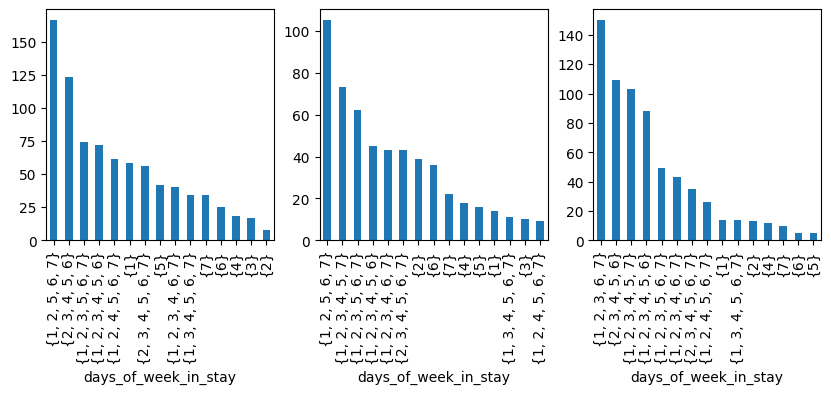

In [164]:
# most uncommon weekday combinations
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(10,3))
hotel1['days_of_week_in_stay'].value_counts()[-15:].plot(kind='bar', ax=ax1)
hotel2['days_of_week_in_stay'].value_counts()[-15:].plot(kind='bar', ax=ax2)
hotel3['days_of_week_in_stay'].value_counts()[-15:].plot(kind='bar', ax=ax3)

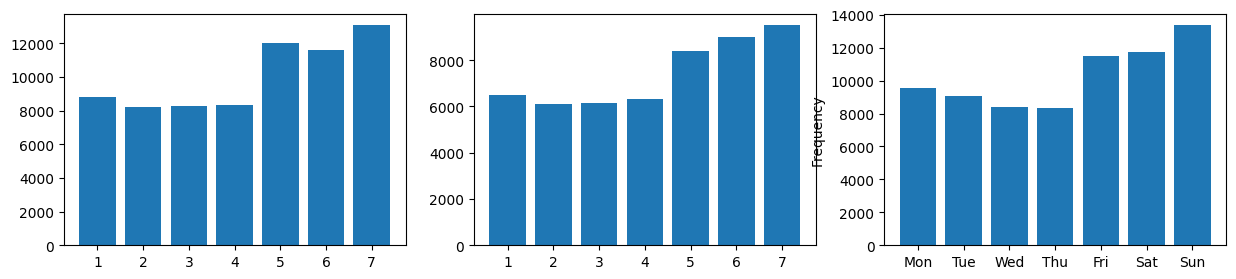

In [165]:
# which days are less popular?
from collections import Counter
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,3))
day_counts_h1 = Counter(day for days in hotel1[hotel1['conversion']==0]['days_of_week_in_stay'] for day in days)
day_counts_h2 = Counter(day for days in hotel2[hotel2['conversion']==0]['days_of_week_in_stay'] for day in days)
day_counts_h3 = Counter(day for days in hotel3[hotel3['conversion']==0]['days_of_week_in_stay'] for day in days)
ax1.bar(day_counts_h1.keys(), day_counts_h1.values())
ax2.bar(day_counts_h2.keys(), day_counts_h2.values())
ax3.bar(day_counts_h3.keys(), day_counts_h3.values())
plt.xticks(range(1, 8), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.ylabel("Frequency")
plt.show()

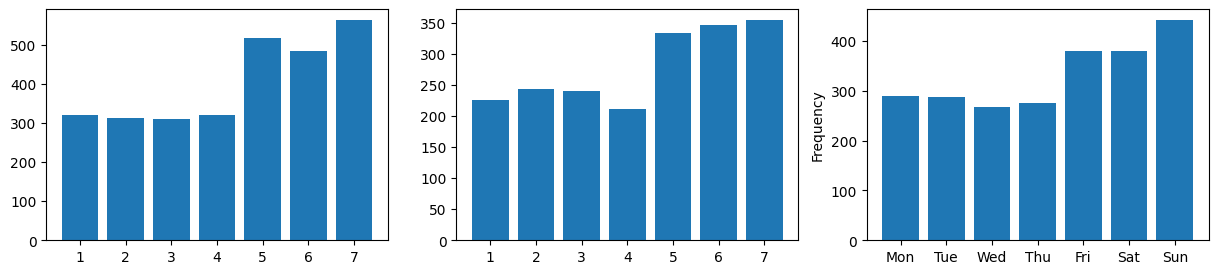

In [166]:
# which days are less popular?
from collections import Counter
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,3))
day_counts_h1 = Counter(day for days in hotel1[hotel1['conversion']==1]['days_of_week_in_stay'] for day in days)
day_counts_h2 = Counter(day for days in hotel2[hotel2['conversion']==1]['days_of_week_in_stay'] for day in days)
day_counts_h3 = Counter(day for days in hotel3[hotel3['conversion']==1]['days_of_week_in_stay'] for day in days)
ax1.bar(day_counts_h1.keys(), day_counts_h1.values())
ax2.bar(day_counts_h2.keys(), day_counts_h2.values())
ax3.bar(day_counts_h3.keys(), day_counts_h3.values())
plt.xticks(range(1, 8), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.ylabel("Frequency")
plt.show()

In [167]:
df[['arrival_is_holiday', 'hotel_id','uuid']].groupby(by=['hotel_id','arrival_is_holiday']).count().style.format('{0:,.2f}').bar(color='#d65f5f')

In [168]:
df[['departure_is_holiday', 'hotel_id','uuid']].groupby(by=['hotel_id','departure_is_holiday']).count().style.format('{0:,.2f}').bar(color='#d65f5f')

In [169]:
df[['stay_includes_weekend', 'hotel_id','total_price_p_night','upsell_total_price']].groupby(by=['hotel_id','stay_includes_weekend']).mean().style.format('{0:,.2f}').bar(color='#d65f5f')

In [170]:
df.columns

Index(['search_log_session_id', 'search_log_id', 'session_id',
       'search_log_room_id', 'uuid', 'utc_datetime', 'utm_source',
       'utm_medium', 'utm_campaign', 'lang_code', 'currency', 'arrival',
       'departure', 'nights', 'adults', 'children', 'if_children',
       'children_age_mean', 'conversion', 'sel_num_of_rooms',
       'mean_room_price', 'total_price_p_night', 'picked_room', 'baby_bed',
       'pieces', 'sum_price', 'total_price_final', 'rooms_total_price',
       'upsell_total_price', 'vouchers_total_price', 'loyalty_discount_total',
       'redeemed_loyalty_points_total', 'hotel_id', 'rfm_monetary_score',
       'rfm_duration_score', '0_age', '1_age', '2_age', '3_age', '4_age',
       'ROOMAA_room_price_min', 'offered_price_median', 'offered_price_min',
       'offered_price_max', 'ROOMAA_room_price_max', 'ROOMBB_room_price_min',
       'ROOMBB_room_price_max', 'ROOMCC_room_price_min',
       'ROOMCC_room_price_max', 'ROOMDD_room_price_min',
       'ROOMDD_room_pric

In [171]:
df[['num_saturdays', 'hotel_id','num_sundays']].groupby(by=['hotel_id']).mean().style.format('{0:,.2f}').bar(color='#d65f5f')

In [172]:
search_and_conversion1 = hotel1[['arrival','uuid','conversion', 'total_price_p_night','offered_price_median','offered_price_min','offered_price_max']].groupby(by='arrival').agg({'uuid':'count', 'conversion':'mean', 'total_price_p_night':'mean', 'offered_price_median':'mean', 'offered_price_min':'mean', 'offered_price_max':'mean'}).reset_index()
search_and_conversion2 = hotel2[['arrival','uuid','conversion', 'total_price_p_night','offered_price_median','offered_price_min','offered_price_max']].groupby(by='arrival').agg({'uuid':'count', 'conversion':'mean', 'total_price_p_night':'mean', 'offered_price_median':'mean', 'offered_price_min':'mean', 'offered_price_max':'mean'}).reset_index()
search_and_conversion3 = hotel3[['arrival','uuid','conversion', 'total_price_p_night','offered_price_median','offered_price_min','offered_price_max']].groupby(by='arrival').agg({'uuid':'count', 'conversion':'mean', 'total_price_p_night':'mean', 'offered_price_median':'mean', 'offered_price_min':'mean', 'offered_price_max':'mean'}).reset_index()

NameError: name 'occupancy_hotel_1' is not defined

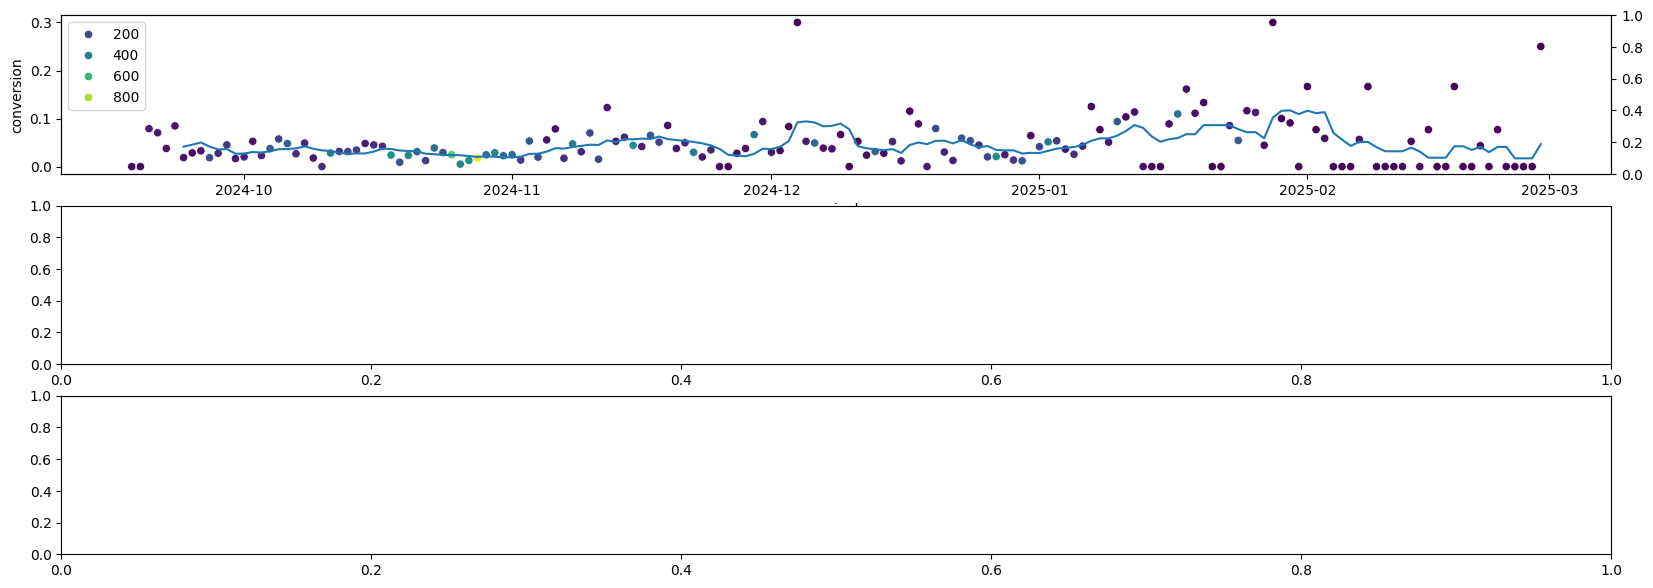

In [173]:
# what factors influences the conversion rate?
# what are the most searched time periods?

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(20,7))

sns.scatterplot(ax=ax1,
    data=search_and_conversion1[search_and_conversion1['arrival']<'2025-03-01'], 
    x='arrival',
    y='conversion', hue='uuid' ,palette='viridis')
sns.lineplot(ax=ax1,
    data=search_and_conversion1[search_and_conversion1['arrival']<'2025-03-01'], 
    x='arrival',
    y=search_and_conversion1[search_and_conversion1['arrival']<'2025-03-01']['conversion'].rolling(7).mean())
ax11 = ax1.twinx()
sns.scatterplot(ax=ax11, data=occupancy_hotel_1[occupancy_hotel_1['subject_date']<'2025-03-01'], x='subject_date', y='fill_rate', color='red')

sns.scatterplot(ax=ax2,
    data=search_and_conversion2[search_and_conversion2['arrival']<'2025-03-01'], 
    x='arrival',
    y='conversion', hue='uuid' ,palette='viridis')
sns.lineplot(ax=ax2,
    data=search_and_conversion2[search_and_conversion2['arrival']<'2025-03-01'], 
    x='arrival',
    y=search_and_conversion2[search_and_conversion2['arrival']<'2025-03-01']['conversion'].rolling(7).mean())
ax21 = ax2.twinx()
sns.scatterplot(ax=ax21, data=occupancy_hotel_2[occupancy_hotel_2['subject_date']<'2025-03-01'], x='subject_date', y='fill_rate', color='red')

sns.scatterplot(ax=ax3,
    data=search_and_conversion3[search_and_conversion3['arrival']<'2025-03-01'], 
    x='arrival',
    y='conversion', hue='uuid' ,palette='viridis')
sns.lineplot(ax=ax3,
    data=search_and_conversion3[search_and_conversion3['arrival']<'2025-03-01'], 
    x='arrival',
    y=search_and_conversion3[search_and_conversion3['arrival']<'2025-03-01']['conversion'].rolling(7).mean())
ax31 = ax3.twinx()
sns.scatterplot(ax=ax31, data=occupancy_hotel_3[occupancy_hotel_3['subject_date']<'2025-03-01'], x='subject_date', y='fill_rate', color='red')

# Highlight weekends
start_date = pd.to_datetime('2024-09-15')  # Adjust based on your data range
end_date = pd.to_datetime('2025-03-01')
current_date = start_date

while current_date <= end_date:
    if current_date.weekday() >= 5:  # Saturday (5) and Sunday (6)
        ax1.axvspan(current_date, current_date + timedelta(days=1), color='lightgrey', alpha=0.5, label='Weekend' if current_date == start_date else None)
        ax2.axvspan(current_date, current_date + timedelta(days=1), color='lightgrey', alpha=0.5, label='Weekend' if current_date == start_date else None)
        ax3.axvspan(current_date, current_date + timedelta(days=1), color='lightgrey', alpha=0.5, label='Weekend' if current_date == start_date else None)
    current_date += timedelta(days=1)

# Highlight public holidays
for holiday in public_holidays:
    if start_date <= holiday <= end_date:
        ax1.axvspan(holiday, holiday + timedelta(days=1), color='lightcoral', alpha=0.5, label='Public Holiday' if holiday == public_holidays[0] else None)
        ax2.axvspan(holiday, holiday + timedelta(days=1), color='lightcoral', alpha=0.5, label='Public Holiday' if holiday == public_holidays[0] else None)
        ax3.axvspan(holiday, holiday + timedelta(days=1), color='lightcoral', alpha=0.5, label='Public Holiday' if holiday == public_holidays[0] else None)

In [ ]:
search_and_conversion1_unique = hotel1_unique[['arrival','uuid','conversion', 'total_price_p_night','offered_price_median','offered_price_min','offered_price_max']].groupby(by='arrival').agg({'uuid':'count', 'conversion':'mean', 'total_price_p_night':'mean', 'offered_price_median':'mean', 'offered_price_min':'mean', 'offered_price_max':'mean'}).reset_index()
search_and_conversion2_unique = hotel2_unique[['arrival','uuid','conversion', 'total_price_p_night','offered_price_median','offered_price_min','offered_price_max']].groupby(by='arrival').agg({'uuid':'count', 'conversion':'mean', 'total_price_p_night':'mean', 'offered_price_median':'mean', 'offered_price_min':'mean', 'offered_price_max':'mean'}).reset_index()
search_and_conversion3_unique = hotel3_unique[['arrival','uuid','conversion', 'total_price_p_night','offered_price_median','offered_price_min','offered_price_max']].groupby(by='arrival').agg({'uuid':'count', 'conversion':'mean', 'total_price_p_night':'mean', 'offered_price_median':'mean', 'offered_price_min':'mean', 'offered_price_max':'mean'}).reset_index()

In [174]:
# read occupancy data
occupancy = pd.read_csv('./../data-workfile/daily_occupancy.csv', index_col='Unnamed: 0')

In [175]:
occupancy[occupancy['hotel_id']=='hotel_1']

recording_date subject_date  fill_rate hotel_id  days_until_stay  \
0         2024-09-18   2024-09-18     67.368  hotel_1                0   
1         2024-09-18   2024-09-19     65.789  hotel_1                1   
2         2024-09-18   2024-09-20     67.895  hotel_1                2   
3         2024-09-18   2024-09-21     59.474  hotel_1                3   
4         2024-09-18   2024-09-22     43.684  hotel_1                4   
...              ...          ...        ...      ...              ...   
10783     2024-10-18   2025-08-27      0.526  hotel_1              313   
10784     2024-10-18   2025-08-28      0.526  hotel_1              314   
10785     2024-10-18   2025-08-29      0.526  hotel_1              315   
10786     2024-10-18   2025-08-30      0.526  hotel_1              316   
10787     2024-10-18   2025-08-31      0.526  hotel_1              317   

       stay_day_of_week  subject_day_of_week  subject_is_weekend  
0                     2                    2                   0  
1                     3                    3                   0  
2                     4                    4                   0  
3                     5                    5                   1  
4                     6                    6                   1  
...                 ...                  ...                 ...  
10783                 2                    2                   0  
10784                 3                    3                   0  
10785                 4                    4                   0  
10786                 5                    5                   1  
10787                 6                    6                   1  

[10788 rows x 8 columns]

<Axes: >

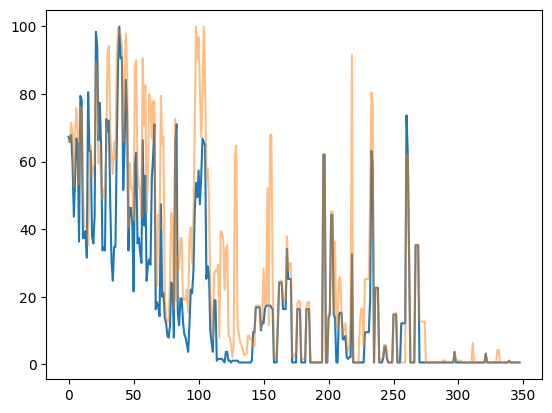

In [176]:
occupancy[(occupancy['hotel_id']=='hotel_1') & (occupancy['recording_date']=='2024-09-18')]['fill_rate'].plot()
occupancy[(occupancy['hotel_id']=='hotel_1') & (occupancy['recording_date']=='2024-10-18')]['fill_rate'].reset_index(drop=True).plot(alpha=0.5)

In [177]:
# mean occupancy for the subject date:

occupancy_hotel_1 = occupancy[occupancy['hotel_id']=='hotel_1'][['subject_date','fill_rate','days_until_stay']].groupby(by='subject_date').mean().reset_index().join(
    hotel1_unique[['lead_time','conversion']].groupby(by='lead_time').mean(), on='days_until_stay', how='inner')
occupancy_hotel_2 = occupancy[occupancy['hotel_id']=='hotel_2'][['subject_date','fill_rate','days_until_stay']].groupby(by='subject_date').mean().reset_index().join(
    hotel2_unique[['lead_time','conversion']].groupby(by='lead_time').mean(), on='days_until_stay', how='inner')
occupancy_hotel_3 = occupancy[occupancy['hotel_id']=='hotel_3'][['subject_date','fill_rate','days_until_stay']].groupby(by='subject_date').mean().reset_index().join(
    hotel3_unique[['lead_time','conversion']].groupby(by='lead_time').mean(), on='days_until_stay', how='inner')

In [178]:
occupancy_hotel_1['subject_date'] = pd.to_datetime(occupancy_hotel_1['subject_date'])
occupancy_hotel_2['subject_date'] = pd.to_datetime(occupancy_hotel_2['subject_date'])
occupancy_hotel_3['subject_date'] = pd.to_datetime(occupancy_hotel_3['subject_date'])

NameError: name 'search_and_conversion1_unique' is not defined

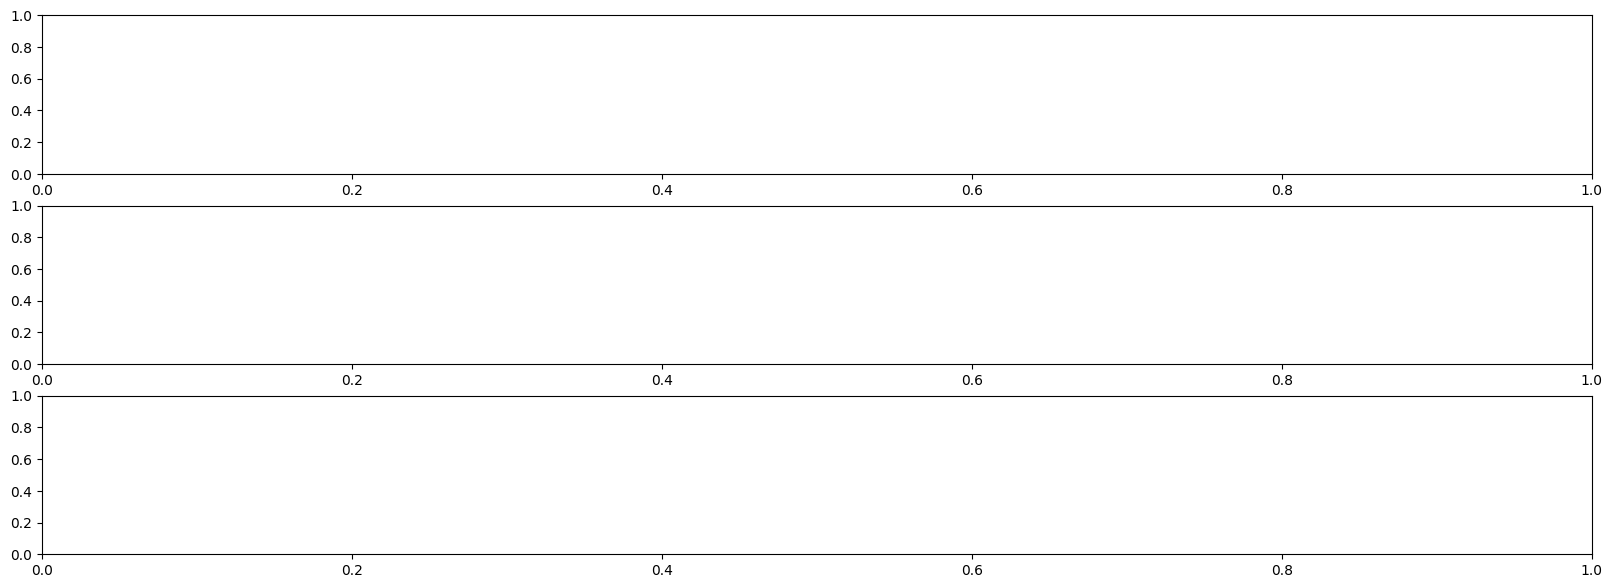

In [179]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(20,7))

sns.scatterplot(ax=ax1,
    data=search_and_conversion1_unique[search_and_conversion1_unique['arrival']<'2025-03-01'], 
    x='arrival',
    y='conversion', hue='uuid' ,palette='viridis')
sns.lineplot(ax=ax1,
    data=search_and_conversion1_unique[search_and_conversion1_unique['arrival']<'2025-03-01'], 
    x='arrival',
    y=search_and_conversion1_unique[search_and_conversion1_unique['arrival']<'2025-03-01']['conversion'].rolling(7).mean())
ax11 = ax1.twinx()
sns.scatterplot(ax=ax11, data=occupancy_hotel_1[occupancy_hotel_1['subject_date']<'2025-03-01'], x='subject_date', y='fill_rate', color='red')

sns.scatterplot(ax=ax2,
    data=search_and_conversion2_unique[search_and_conversion2_unique['arrival']<'2025-03-01'], 
    x='arrival',
    y='conversion', hue='uuid' ,palette='viridis')
sns.lineplot(ax=ax2,
    data=search_and_conversion2_unique[search_and_conversion2_unique['arrival']<'2025-03-01'], 
    x='arrival',
    y=search_and_conversion2_unique[search_and_conversion2_unique['arrival']<'2025-03-01']['conversion'].rolling(7).mean())
ax21 = ax2.twinx()
sns.scatterplot(ax=ax21, data=occupancy_hotel_2[occupancy_hotel_2['subject_date']<'2025-03-01'], x='subject_date', y='fill_rate', color='red')

sns.scatterplot(ax=ax3,
    data=search_and_conversion3_unique[search_and_conversion3_unique['arrival']<'2025-03-01'], 
    x='arrival',
    y='conversion', hue='uuid' ,palette='viridis')
sns.lineplot(ax=ax3,
    data=search_and_conversion3_unique[search_and_conversion3_unique['arrival']<'2025-03-01'], 
    x='arrival',
    y=search_and_conversion3_unique[search_and_conversion3_unique['arrival']<'2025-03-01']['conversion'].rolling(7).mean())
ax31 = ax3.twinx()
sns.scatterplot(ax=ax31, data=occupancy_hotel_3[occupancy_hotel_3['subject_date']<'2025-03-01'], x='subject_date', y='fill_rate', color='red')

# Highlight weekends
start_date = pd.to_datetime('2024-09-15')  # Adjust based on your data range
end_date = pd.to_datetime('2025-03-01')
current_date = start_date

while current_date <= end_date:
    if current_date.weekday() >= 5:  # Saturday (5) and Sunday (6)
        ax1.axvspan(current_date, current_date + timedelta(days=1), color='lightgrey', alpha=0.5, label='Weekend' if current_date == start_date else None)
        ax2.axvspan(current_date, current_date + timedelta(days=1), color='lightgrey', alpha=0.5, label='Weekend' if current_date == start_date else None)
        ax3.axvspan(current_date, current_date + timedelta(days=1), color='lightgrey', alpha=0.5, label='Weekend' if current_date == start_date else None)
    current_date += timedelta(days=1)

# Highlight public holidays
for holiday in public_holidays:
    if start_date <= holiday <= end_date:
        ax1.axvspan(holiday, holiday + timedelta(days=1), color='lightcoral', alpha=0.5, label='Public Holiday' if holiday == public_holidays[0] else None)
        ax2.axvspan(holiday, holiday + timedelta(days=1), color='lightcoral', alpha=0.5, label='Public Holiday' if holiday == public_holidays[0] else None)
        ax3.axvspan(holiday, holiday + timedelta(days=1), color='lightcoral', alpha=0.5, label='Public Holiday' if holiday == public_holidays[0] else None)

<Axes: xlabel='conversion', ylabel='offered_price_median'>

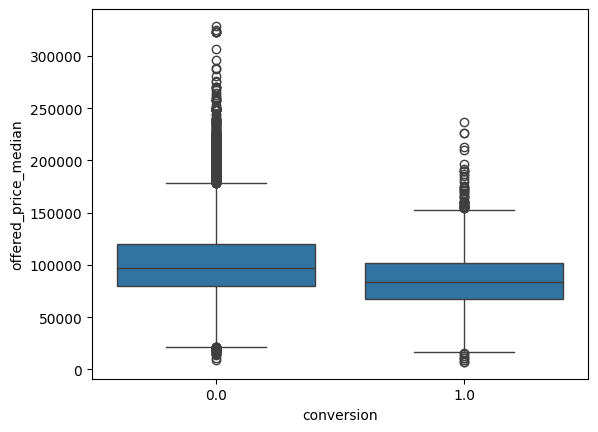

In [ ]:
sns.boxplot(y=df_unique['offered_price_median'], x=df_unique['conversion'])

In [ ]:
# why the conversion is lower in certain days?

<Axes: xlabel='fill_rate', ylabel='conversion'>

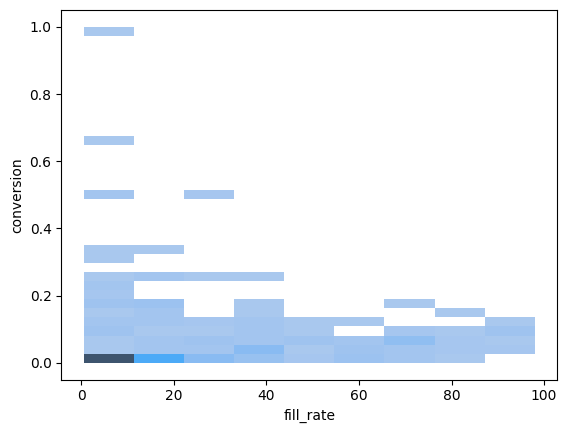

In [ ]:
sns.histplot(data=occupancy_hotel_1, x='fill_rate', y='conversion')

In [180]:
occupancy_hotel_1#_hotel_1[(occupancy_hotel_1['fill_rate']<20) & (occupancy_hotel_1['conversion']<0.05)]

subject_date  fill_rate  days_until_stay  conversion
14    2024-10-02  39.049290             -1.0    0.008065
15    2024-10-03  35.415968              0.0    0.110294
16    2024-10-04  54.125452              1.0    0.086667
17    2024-10-05  58.472032              2.0    0.076923
18    2024-10-06  50.933710              3.0    0.025862
..           ...        ...              ...         ...
318   2025-08-02   0.526000            303.0    0.000000
325   2025-08-09   0.526000            310.0    0.000000
327   2025-08-11   0.526000            312.0    0.000000
337   2025-08-21   0.526000            322.0    0.000000
343   2025-08-27   0.526000            328.0    0.000000

[254 rows x 4 columns]

<Axes: xlabel='subject_date', ylabel='conversion'>

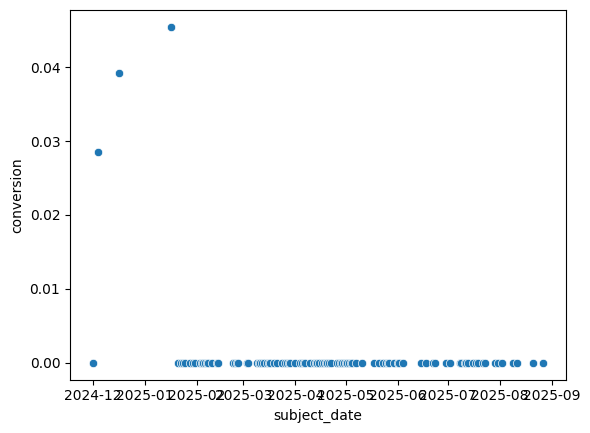

In [181]:
sns.scatterplot(
    data=occupancy_hotel_1[(occupancy_hotel_1['fill_rate']<20) & (occupancy_hotel_1['conversion']<0.05)], 
    x='subject_date',
    y='conversion')

<Axes: xlabel='fill_rate', ylabel='conversion'>

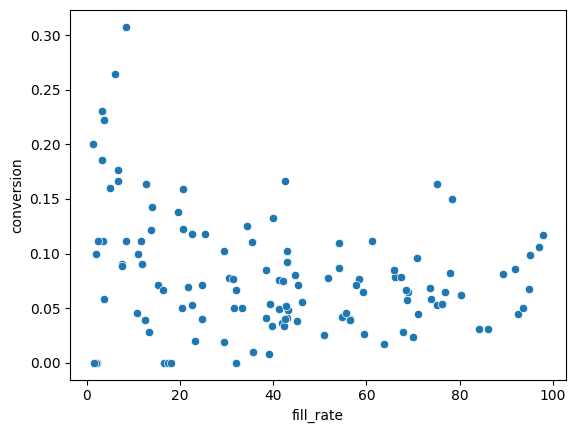

In [182]:
sns.scatterplot(data=occupancy_hotel_1[occupancy_hotel_1['subject_date']<'2025-02-01'], x='fill_rate', y='conversion')

In [183]:
bad_days_hotel1 = occupancy_hotel_1[(occupancy_hotel_1['fill_rate']<50) & (occupancy_hotel_1['conversion']<0.075)]['subject_date']

In [184]:
bad_days_set = set(bad_days_hotel1)  # Convert to a set for fast lookup
hotel1['is_bad_day'] = hotel1['arrival'].apply(lambda x: x in bad_days_set)

<Axes: xlabel='is_bad_day', ylabel='total_price_p_night'>

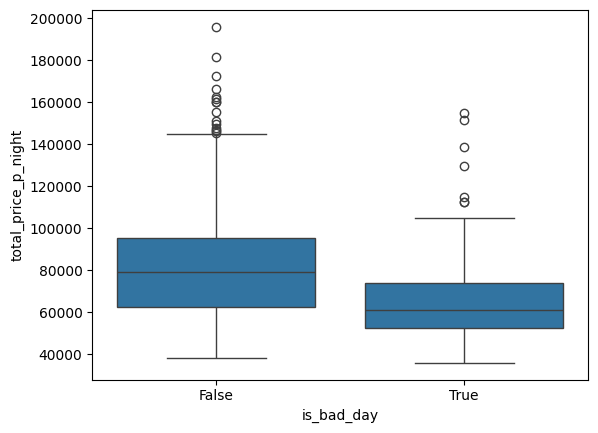

In [185]:
sns.boxplot(data=hotel1[['is_bad_day','total_price_p_night']], x='is_bad_day', y='total_price_p_night')

In [186]:
hotel1[['is_bad_day','offered_price_median', 'offered_price_min','offered_price_max','arrival_day_of_week','arrival_is_holiday','departure_is_holiday','stay_includes_weekend']].groupby(by='is_bad_day').mean()

offered_price_median  offered_price_min  offered_price_max  \
is_bad_day                                                               
False               97963.920871       82666.571025      117671.907539   
True                84919.806025       67310.574618      107216.108852   

            arrival_day_of_week  arrival_is_holiday  departure_is_holiday  \
is_bad_day                                                                  
False                  4.365719            0.369198              0.544738   
True                   4.071687            0.278801              0.514987   

            stay_includes_weekend  
is_bad_day                         
False                    0.829777  
True                     0.801372

<Axes: xlabel='arrival_day_of_week', ylabel='Density'>

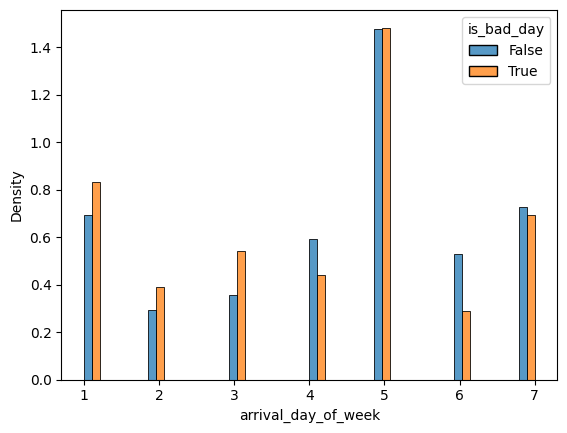

In [187]:
sns.histplot(data=hotel1, x='arrival_day_of_week', hue='is_bad_day', multiple="dodge", stat = 'density', common_norm=False)

<Axes: xlabel='fill_rate', ylabel='conversion'>

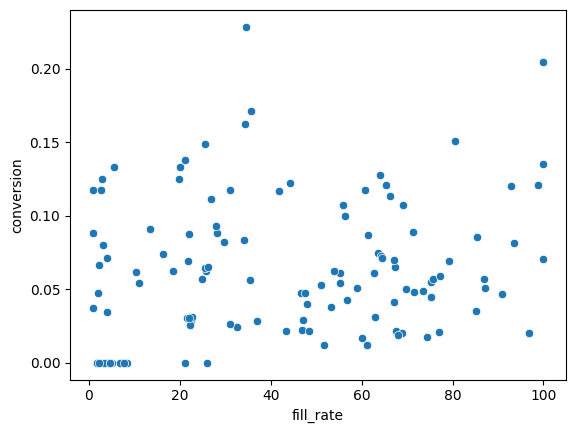

In [188]:
sns.scatterplot(data=occupancy_hotel_2[occupancy_hotel_2['subject_date']<'2025-02-01'], x='fill_rate', y='conversion')

In [189]:
bad_days_hotel2 = occupancy_hotel_2[(occupancy_hotel_2['fill_rate']<30) & (occupancy_hotel_2['conversion']<0.05)]['subject_date']

In [190]:
bad_days_set = set(bad_days_hotel2)  # Convert to a set for fast lookup
hotel2['is_bad_day'] = hotel2['arrival'].apply(lambda x: x in bad_days_set)

In [191]:
hotel2[['is_bad_day','offered_price_median', 'offered_price_min','offered_price_max','arrival_day_of_week','arrival_is_holiday','departure_is_holiday','stay_includes_weekend']].groupby(by='is_bad_day').mean()

offered_price_median  offered_price_min  offered_price_max  \
is_bad_day                                                               
False               92618.933368       76854.799929      111512.079989   
True                74567.422756       55303.257848       98686.571405   

            arrival_day_of_week  arrival_is_holiday  departure_is_holiday  \
is_bad_day                                                                  
False                  4.299363            0.389920              0.537247   
True                   4.309216            0.366064              0.382429   

            stay_includes_weekend  
is_bad_day                         
False                    0.833287  
True                     0.715762

<Axes: xlabel='arrival_day_of_week', ylabel='Density'>

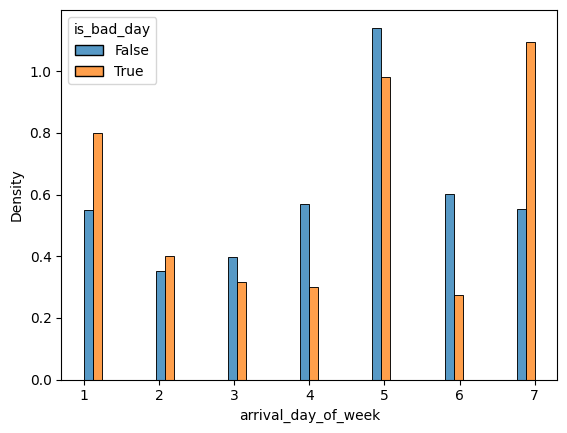

In [192]:
sns.histplot(data=hotel2, x='arrival_day_of_week', hue='is_bad_day', multiple="dodge", stat = 'density', common_norm=False)

<Axes: xlabel='fill_rate', ylabel='conversion'>

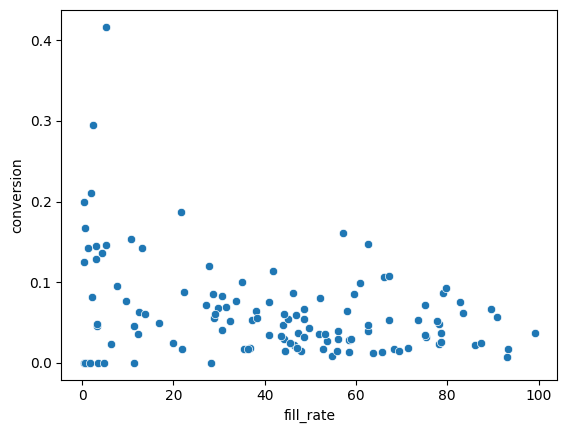

In [193]:
sns.scatterplot(data=occupancy_hotel_3[occupancy_hotel_3['subject_date']<'2025-02-01'], x='fill_rate', y='conversion')

In [194]:
bad_days_hotel3 = occupancy_hotel_3[(occupancy_hotel_3['fill_rate']<30) & (occupancy_hotel_3['conversion']<0.05)]['subject_date']

In [195]:
bad_days_set = set(bad_days_hotel3)  # Convert to a set for fast lookup
hotel3['is_bad_day'] = hotel3['arrival'].apply(lambda x: x in bad_days_set)

In [196]:
hotel3[['is_bad_day','offered_price_median', 'offered_price_min','offered_price_max','arrival_day_of_week','arrival_is_holiday','departure_is_holiday','stay_includes_weekend']].groupby(by='is_bad_day').mean()

offered_price_median  offered_price_min  offered_price_max  \
is_bad_day                                                               
False              105345.350806       80968.306871       137394.58797   
True                91774.059720       69594.515741       123533.64365   

            arrival_day_of_week  arrival_is_holiday  departure_is_holiday  \
is_bad_day                                                                  
False                  4.290227            0.361219              0.504819   
True                   4.479856            0.380637              0.610944   

            stay_includes_weekend  
is_bad_day                         
False                    0.807155  
True                     0.886951

<Axes: xlabel='arrival_day_of_week', ylabel='Density'>

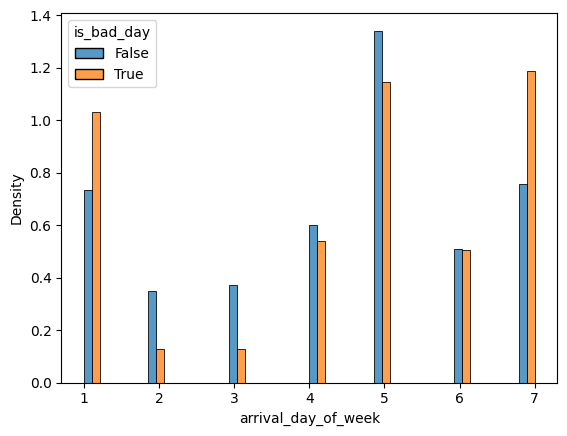

In [197]:
sns.histplot(data=hotel3, x='arrival_day_of_week', hue='is_bad_day', multiple="dodge", stat = 'density', common_norm=False)

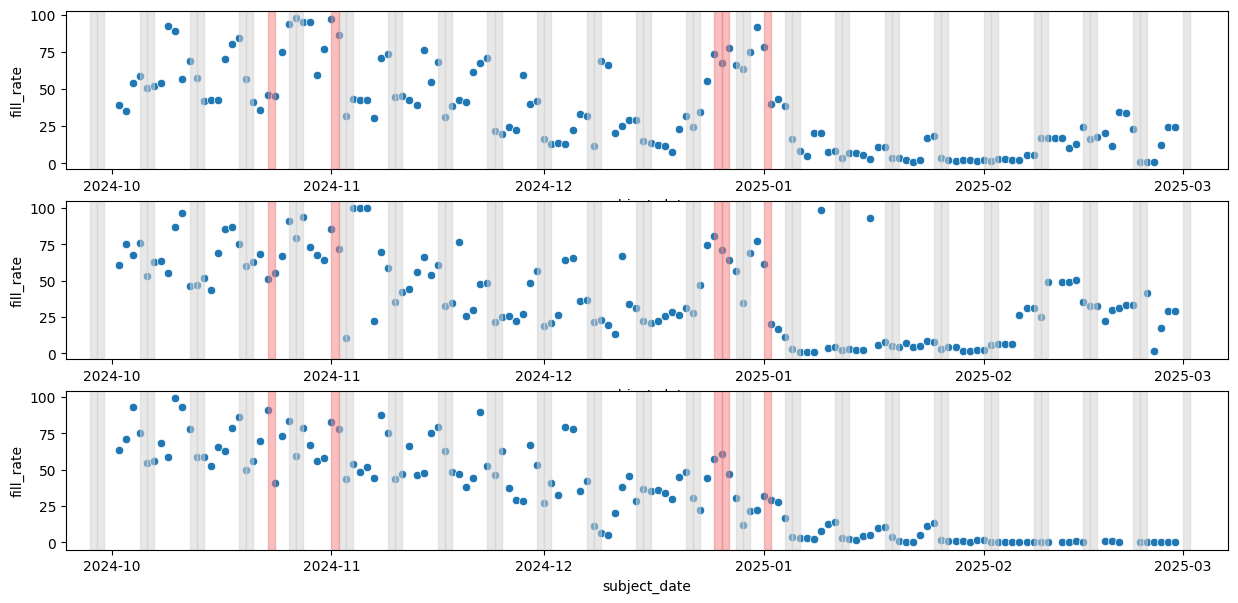

In [198]:

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(15,7))

sns.scatterplot(ax=ax1, data=occupancy_hotel_1[occupancy_hotel_1['subject_date']<'2025-03-01'], x='subject_date', y='fill_rate')
sns.scatterplot(ax=ax2, data=occupancy_hotel_2[occupancy_hotel_2['subject_date']<'2025-03-01'], x='subject_date', y='fill_rate')
sns.scatterplot(ax=ax3, data=occupancy_hotel_3[occupancy_hotel_3['subject_date']<'2025-03-01'], x='subject_date', y='fill_rate')

# highlight weekends
start_date = pd.to_datetime('2024-09-15')  # Adjust based on your data range
end_date = pd.to_datetime('2025-03-01')
current_date = start_date

while current_date <= end_date:
    if current_date.weekday() >= 5:  # Saturday (5) and Sunday (6)
        ax1.axvspan(current_date, current_date + timedelta(days=1), color='lightgrey', alpha=0.5, label='Weekend' if current_date == start_date else None)
        ax2.axvspan(current_date, current_date + timedelta(days=1), color='lightgrey', alpha=0.5, label='Weekend' if current_date == start_date else None)
        ax3.axvspan(current_date, current_date + timedelta(days=1), color='lightgrey', alpha=0.5, label='Weekend' if current_date == start_date else None)
    current_date += timedelta(days=1)

# highlight public holidays
for holiday in public_holidays:
    if start_date <= holiday <= end_date:
        ax1.axvspan(holiday, holiday + timedelta(days=1), color='lightcoral', alpha=0.5, label='Public Holiday' if holiday == public_holidays[0] else None)
        ax2.axvspan(holiday, holiday + timedelta(days=1), color='lightcoral', alpha=0.5, label='Public Holiday' if holiday == public_holidays[0] else None)
        ax3.axvspan(holiday, holiday + timedelta(days=1), color='lightcoral', alpha=0.5, label='Public Holiday' if holiday == public_holidays[0] else None)

In [199]:
# comparison with the occupancy data

<Axes: xlabel='days_until_stay', ylabel='conversion'>

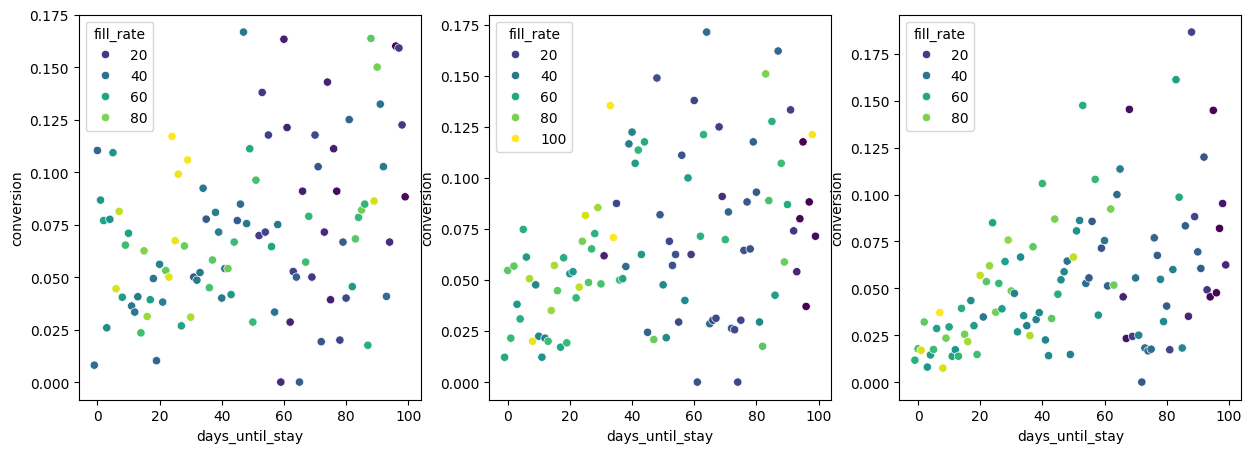

In [200]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
sns.scatterplot(ax=ax1, data=occupancy_hotel_1[(occupancy_hotel_1['conversion']<0.2) & (occupancy_hotel_1['days_until_stay']<100)], x='days_until_stay', y='conversion', hue='fill_rate', palette='viridis')
sns.scatterplot(ax=ax2, data=occupancy_hotel_2[(occupancy_hotel_2['conversion']<0.2) & (occupancy_hotel_2['days_until_stay']<100)], x='days_until_stay', y='conversion', hue='fill_rate', palette='viridis')
sns.scatterplot(ax=ax3, data=occupancy_hotel_3[(occupancy_hotel_3['conversion']<0.2) & (occupancy_hotel_3['days_until_stay']<100)], x='days_until_stay', y='conversion', hue='fill_rate', palette='viridis')

In [201]:
##### kovetkeztetes: lead time novekedesevel a konverzio es szabad helyek szama is novekszik, nem tudni ok-okozatot????

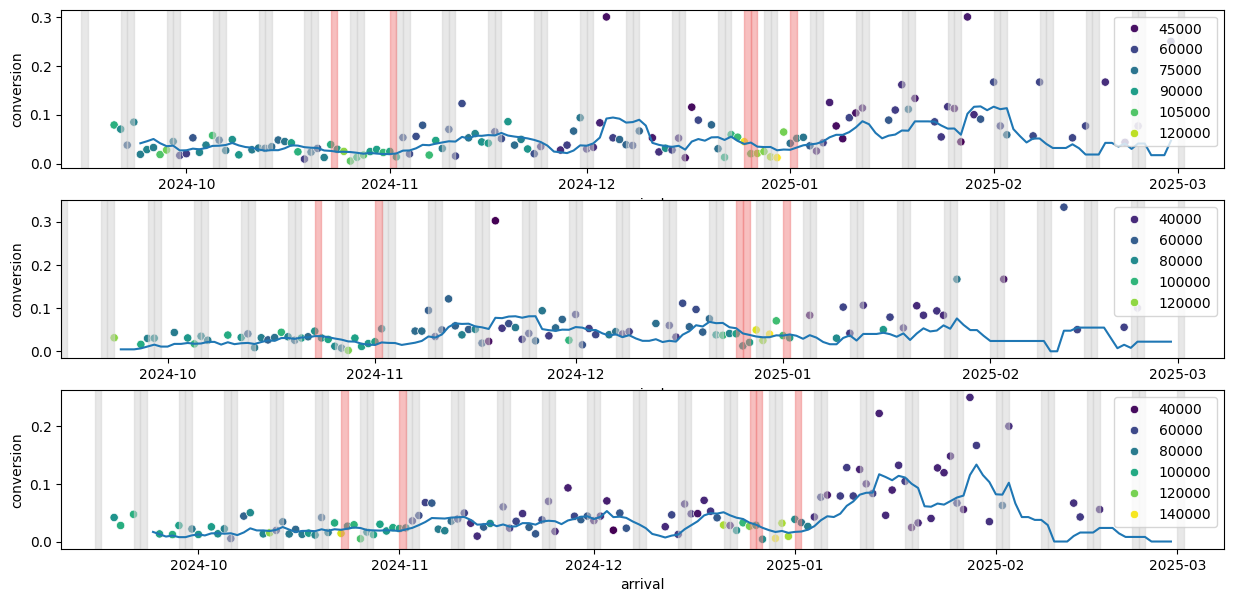

In [202]:
# total_price_p_night and conversion
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(15,7))

sns.scatterplot(ax=ax1,
    data=search_and_conversion1[search_and_conversion1['arrival']<'2025-03-01'], 
    x='arrival',
    y='conversion', hue='total_price_p_night' ,palette='viridis')
sns.lineplot(ax=ax1,
    data=search_and_conversion1[search_and_conversion1['arrival']<'2025-03-01'], 
    x='arrival',
    y=search_and_conversion1[search_and_conversion1['arrival']<'2025-03-01']['conversion'].rolling(7).mean())

sns.scatterplot(ax=ax2,
    data=search_and_conversion2[search_and_conversion2['arrival']<'2025-03-01'], 
    x='arrival',
    y='conversion', hue='total_price_p_night' ,palette='viridis')
sns.lineplot(ax=ax2,
    data=search_and_conversion2[search_and_conversion2['arrival']<'2025-03-01'], 
    x='arrival',
    y=search_and_conversion2[search_and_conversion2['arrival']<'2025-03-01']['conversion'].rolling(7).mean())

sns.scatterplot(ax=ax3,
    data=search_and_conversion3[search_and_conversion3['arrival']<'2025-03-01'], 
    x='arrival',
    y='conversion', hue='total_price_p_night' ,palette='viridis')
sns.lineplot(ax=ax3,
    data=search_and_conversion3[search_and_conversion3['arrival']<'2025-03-01'], 
    x='arrival',
    y=search_and_conversion3[search_and_conversion3['arrival']<'2025-03-01']['conversion'].rolling(7).mean())

# highlight weekends
start_date = pd.to_datetime('2024-09-15')  # Adjust based on your data range
end_date = pd.to_datetime('2025-03-01')
current_date = start_date

while current_date <= end_date:
    if current_date.weekday() >= 5:  # Saturday (5) and Sunday (6)
        ax1.axvspan(current_date, current_date + timedelta(days=1), color='lightgrey', alpha=0.5, label='Weekend' if current_date == start_date else None)
        ax2.axvspan(current_date, current_date + timedelta(days=1), color='lightgrey', alpha=0.5, label='Weekend' if current_date == start_date else None)
        ax3.axvspan(current_date, current_date + timedelta(days=1), color='lightgrey', alpha=0.5, label='Weekend' if current_date == start_date else None)
    current_date += timedelta(days=1)

# highlight public holidays
for holiday in public_holidays:
    if start_date <= holiday <= end_date:
        ax1.axvspan(holiday, holiday + timedelta(days=1), color='lightcoral', alpha=0.5, label='Public Holiday' if holiday == public_holidays[0] else None)
        ax2.axvspan(holiday, holiday + timedelta(days=1), color='lightcoral', alpha=0.5, label='Public Holiday' if holiday == public_holidays[0] else None)
        ax3.axvspan(holiday, holiday + timedelta(days=1), color='lightcoral', alpha=0.5, label='Public Holiday' if holiday == public_holidays[0] else None)

## Willingness to pay (WTP)

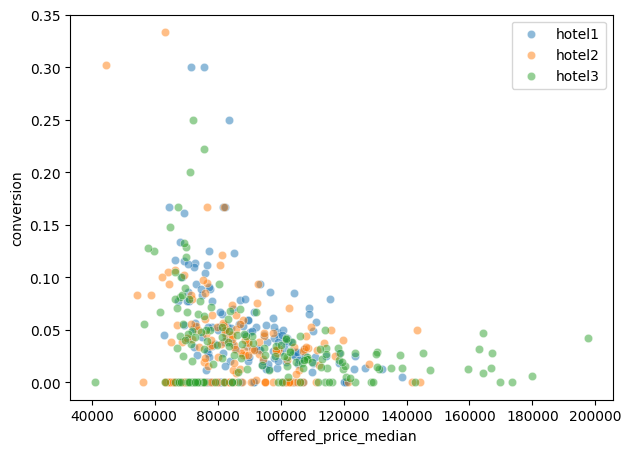

In [203]:
fig, (ax1) = plt.subplots(1,1, figsize=(7,5))
sns.scatterplot(ax=ax1, data=search_and_conversion1[search_and_conversion1['arrival']<'2025-03-01'], x='offered_price_median', y='conversion', label='hotel1', alpha=0.5)
sns.scatterplot(ax=ax1, data=search_and_conversion2[search_and_conversion2['arrival']<'2025-03-01'], x='offered_price_median', y='conversion', label='hotel2', alpha=0.5)
sns.scatterplot(ax=ax1, data=search_and_conversion3[search_and_conversion3['arrival']<'2025-03-01'], x='offered_price_median', y='conversion', label='hotel3', alpha=0.5)
plt.legend()

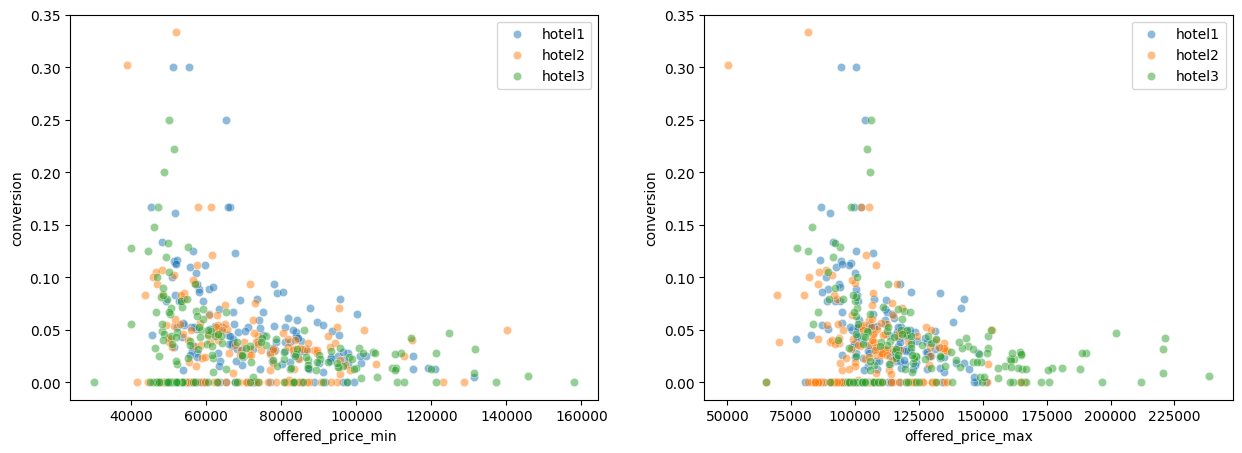

In [204]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
sns.scatterplot(ax=ax1, data=search_and_conversion1[search_and_conversion1['arrival']<'2025-03-01'], x='offered_price_min', y='conversion', label='hotel1', alpha=0.5)
sns.scatterplot(ax=ax1, data=search_and_conversion2[search_and_conversion2['arrival']<'2025-03-01'], x='offered_price_min', y='conversion', label='hotel2', alpha=0.5)
sns.scatterplot(ax=ax1, data=search_and_conversion3[search_and_conversion3['arrival']<'2025-03-01'], x='offered_price_min', y='conversion', label='hotel3', alpha=0.5)
plt.legend()


sns.scatterplot(ax=ax2, data=search_and_conversion1[search_and_conversion1['arrival']<'2025-03-01'], x='offered_price_max', y='conversion', label='hotel1', alpha=0.5)
sns.scatterplot(ax=ax2, data=search_and_conversion2[search_and_conversion2['arrival']<'2025-03-01'], x='offered_price_max', y='conversion', label='hotel2', alpha=0.5)
sns.scatterplot(ax=ax2, data=search_and_conversion3[search_and_conversion3['arrival']<'2025-03-01'], x='offered_price_max', y='conversion', label='hotel3', alpha=0.5)
plt.legend()

<Axes: xlabel='offered_price_median', ylabel='total_price_p_night'>

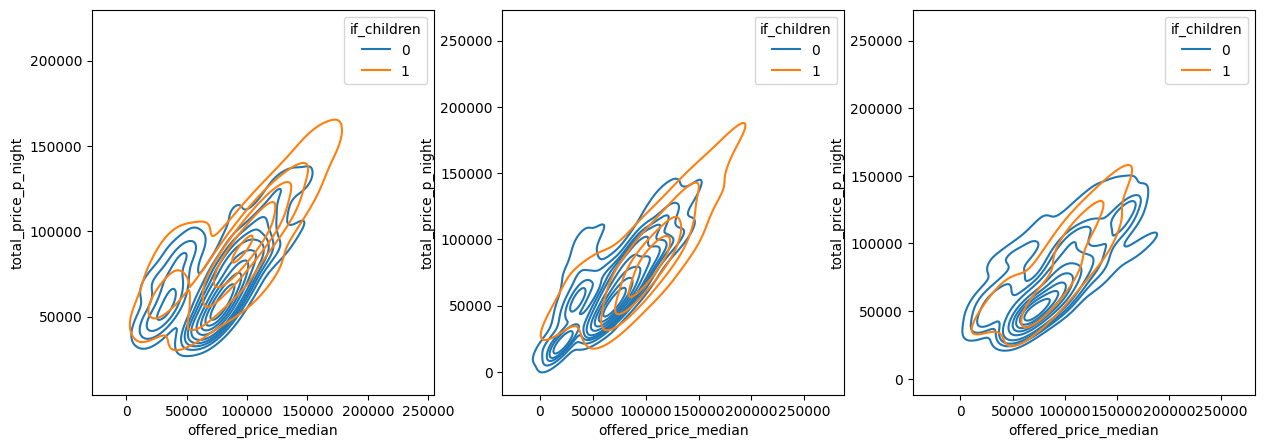

In [205]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
sns.kdeplot(ax=ax1, data=hotel1, x='offered_price_median', y='total_price_p_night', hue='if_children')
sns.kdeplot(ax=ax2, data=hotel2, x='offered_price_median', y='total_price_p_night', hue='if_children')
sns.kdeplot(ax=ax3, data=hotel3, x='offered_price_median', y='total_price_p_night', hue='if_children')

In [206]:
pd.concat([hotel1[hotel1['if_children']==0][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
hotel1[hotel1['if_children']==1][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'] ], axis=1)

# nagyon valószínű, hogy a legolcsóbb ajánlatot választják
# ha van gyerek akkor nő az esélye, hogy drágább szobát választnanak

total_price_p_night  total_price_p_night
offered_price_min                0.754306             0.859784
offered_price_median             0.696816             0.809843
offered_price_max                0.533806             0.721102
total_price_p_night              1.000000             1.000000

In [207]:
pd.concat([hotel2[hotel2['if_children']==0][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
hotel2[hotel2['if_children']==1][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'] ], axis=1)

total_price_p_night  total_price_p_night
offered_price_min                0.843524             0.921419
offered_price_median             0.802602             0.796035
offered_price_max                0.676277             0.457341
total_price_p_night              1.000000             1.000000

In [208]:
pd.concat([hotel3[hotel3['if_children']==0][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
hotel3[hotel3['if_children']==1][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'] ], axis=1)

total_price_p_night  total_price_p_night
offered_price_min                0.789204             0.891441
offered_price_median             0.727607             0.823170
offered_price_max                0.628050             0.545638
total_price_p_night              1.000000             1.000000

In [209]:
hotel3['utm_medium'].unique()

array(['(not set)', 'organic', 'cpc', 'referral', 'direct', 'ct', 'other',
       'offline', 'email'], dtype=object)

In [210]:
mediums_corr1 = pd.concat(
    [hotel1[hotel1['utm_medium']=='cpc'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['utm_medium']=='referral'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['utm_medium']=='direct'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['utm_medium']=='organic'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['utm_medium']=='ct'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['utm_medium']=='other'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['utm_medium']=='offline'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['utm_medium']=='email'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night']], axis=1).set_axis(['cpc', 'referral', 'direct', 'organic', 'ct', 'other', 'offline', 'email'], axis=1).drop(index='total_price_p_night')

mediums_corr2 = pd.concat(
    [hotel2[hotel2['utm_medium']=='cpc'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel2[hotel2['utm_medium']=='referral'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel2[hotel2['utm_medium']=='direct'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel2[hotel2['utm_medium']=='organic'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel2[hotel2['utm_medium']=='ct'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel2[hotel2['utm_medium']=='other'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel2[hotel2['utm_medium']=='offline'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel2[hotel2['utm_medium']=='email'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night']], axis=1).set_axis(['cpc', 'referral', 'direct', 'organic', 'ct', 'other', 'offline', 'email'], axis=1).drop(index='total_price_p_night')

mediums_corr3 = pd.concat(
    [hotel3[hotel3['utm_medium']=='cpc'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel3[hotel3['utm_medium']=='referral'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel3[hotel3['utm_medium']=='direct'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel3[hotel3['utm_medium']=='organic'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel3[hotel3['utm_medium']=='ct'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel3[hotel3['utm_medium']=='other'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel3[hotel3['utm_medium']=='offline'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel3[hotel3['utm_medium']=='email'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night']], axis=1).set_axis(['cpc', 'referral', 'direct', 'organic', 'ct', 'other', 'offline', 'email'], axis=1).drop(index='total_price_p_night')

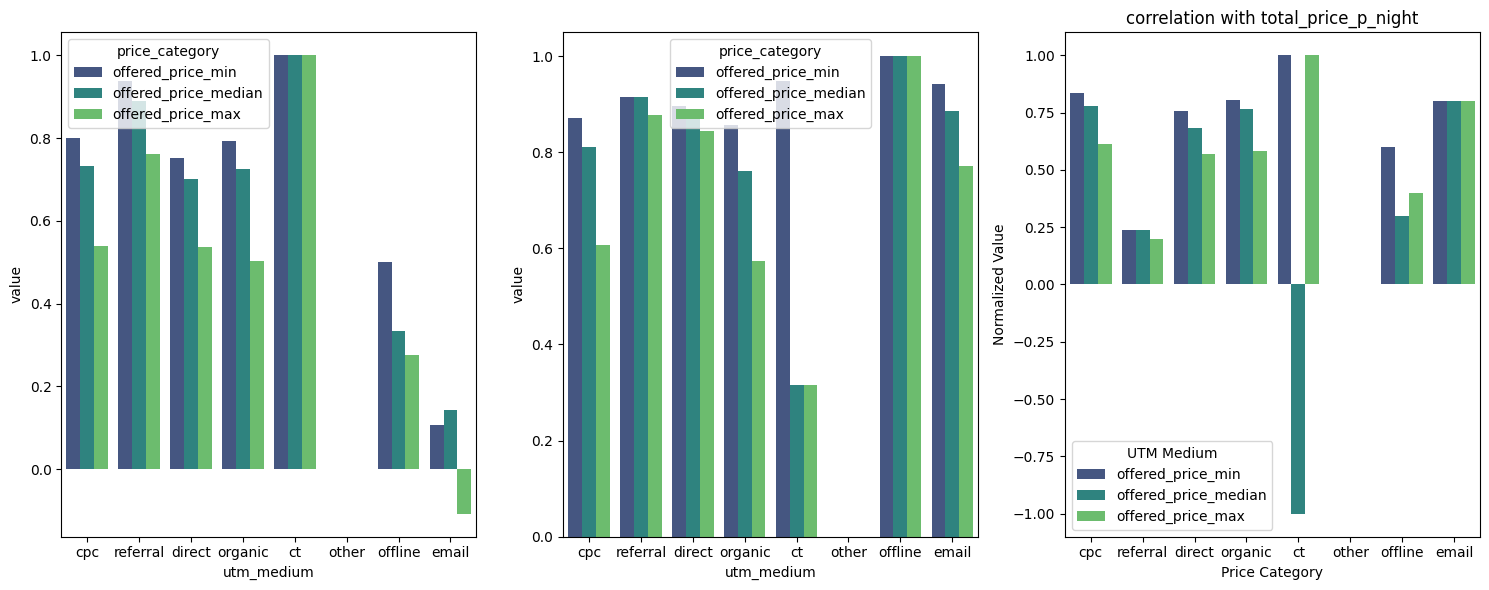

In [211]:
# to tidy format
df_tidy1 = mediums_corr1.reset_index().melt(id_vars="index", var_name="utm_medium", value_name="value")
df_tidy1.rename(columns={"index": "price_category"}, inplace=True)

df_tidy2 = mediums_corr2.reset_index().melt(id_vars="index", var_name="utm_medium", value_name="value")
df_tidy2.rename(columns={"index": "price_category"}, inplace=True)

df_tidy3 = mediums_corr3.reset_index().melt(id_vars="index", var_name="utm_medium", value_name="value")
df_tidy3.rename(columns={"index": "price_category"}, inplace=True)

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15, 6))
sns.barplot(ax=ax1, data=df_tidy1, hue="price_category", y="value", x="utm_medium", palette="viridis")
sns.barplot(ax=ax2, data=df_tidy2, hue="price_category", y="value", x="utm_medium", palette="viridis")
sns.barplot(ax=ax3, data=df_tidy3, hue="price_category", y="value", x="utm_medium", palette="viridis")
plt.title("correlation with total_price_p_night")
plt.ylabel("Normalized Value")
plt.xlabel("Price Category")
plt.legend(title="UTM Medium")
plt.tight_layout()

In [212]:
source_corr = pd.concat(
    [hotel1[hotel1['utm_source']=='facebook'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['utm_source']=='google'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['utm_source']=='other'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['utm_source']=='bing'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['utm_source']=='instagram'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night']], axis=1).set_axis(['facebook', 'google', 'other', 'bing', 'instagram'], axis=1).drop(index='total_price_p_night')

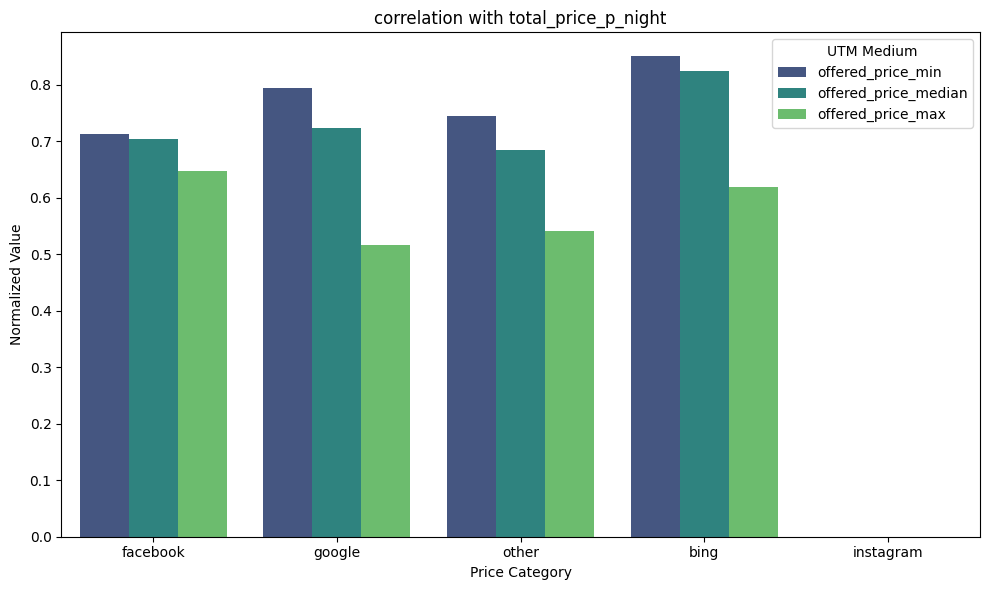

In [213]:
# to tidy format
df_tidy = source_corr.reset_index().melt(id_vars="index", var_name="utm_source", value_name="value")
df_tidy.rename(columns={"index": "price_category"}, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_tidy,
    hue="price_category",
    y="value",
    x="utm_source",
    palette="viridis",
)
plt.title("correlation with total_price_p_night")
plt.ylabel("Normalized Value")
plt.xlabel("Price Category")
plt.legend(title="UTM Medium")
plt.tight_layout()

<Axes: ylabel='Frequency'>

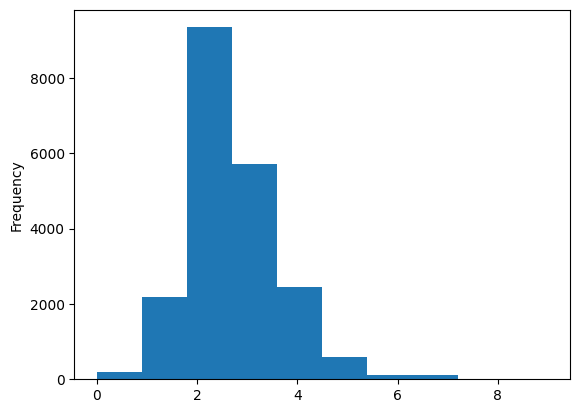

In [214]:
hotel1['nights'].plot(kind='hist')

In [215]:
nights_corr1 = pd.concat(
    [hotel1[hotel1['nights']==1][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['nights']==2][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['nights']==3][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['nights']==4][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['nights']==5][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['nights']==6][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['nights']==7][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['nights']==8][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night']],
     axis=1).set_axis(['1', '2', '3', '4', '5', '6', '7', '8'], axis=1).drop(index='total_price_p_night')

nights_corr2 = pd.concat(
    [hotel2[hotel2['nights']==1][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel2[hotel2['nights']==2][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel2[hotel2['nights']==3][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel2[hotel2['nights']==4][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel2[hotel2['nights']==5][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel2[hotel2['nights']==6][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel2[hotel2['nights']==7][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel2[hotel2['nights']==8][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night']],
     axis=1).set_axis(['1', '2', '3', '4', '5', '6', '7', '8'], axis=1).drop(index='total_price_p_night')

nights_corr3 = pd.concat(
    [hotel3[hotel3['nights']==1][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel3[hotel3['nights']==2][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel3[hotel3['nights']==3][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel3[hotel3['nights']==4][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel3[hotel3['nights']==5][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel3[hotel3['nights']==6][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel3[hotel3['nights']==7][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel3[hotel3['nights']==8][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night']],
     axis=1).set_axis(['1', '2', '3', '4', '5', '6', '7', '8'], axis=1).drop(index='total_price_p_night')

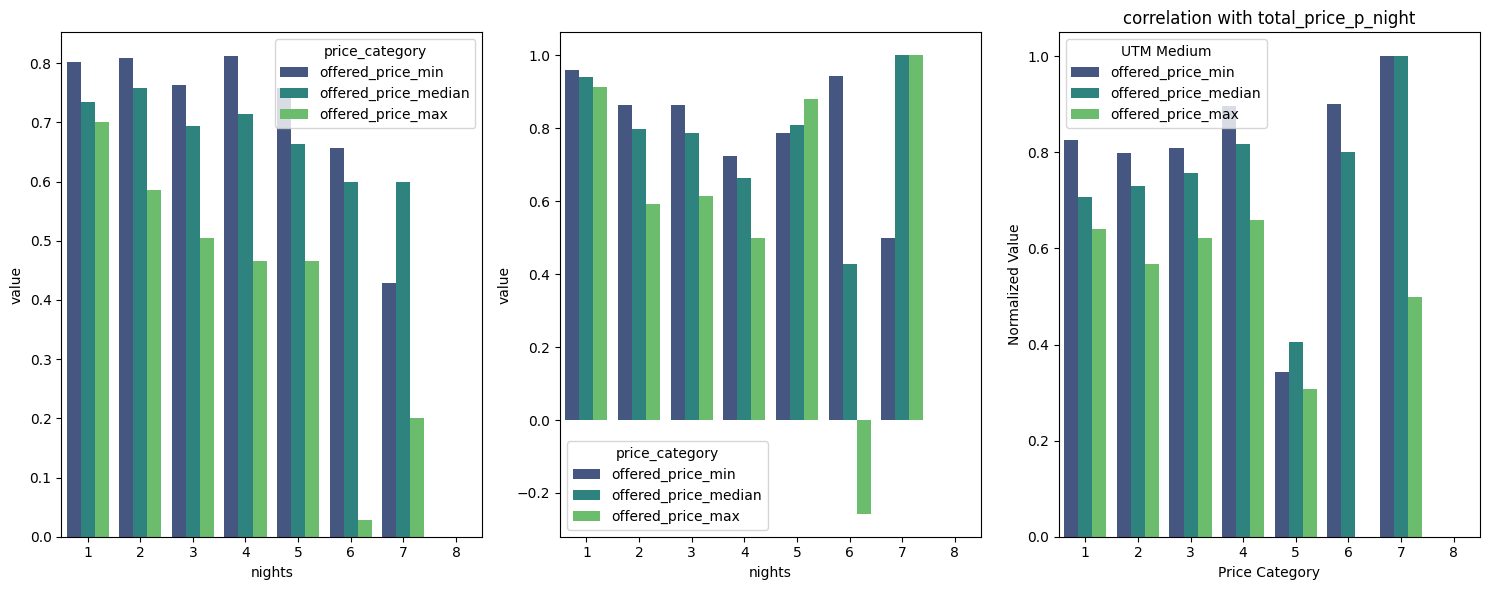

In [216]:
# convert to tidy format
df_tidy1 = nights_corr1.reset_index().melt(id_vars="index", var_name="nights", value_name="value")
df_tidy1.rename(columns={"index": "price_category"}, inplace=True)
df_tidy2 = nights_corr2.reset_index().melt(id_vars="index", var_name="nights", value_name="value")
df_tidy2.rename(columns={"index": "price_category"}, inplace=True)
df_tidy3 = nights_corr3.reset_index().melt(id_vars="index", var_name="nights", value_name="value")
df_tidy3.rename(columns={"index": "price_category"}, inplace=True)

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15, 6))
sns.barplot(ax=ax1, data=df_tidy1, hue="price_category", y="value", x="nights", palette="viridis")
sns.barplot(ax=ax2, data=df_tidy2, hue="price_category", y="value", x="nights", palette="viridis")
sns.barplot(ax=ax3, data=df_tidy3, hue="price_category", y="value", x="nights", palette="viridis")
plt.title("correlation with total_price_p_night")
plt.ylabel("Normalized Value")
plt.xlabel("Price Category")
plt.legend(title="UTM Medium")
plt.tight_layout()

In [217]:
children_corr = pd.concat(
    [hotel1[hotel1['children']==0][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['children']==1][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['children']==2][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['children']==3][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['children']==4][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['children']==5][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night']],
     axis=1).set_axis(['0','1', '2', '3', '4', '5'], axis=1).drop(index='total_price_p_night')

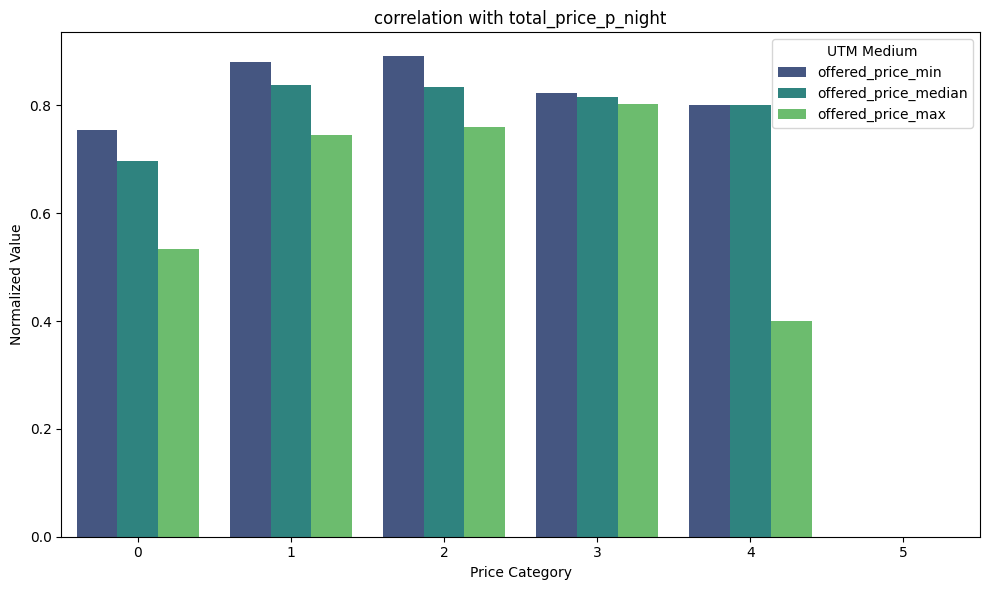

In [218]:
# to tidy format
df_tidy = children_corr.reset_index().melt(id_vars="index", var_name="children", value_name="value")
df_tidy.rename(columns={"index": "price_category"}, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_tidy,
    hue="price_category",
    y="value",
    x="children",
    palette="viridis")

plt.title("correlation with total_price_p_night")
plt.ylabel("Normalized Value")
plt.xlabel("Price Category")
plt.legend(title="UTM Medium")
plt.tight_layout()

In [219]:
if_children_corr = pd.concat(
    [hotel1[hotel1['if_children']==0][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['if_children']==1][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night']],
     axis=1).set_axis(['0','1'], axis=1).drop(index='total_price_p_night')

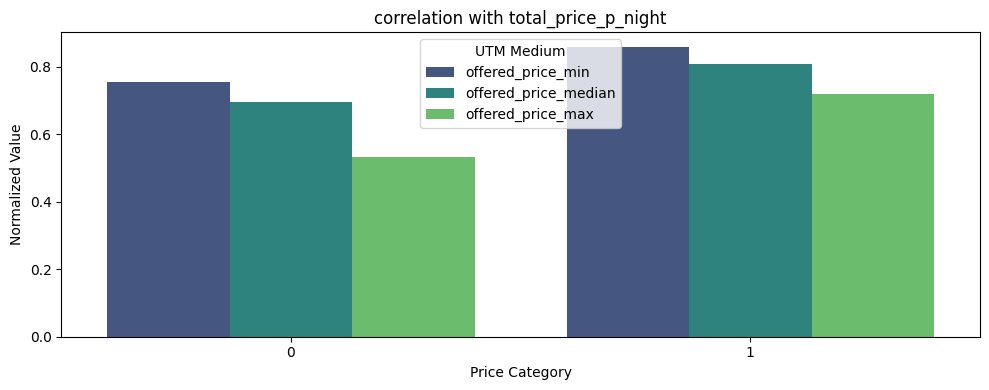

In [220]:
# to tidy format
df_tidy = if_children_corr.reset_index().melt(id_vars="index", var_name="if_children", value_name="value")
df_tidy.rename(columns={"index": "price_category"}, inplace=True)

plt.figure(figsize=(10, 4))
sns.barplot(
    data=df_tidy,
    hue="price_category",
    y="value",
    x="if_children",
    palette="viridis")

plt.title("correlation with total_price_p_night")
plt.ylabel("Normalized Value")
plt.xlabel("Price Category")
plt.legend(title="UTM Medium")
plt.tight_layout()

<Axes: ylabel='Frequency'>

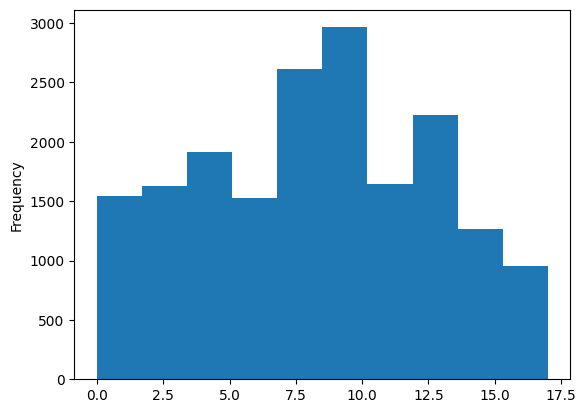

In [221]:
df['children_age_mean'].plot(kind='hist')

In [222]:
children_age_corr1 = pd.concat(
    [hotel1[hotel1['children_age_mean']<=7][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[(hotel1['children_age_mean']>7) & (hotel1['children_age_mean']<=12)][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['children_age_mean']>12][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night']],
     axis=1).set_axis(['<=7','7-12','>12'], axis=1).drop(index='total_price_p_night')

children_age_corr2 = pd.concat(
    [hotel2[hotel2['children_age_mean']<=7][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel2[(hotel2['children_age_mean']>7) & (hotel2['children_age_mean']<=12)][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel2[hotel2['children_age_mean']>12][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night']],
     axis=1).set_axis(['<=7','7-12','>12'], axis=1).drop(index='total_price_p_night')

children_age_corr3 = pd.concat(
    [hotel3[hotel3['children_age_mean']<=7][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel3[(hotel3['children_age_mean']>7) & (hotel3['children_age_mean']<=12)][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel3[hotel3['children_age_mean']>12][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night']],
     axis=1).set_axis(['<=7','7-12','>12'], axis=1).drop(index='total_price_p_night')

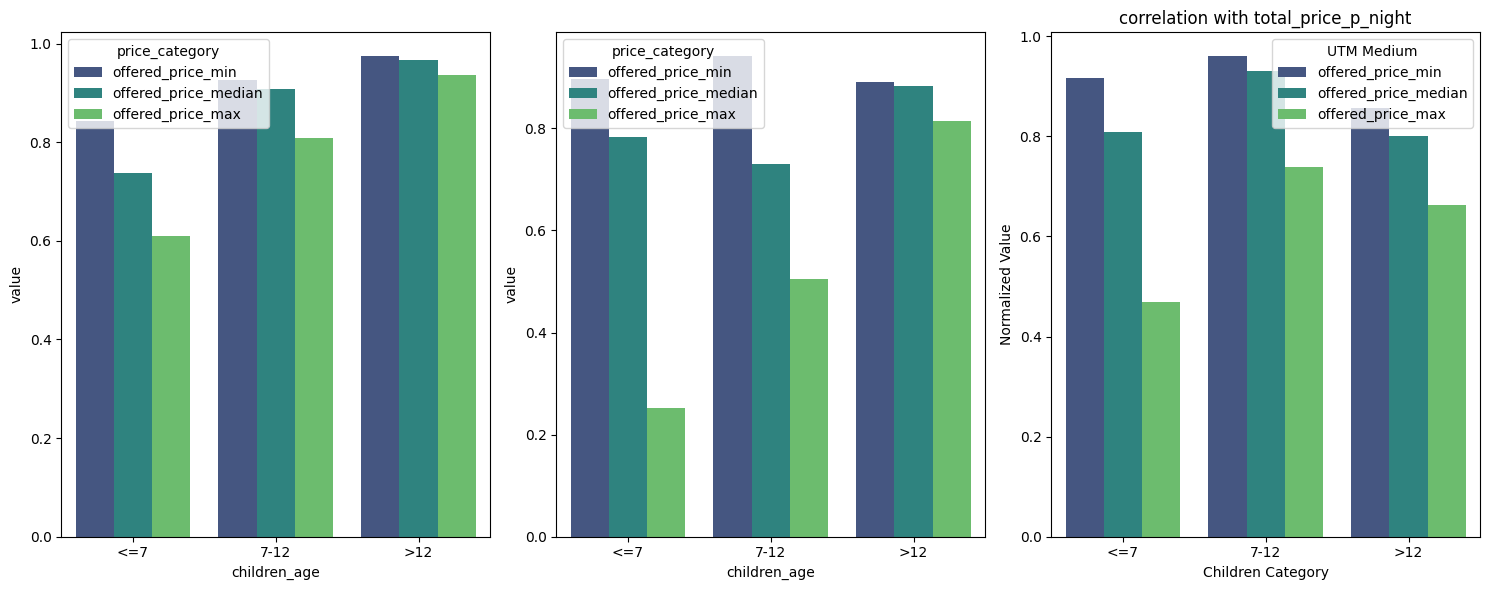

In [223]:
# to tidy format
df_tidy1 = children_age_corr1.reset_index().melt(id_vars="index", var_name="children_age", value_name="value")
df_tidy1.rename(columns={"index": "price_category"}, inplace=True)
df_tidy2 = children_age_corr2.reset_index().melt(id_vars="index", var_name="children_age", value_name="value")
df_tidy2.rename(columns={"index": "price_category"}, inplace=True)
df_tidy3 = children_age_corr3.reset_index().melt(id_vars="index", var_name="children_age", value_name="value")
df_tidy3.rename(columns={"index": "price_category"}, inplace=True)

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15, 6))
sns.barplot(ax=ax1, data=df_tidy1, hue="price_category", y="value", x="children_age", palette="viridis")
sns.barplot(ax=ax2, data=df_tidy2, hue="price_category", y="value", x="children_age", palette="viridis")
sns.barplot(ax=ax3, data=df_tidy3, hue="price_category", y="value", x="children_age", palette="viridis")
plt.title("correlation with total_price_p_night")
plt.ylabel("Normalized Value")
plt.xlabel("Children Category")
plt.legend(title="UTM Medium")
plt.tight_layout()

In [224]:
lead_time_corr1 = pd.concat(
    [hotel1[hotel1['lead_time_category']=='last_minute'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['lead_time_category']=='short_term'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['lead_time_category']=='medium_term'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['lead_time_category']=='long_term'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night']],
     axis=1).set_axis(['last_minute','short_term','medium_term','long_term'], axis=1).drop(index='total_price_p_night')

lead_time_corr2 = pd.concat(
    [hotel2[hotel2['lead_time_category']=='last_minute'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel2[hotel2['lead_time_category']=='short_term'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel2[hotel2['lead_time_category']=='medium_term'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel2[hotel2['lead_time_category']=='long_term'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night']],
     axis=1).set_axis(['last_minute','short_term','medium_term','long_term'], axis=1).drop(index='total_price_p_night')

lead_time_corr3 = pd.concat(
    [hotel3[hotel3['lead_time_category']=='last_minute'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel3[hotel3['lead_time_category']=='short_term'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel3[hotel3['lead_time_category']=='medium_term'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel3[hotel3['lead_time_category']=='long_term'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night']],
     axis=1).set_axis(['last_minute','short_term','medium_term','long_term'], axis=1).drop(index='total_price_p_night')

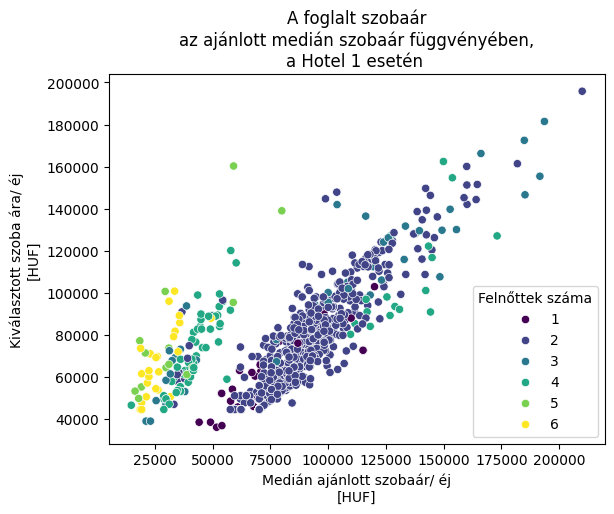

In [225]:
sns.scatterplot(data=hotel1, x='offered_price_median', y='total_price_p_night', hue='adults', palette='viridis')
plt.title('A foglalt szobaár''\n''az ajánlott medián szobaár függvényében,''\n''a Hotel 1 esetén ')
plt.xlabel('Medián ajánlott szobaár/ éj''\n''[HUF]')
plt.ylabel('Kiválasztott szoba ára/ éj''\n''[HUF]')
plt.legend(title='Felnőttek száma')

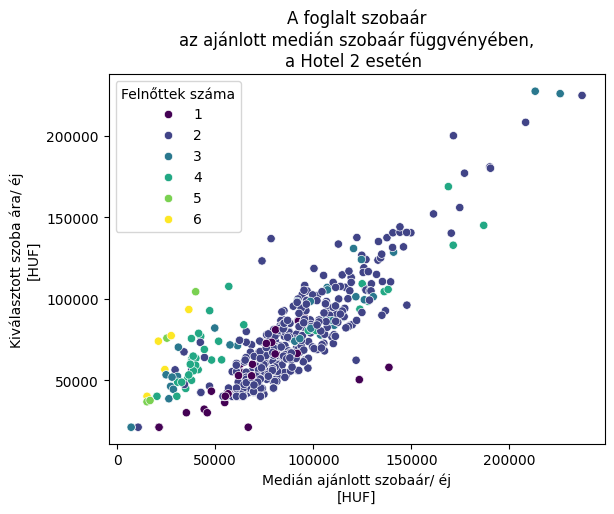

In [226]:
sns.scatterplot(data=hotel2, x='offered_price_median', y='total_price_p_night', hue='adults', palette='viridis')
plt.title('A foglalt szobaár''\n''az ajánlott medián szobaár függvényében,''\n''a Hotel 2 esetén ')
plt.xlabel('Medián ajánlott szobaár/ éj''\n''[HUF]')
plt.ylabel('Kiválasztott szoba ára/ éj''\n''[HUF]')
plt.legend(title='Felnőttek száma')

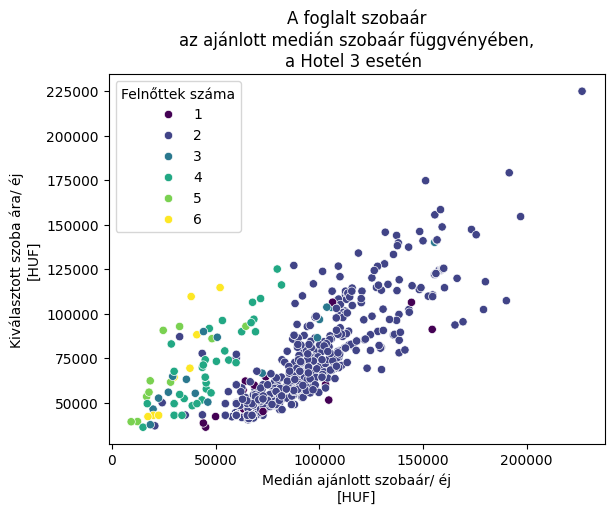

In [227]:
sns.scatterplot(data=hotel3, x='offered_price_median', y='total_price_p_night', hue='adults', palette='viridis')
plt.title('A foglalt szobaár''\n''az ajánlott medián szobaár függvényében,''\n''a Hotel 3 esetén ')
plt.xlabel('Medián ajánlott szobaár/ éj''\n''[HUF]')
plt.ylabel('Kiválasztott szoba ára/ éj''\n''[HUF]')
plt.legend(title='Felnőttek száma')

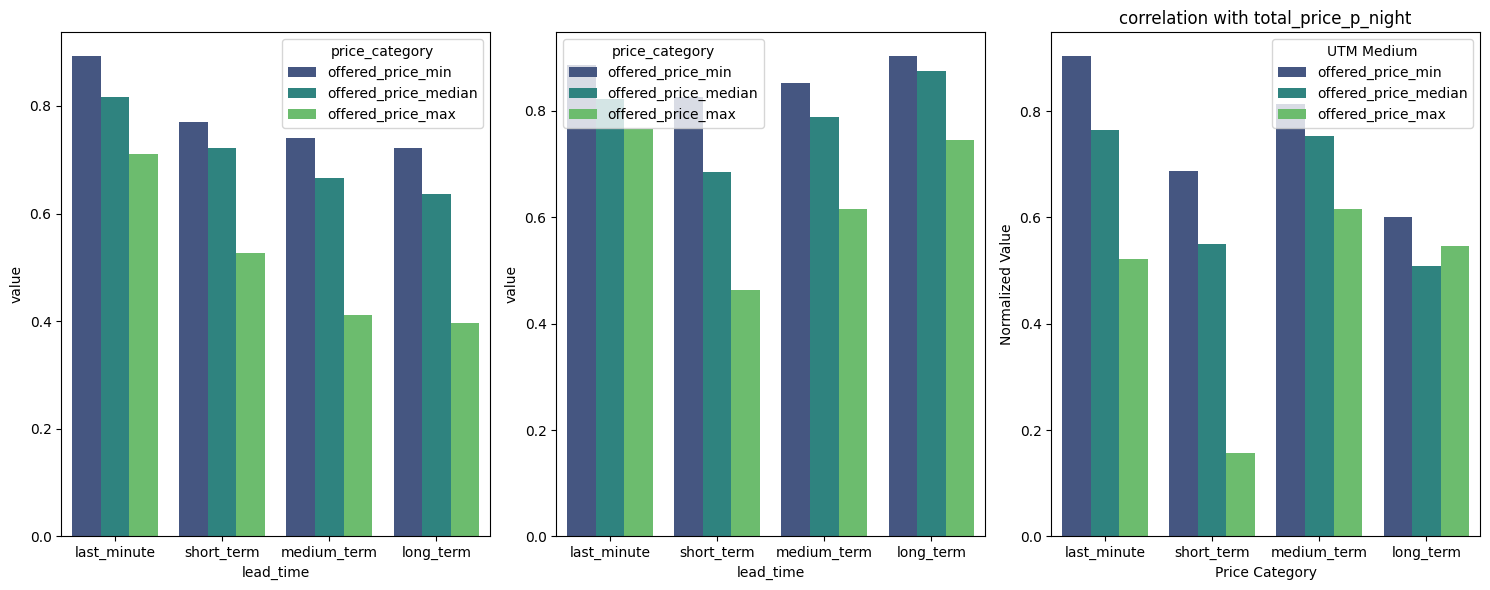

In [228]:
# to tidy format
df_tidy1 = lead_time_corr1.reset_index().melt(id_vars="index", var_name="lead_time", value_name="value")
df_tidy1.rename(columns={"index": "price_category"}, inplace=True)
df_tidy2 = lead_time_corr2.reset_index().melt(id_vars="index", var_name="lead_time", value_name="value")
df_tidy2.rename(columns={"index": "price_category"}, inplace=True)
df_tidy3 = lead_time_corr3.reset_index().melt(id_vars="index", var_name="lead_time", value_name="value")
df_tidy3.rename(columns={"index": "price_category"}, inplace=True)

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15, 6))
sns.barplot(ax=ax1, data=df_tidy1, hue="price_category", y="value", x="lead_time", palette="viridis")
sns.barplot(ax=ax2, data=df_tidy2, hue="price_category", y="value", x="lead_time", palette="viridis")
sns.barplot(ax=ax3, data=df_tidy3, hue="price_category", y="value", x="lead_time", palette="viridis")
plt.title("correlation with total_price_p_night")
plt.ylabel("Normalized Value")
plt.xlabel("Price Category")
plt.legend(title="UTM Medium")
plt.tight_layout()

([<matplotlib.axis.XTick at 0x2991f4230>,
 [Text(0.0, 0, 'Last minute'),
  Text(1.0, 0, 'Rövidtávú'),
  Text(2.0, 0, 'Középtávú'),
  Text(3.0, 0, 'Hosszútávú')])

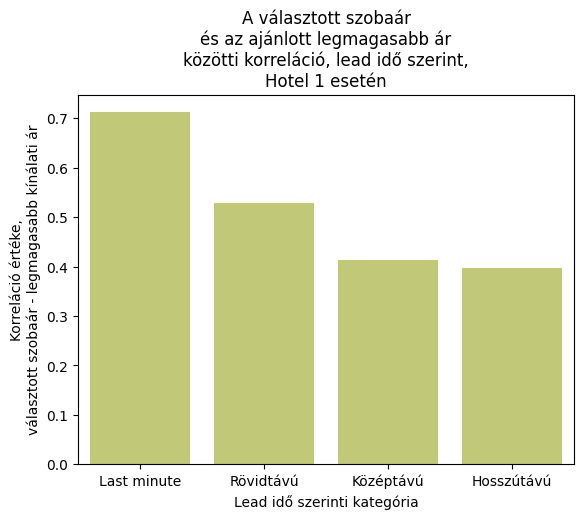

In [229]:
sns.barplot(data=df_tidy1[df_tidy1['price_category']=='offered_price_max'], hue="price_category", y="value", x="lead_time", palette=custom_palette, legend=False)
plt.title("A választott szobaár""\n""és az ajánlott legmagasabb ár""\n""közötti korreláció, lead idő szerint,""\n""Hotel 1 esetén")
plt.ylabel("Korreláció értéke,""\n""választott szobaár - legmagasabb kínálati ár")
plt.xlabel("Lead idő szerinti kategória")
plt.xticks(ticks=['last_minute','short_term','medium_term','long_term'],labels=['Last minute', 'Rövidtávú', 'Középtávú', 'Hosszútávú'])

([<matplotlib.axis.XTick at 0x28cf082c0>,
 [Text(0.0, 0, 'Last minute'),
  Text(1.0, 0, 'Rövidtávú'),
  Text(2.0, 0, 'Középtávú'),
  Text(3.0, 0, 'Hosszútávú')])

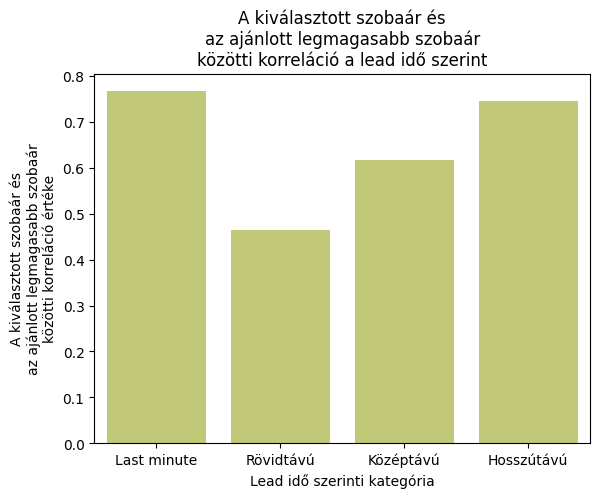

In [230]:
sns.barplot(data=df_tidy2[df_tidy2['price_category']=='offered_price_max'], hue="price_category", y="value", x="lead_time", palette=custom_palette, legend=False)
plt.title("A kiválasztott szobaár és""\n""az ajánlott legmagasabb szobaár""\n""közötti korreláció a lead idő szerint")
plt.ylabel("A kiválasztott szobaár és""\n""az ajánlott legmagasabb szobaár""\n""közötti korreláció értéke")
plt.xlabel("Lead idő szerinti kategória")
plt.xticks(ticks=['last_minute','short_term','medium_term','long_term'],labels=['Last minute', 'Rövidtávú', 'Középtávú', 'Hosszútávú'])

([<matplotlib.axis.XTick at 0x28cecbc50>,
 [Text(0.0, 0, 'Last minute'),
  Text(1.0, 0, 'Rövidtávú'),
  Text(2.0, 0, 'Középtávú'),
  Text(3.0, 0, 'Hosszútávú')])

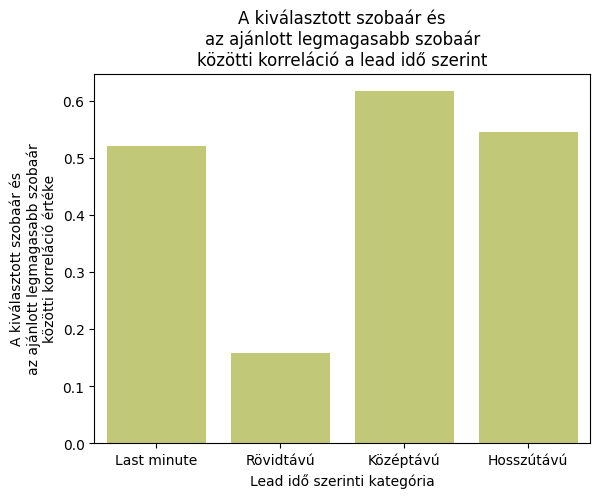

In [231]:
sns.barplot(data=df_tidy3[df_tidy3['price_category']=='offered_price_max'], hue="price_category", y="value", x="lead_time", palette=custom_palette, legend=False)
plt.title("A kiválasztott szobaár és""\n""az ajánlott legmagasabb szobaár""\n""közötti korreláció a lead idő szerint")
plt.ylabel("A kiválasztott szobaár és""\n""az ajánlott legmagasabb szobaár""\n""közötti korreláció értéke")
plt.xlabel("Lead idő szerinti kategória")
plt.xticks(ticks=['last_minute','short_term','medium_term','long_term'],labels=['Last minute', 'Rövidtávú', 'Középtávú', 'Hosszútávú'])

In [232]:
df.columns

Index(['search_log_session_id', 'search_log_id', 'session_id',
       'search_log_room_id', 'uuid', 'utc_datetime', 'utm_source',
       'utm_medium', 'utm_campaign', 'lang_code', 'currency', 'arrival',
       'departure', 'nights', 'adults', 'children', 'if_children',
       'children_age_mean', 'conversion', 'sel_num_of_rooms',
       'mean_room_price', 'total_price_p_night', 'picked_room', 'baby_bed',
       'pieces', 'sum_price', 'total_price_final', 'rooms_total_price',
       'upsell_total_price', 'vouchers_total_price', 'loyalty_discount_total',
       'redeemed_loyalty_points_total', 'hotel_id', 'rfm_monetary_score',
       'rfm_duration_score', '0_age', '1_age', '2_age', '3_age', '4_age',
       'ROOMAA_room_price_min', 'offered_price_median', 'offered_price_min',
       'offered_price_max', 'ROOMAA_room_price_max', 'ROOMBB_room_price_min',
       'ROOMBB_room_price_max', 'ROOMCC_room_price_min',
       'ROOMCC_room_price_max', 'ROOMDD_room_price_min',
       'ROOMDD_room_pric

In [233]:
# willingness to pay - wtp
wtp = df[['hotel_id','arrival','total_price_p_night','upsell_total_price']].groupby(by=['hotel_id','arrival']).median().reset_index().dropna()
wtp

hotel_id    arrival  total_price_p_night  upsell_total_price
2    hotel_1 2024-09-20         87975.000000                 0.0
3    hotel_1 2024-09-21         86935.550000                 0.0
4    hotel_1 2024-09-22         67104.000000                 0.0
5    hotel_1 2024-09-23         71533.890000                 0.0
6    hotel_1 2024-09-24         78922.241933                 0.0
..       ...        ...                  ...                 ...
744  hotel_3 2025-02-14         54977.915000                 0.0
747  hotel_3 2025-02-17         49914.480000                 0.0
812  hotel_3 2025-05-24         53346.000000                 0.0
833  hotel_3 2025-06-22         82473.358000                 0.0
881  hotel_3 2025-08-31         70244.688000                 0.0

[390 rows x 4 columns]

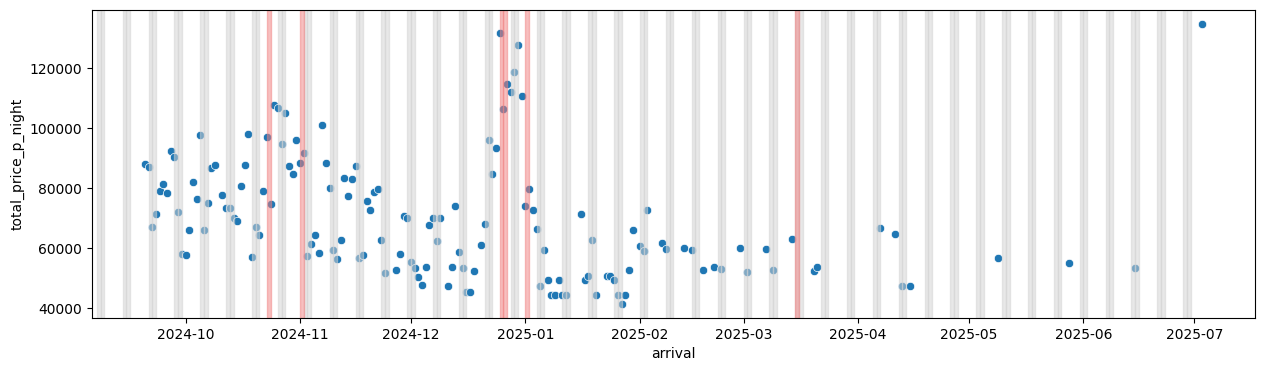

In [234]:
# mean room price as function of the date
fig, ax1 = plt.subplots(1,1, figsize=(15,4))
sns.scatterplot(ax=ax1, data=wtp[wtp['hotel_id']=='hotel_1'], x='arrival', y='total_price_p_night' )

# highlight weekends
start_date = pd.to_datetime('2024-09-01')  # Adjust based on your data range
end_date = pd.to_datetime('2025-07-01')
current_date = start_date

while current_date <= end_date:
    if current_date.weekday() >= 5:  # Saturday (5) and Sunday (6)
        ax1.axvspan(current_date, current_date + timedelta(days=1), color='lightgrey', alpha=0.5, label='Weekend' if current_date == start_date else None)
    current_date += timedelta(days=1)

# highlight public holidays
for holiday in public_holidays:
    if start_date <= holiday <= end_date:
        ax1.axvspan(holiday, holiday + timedelta(days=1), color='lightcoral', alpha=0.5, label='Public Holiday' if holiday == public_holidays[0] else None)

<Axes: xlabel='lead_time'>

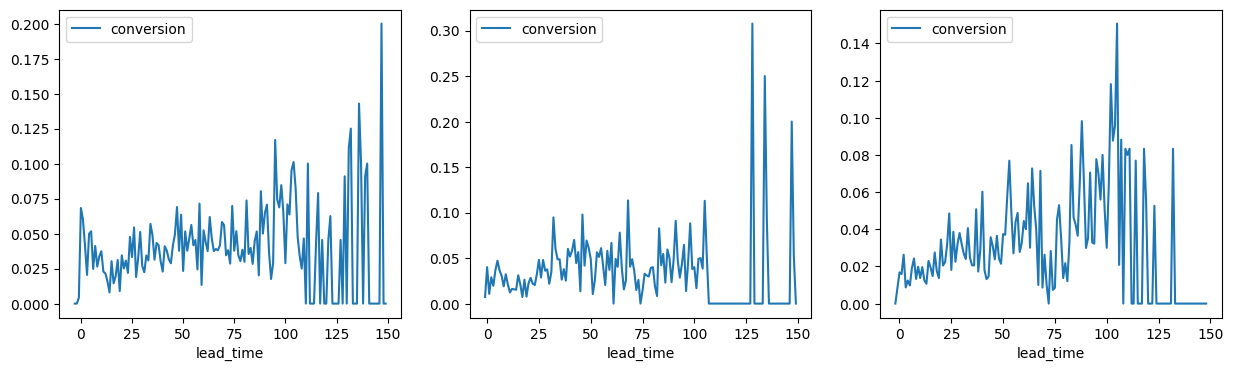

In [235]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))
hotel1[hotel1['lead_time']<150][['lead_time','conversion']].groupby(by='lead_time').mean().plot(ax=ax1)
hotel2[hotel2['lead_time']<150][['lead_time','conversion']].groupby(by='lead_time').mean().plot(ax=ax2)
hotel3[hotel3['lead_time']<150][['lead_time','conversion']].groupby(by='lead_time').mean().plot(ax=ax3)

In [236]:
df[['hotel_id','conversion','rfm_duration_score']].groupby(by=['hotel_id','rfm_duration_score']).mean()

conversion
hotel_id rfm_duration_score            
hotel_1  1                     0.039979
         2-3                   0.035649
         4-9                   0.048000
hotel_2  1                     0.038440
         2-3                   0.034095
         4-9                   0.034623
hotel_3  1                     0.031059
         2-3                   0.030881
         4-9                   0.029630

<Axes: xlabel='days_until_stay', ylabel='conversion'>

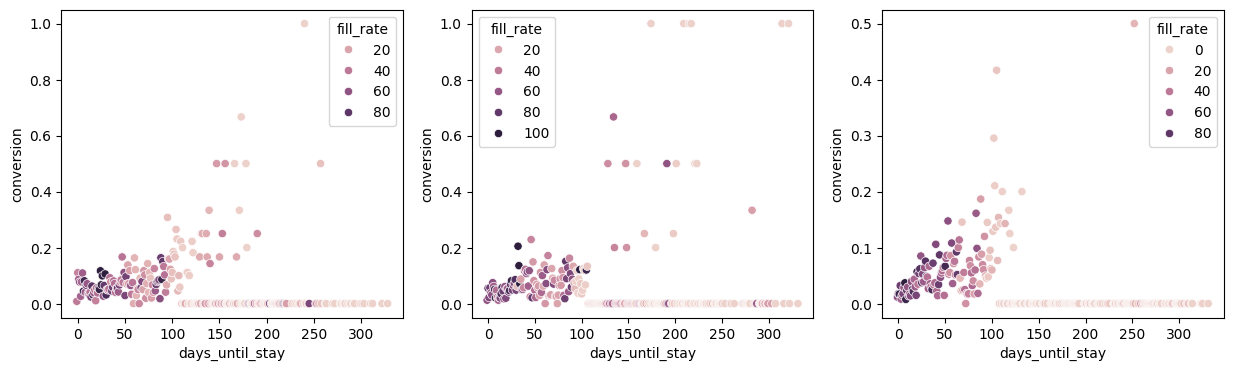

In [237]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))
sns.scatterplot(ax=ax1, data=occupancy_hotel_1, x='days_until_stay', y='conversion', hue='fill_rate')
sns.scatterplot(ax=ax2, data=occupancy_hotel_2, x='days_until_stay', y='conversion', hue='fill_rate')
sns.scatterplot(ax=ax3, data=occupancy_hotel_3, x='days_until_stay', y='conversion', hue='fill_rate')

In [238]:
occupancy_hotel = occupancy[['subject_date','fill_rate','days_until_stay','hotel_id']].groupby(by=['subject_date','hotel_id']).mean().reset_index().join(
    df_unique[['lead_time','conversion']].groupby(by='lead_time').mean(), on='days_until_stay', how='inner')

In [239]:
occupancy_hotel

subject_date hotel_id  fill_rate  days_until_stay  conversion
42     2024-10-02  hotel_1  39.049290             -1.0     0.01011
43     2024-10-02  hotel_2  61.083871             -1.0     0.01011
44     2024-10-02  hotel_3  63.808452             -1.0     0.01011
45     2024-10-03  hotel_1  35.415968              0.0     0.05868
46     2024-10-03  hotel_2  75.174194              0.0     0.05868
...           ...      ...        ...              ...         ...
1021   2025-08-24  hotel_2   1.058065            325.0     0.00000
1022   2025-08-24  hotel_3   0.792258            325.0     0.00000
1038   2025-08-30  hotel_1   0.526000            331.0     0.00000
1039   2025-08-30  hotel_2   0.800000            331.0     0.00000
1040   2025-08-30  hotel_3   0.000000            331.0     0.00000

[942 rows x 5 columns]

Text(0.5, 1.0, 'Átlagos konverziós arány a lead idő függvényében')

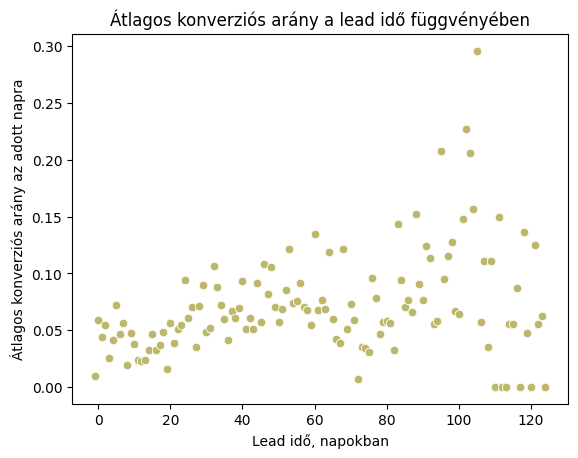

In [240]:
sns.scatterplot(data=occupancy_hotel[occupancy_hotel['days_until_stay']<125], x='days_until_stay', y='conversion', color='darkkhaki')
plt.xlabel('Lead idő, napokban')
plt.ylabel('Átlagos konverziós arány az adott napra')
plt.title('Átlagos konverziós arány a lead idő függvényében')

Text(0.5, 1.0, 'Átlagos konverziós arány a lead idő függvényében')

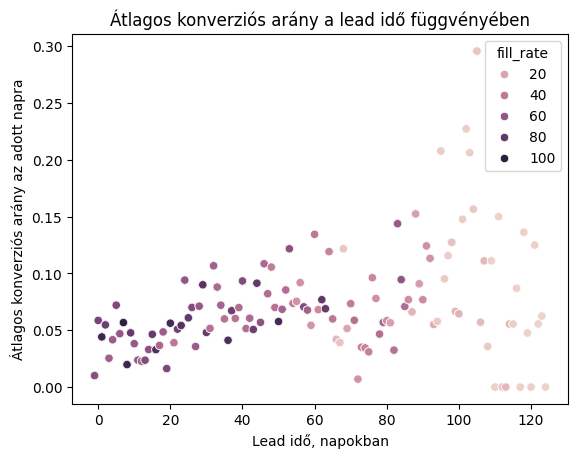

In [241]:
sns.scatterplot(data=occupancy_hotel[occupancy_hotel['days_until_stay']<125], x='days_until_stay', y='conversion', hue='fill_rate')
plt.xlabel('Lead idő, napokban')
plt.ylabel('Átlagos konverziós arány az adott napra')
plt.title('Átlagos konverziós arány a lead idő függvényében')

In [242]:
hotel1[hotel1['arrival']<'2025-03-01'][['arrival','offered_price_min']].groupby(by='arrival').min().reset_index()

arrival  offered_price_min
0   2024-09-18         20216.5875
1   2024-09-19         36819.5000
2   2024-09-20         22080.0000
3   2024-09-21         52785.0000
4   2024-09-22         42956.0000
..         ...                ...
159 2025-02-24         52240.0000
160 2025-02-25         84297.0000
161 2025-02-26         52384.2000
162 2025-02-27         53856.0000
163 2025-02-28         53856.0000

[164 rows x 2 columns]

Text(0.5, 0, 'Date searched for')

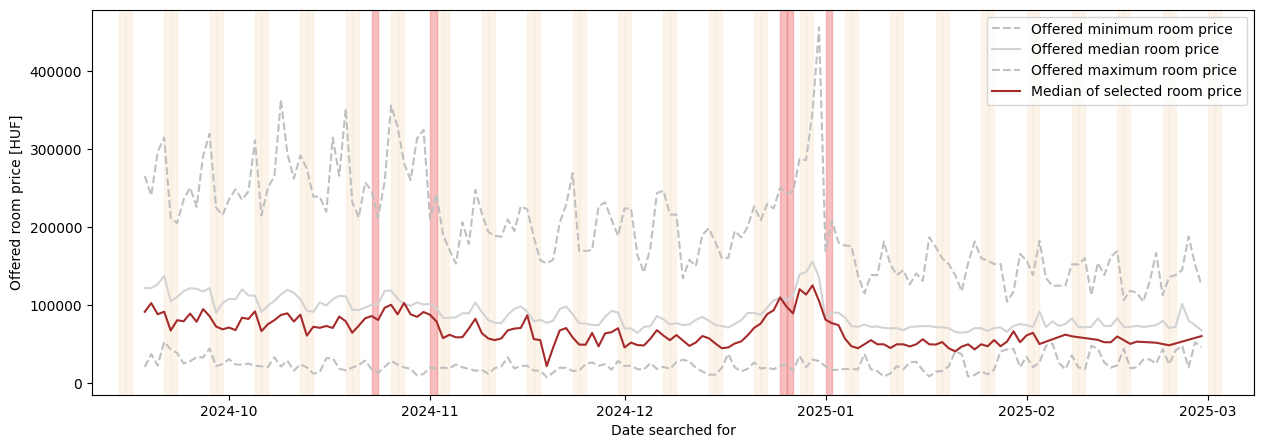

In [243]:
# for every hotel

fig, (ax1) = plt.subplots(1,1,figsize=(15,5))

sns.lineplot(ax=ax1, data=df[df['arrival']<'2025-03-01'][['arrival','offered_price_min']].groupby(by='arrival').min().reset_index(), x='arrival', y='offered_price_min', ci=None, color='silver', linestyle='--')
sns.lineplot(ax=ax1, data=df[df['arrival']<'2025-03-01'][['arrival','offered_price_median']].groupby(by='arrival').median().reset_index(), x='arrival', y='offered_price_median', ci=None, color='lightgrey')
sns.lineplot(ax=ax1, data=df[df['arrival']<'2025-03-01'][['arrival','offered_price_max']].groupby(by='arrival').max().reset_index(), x='arrival', y='offered_price_max', ci=None, color='silver', linestyle='--')
sns.lineplot(ax=ax1, data=df[df['arrival']<'2025-03-01'][['arrival','total_price_p_night']].groupby(by='arrival').median().reset_index(), x='arrival', y='total_price_p_night', ci=None, color='brown')
ax1.legend(['Offered minimum room price','Offered median room price','Offered maximum room price','Median of selected room price'])

# highlight weekends
start_date = pd.to_datetime('2024-09-01')
end_date = pd.to_datetime('2025-07-01')
current_date = start_date

while current_date <= end_date:
    if current_date.weekday() >= 5:
        ax1.axvspan(current_date, current_date + timedelta(days=1), color='antiquewhite', alpha=0.5, label='Weekend' if current_date == start_date else None)
    current_date += timedelta(days=1)

# highlight public holidays
for holiday in public_holidays:
    if start_date <= holiday <= end_date:
        ax1.axvspan(holiday, holiday + timedelta(days=1), color='lightcoral', alpha=0.5, label='Public Holiday' if holiday == public_holidays[0] else None)
        
plt.ylabel('Offered room price [HUF]')
plt.xlabel('Date searched for')

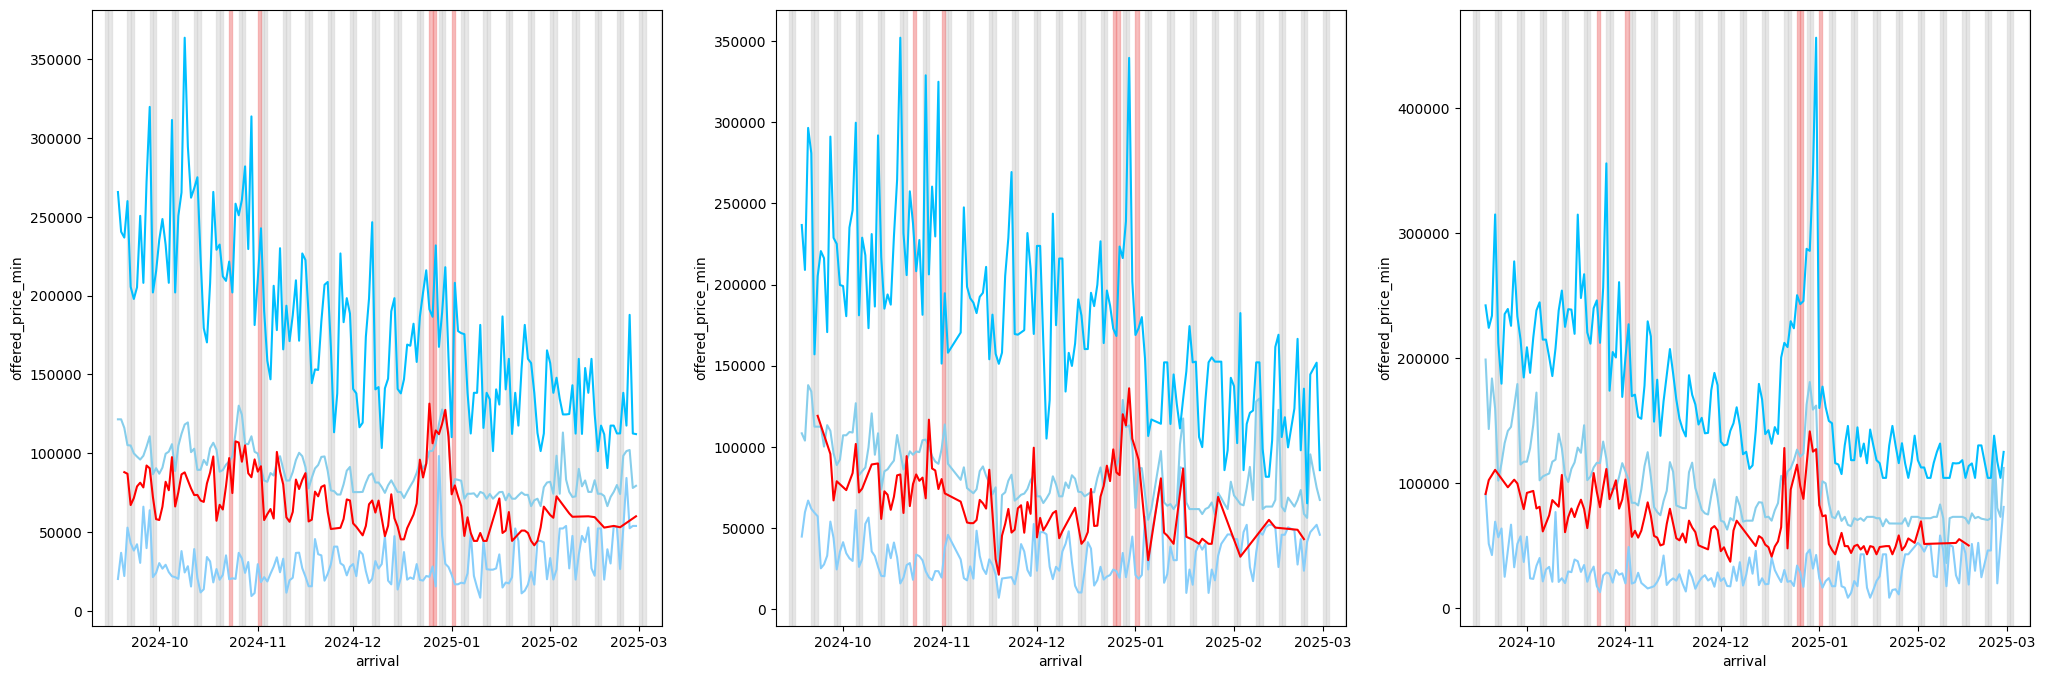

In [244]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(25,8))

sns.lineplot(ax=ax1, data=hotel1[hotel1['arrival']<'2025-03-01'][['arrival','offered_price_min']].groupby(by='arrival').min().reset_index(), x='arrival', y='offered_price_min', ci=None, color='lightskyblue')
sns.lineplot(ax=ax1, data=hotel1[hotel1['arrival']<'2025-03-01'][['arrival','offered_price_median']].groupby(by='arrival').median().reset_index(), x='arrival', y='offered_price_median', ci=None, color='skyblue')
sns.lineplot(ax=ax1, data=hotel1[hotel1['arrival']<'2025-03-01'][['arrival','offered_price_max']].groupby(by='arrival').max().reset_index(), x='arrival', y='offered_price_max', ci=None, color='deepskyblue')
sns.lineplot(ax=ax1, data=hotel1[hotel1['arrival']<'2025-03-01'][['arrival','total_price_p_night']].groupby(by='arrival').median().reset_index(), x='arrival', y='total_price_p_night', ci=None, color='red')

sns.lineplot(ax=ax2, data=hotel2[hotel2['arrival']<'2025-03-01'][['arrival','offered_price_min']].groupby(by='arrival').min().reset_index(), x='arrival', y='offered_price_min', ci=None, color='lightskyblue')
sns.lineplot(ax=ax2, data=hotel2[hotel2['arrival']<'2025-03-01'][['arrival','offered_price_median']].groupby(by='arrival').median().reset_index(), x='arrival', y='offered_price_median', ci=None, color='skyblue')
sns.lineplot(ax=ax2, data=hotel2[hotel2['arrival']<'2025-03-01'][['arrival','offered_price_max']].groupby(by='arrival').max().reset_index(), x='arrival', y='offered_price_max', ci=None, color='deepskyblue')
sns.lineplot(ax=ax2, data=hotel2[hotel2['arrival']<'2025-03-01'][['arrival','total_price_p_night']].groupby(by='arrival').median().reset_index(), x='arrival', y='total_price_p_night', ci=None, color='red')

sns.lineplot(ax=ax3, data=hotel3[hotel3['arrival']<'2025-03-01'][['arrival','offered_price_min']].groupby(by='arrival').min().reset_index(), x='arrival', y='offered_price_min', ci=None, color='lightskyblue')
sns.lineplot(ax=ax3, data=hotel3[hotel3['arrival']<'2025-03-01'][['arrival','offered_price_median']].groupby(by='arrival').median().reset_index(), x='arrival', y='offered_price_median', ci=None, color='skyblue')
sns.lineplot(ax=ax3, data=hotel3[hotel3['arrival']<'2025-03-01'][['arrival','offered_price_max']].groupby(by='arrival').max().reset_index(), x='arrival', y='offered_price_max', ci=None, color='deepskyblue')
sns.lineplot(ax=ax3, data=hotel3[hotel3['arrival']<'2025-03-01'][['arrival','total_price_p_night']].groupby(by='arrival').median().reset_index(), x='arrival', y='total_price_p_night', ci=None, color='red')

# highlight weekends
start_date = pd.to_datetime('2024-09-01')
end_date = pd.to_datetime('2025-07-01')
current_date = start_date

while current_date <= end_date:
    if current_date.weekday() >= 5: 
        ax1.axvspan(current_date, current_date + timedelta(days=1), color='lightgrey', alpha=0.5, label='Weekend' if current_date == start_date else None)
        ax2.axvspan(current_date, current_date + timedelta(days=1), color='lightgrey', alpha=0.5, label='Weekend' if current_date == start_date else None)
        ax3.axvspan(current_date, current_date + timedelta(days=1), color='lightgrey', alpha=0.5, label='Weekend' if current_date == start_date else None)
    current_date += timedelta(days=1)

# highlight public holidays
for holiday in public_holidays:
    if start_date <= holiday <= end_date:
        ax1.axvspan(holiday, holiday + timedelta(days=1), color='lightcoral', alpha=0.5, label='Public Holiday' if holiday == public_holidays[0] else None)
        ax2.axvspan(holiday, holiday + timedelta(days=1), color='lightcoral', alpha=0.5, label='Public Holiday' if holiday == public_holidays[0] else None)
        ax3.axvspan(holiday, holiday + timedelta(days=1), color='lightcoral', alpha=0.5, label='Public Holiday' if holiday == public_holidays[0] else None)

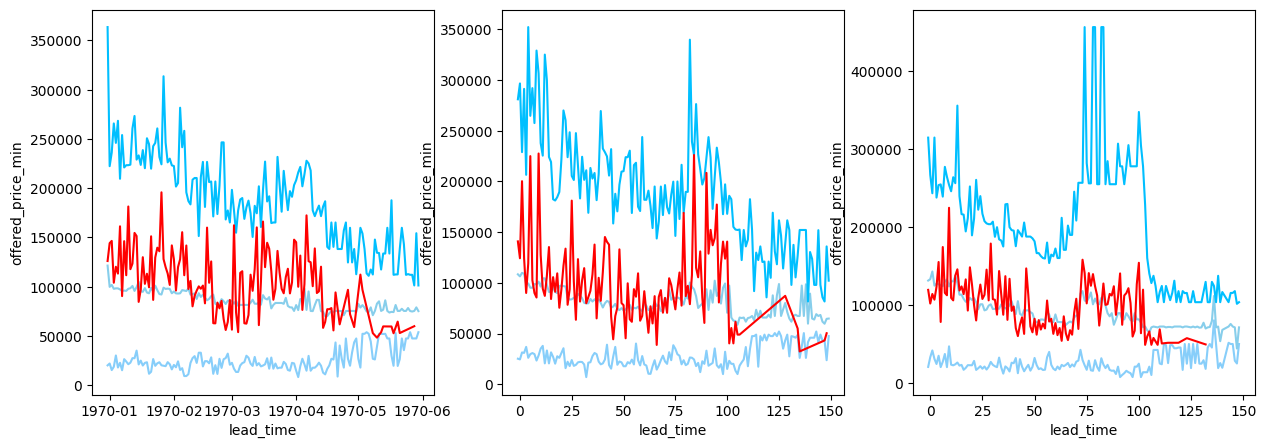

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))

sns.lineplot(ax=ax1, data=hotel1[hotel1['lead_time']<150][['lead_time','offered_price_min']].groupby(by='lead_time').min().reset_index(), x='lead_time', y='offered_price_min', ci=None, color='lightskyblue')
sns.lineplot(ax=ax1, data=hotel1[hotel1['lead_time']<150][['lead_time','offered_price_median']].groupby(by='lead_time').median().reset_index(), x='lead_time', y='offered_price_median', ci=None, color='skyblue')
sns.lineplot(ax=ax1, data=hotel1[hotel1['lead_time']<150][['lead_time','offered_price_max']].groupby(by='lead_time').max().reset_index(), x='lead_time', y='offered_price_max', ci=None, color='deepskyblue')
sns.lineplot(ax=ax1, data=hotel1[hotel1['lead_time']<150][['lead_time','total_price_p_night']].groupby(by='lead_time').max().reset_index(), x='lead_time', y='total_price_p_night', ci=None, color='red')

sns.lineplot(ax=ax2, data=hotel2[hotel2['lead_time']<150][['lead_time','offered_price_min']].groupby(by='lead_time').min().reset_index(), x='lead_time', y='offered_price_min', ci=None, color='lightskyblue')
sns.lineplot(ax=ax2, data=hotel2[hotel2['lead_time']<150][['lead_time','offered_price_median']].groupby(by='lead_time').median().reset_index(), x='lead_time', y='offered_price_median', ci=None, color='skyblue')
sns.lineplot(ax=ax2, data=hotel2[hotel2['lead_time']<150][['lead_time','offered_price_max']].groupby(by='lead_time').max().reset_index(), x='lead_time', y='offered_price_max', ci=None, color='deepskyblue')
sns.lineplot(ax=ax2, data=hotel2[hotel2['lead_time']<150][['lead_time','total_price_p_night']].groupby(by='lead_time').max().reset_index(), x='lead_time', y='total_price_p_night', ci=None, color='red')

sns.lineplot(ax=ax3, data=hotel3[hotel3['lead_time']<150][['lead_time','offered_price_min']].groupby(by='lead_time').min().reset_index(), x='lead_time', y='offered_price_min', ci=None, color='lightskyblue')
sns.lineplot(ax=ax3, data=hotel3[hotel3['lead_time']<150][['lead_time','offered_price_median']].groupby(by='lead_time').median().reset_index(), x='lead_time', y='offered_price_median', ci=None, color='skyblue')
sns.lineplot(ax=ax3, data=hotel3[hotel3['lead_time']<150][['lead_time','offered_price_max']].groupby(by='lead_time').max().reset_index(), x='lead_time', y='offered_price_max', ci=None, color='deepskyblue')
sns.lineplot(ax=ax3, data=hotel3[hotel3['lead_time']<150][['lead_time','total_price_p_night']].groupby(by='lead_time').max().reset_index(), x='lead_time', y='total_price_p_night', ci=None, color='red')

# highlight weekends
start_date = pd.to_datetime('2024-09-01')
end_date = pd.to_datetime('2025-07-01')
current_date = start_date

while current_date <= end_date:
    if current_date.weekday() >= 5:
        ax1.axvspan(current_date, current_date + timedelta(days=1), color='lightgrey', alpha=0.5, label='Weekend' if current_date == start_date else None)
    current_date += timedelta(days=1)

# highlight public holidays
for holiday in public_holidays:
    if start_date <= holiday <= end_date:
        ax1.axvspan(holiday, holiday + timedelta(days=1), color='lightcoral', alpha=0.5, label='Public Holiday' if holiday == public_holidays[0] else None)

<Axes: xlabel='lead_time', ylabel='offered_price_median'>

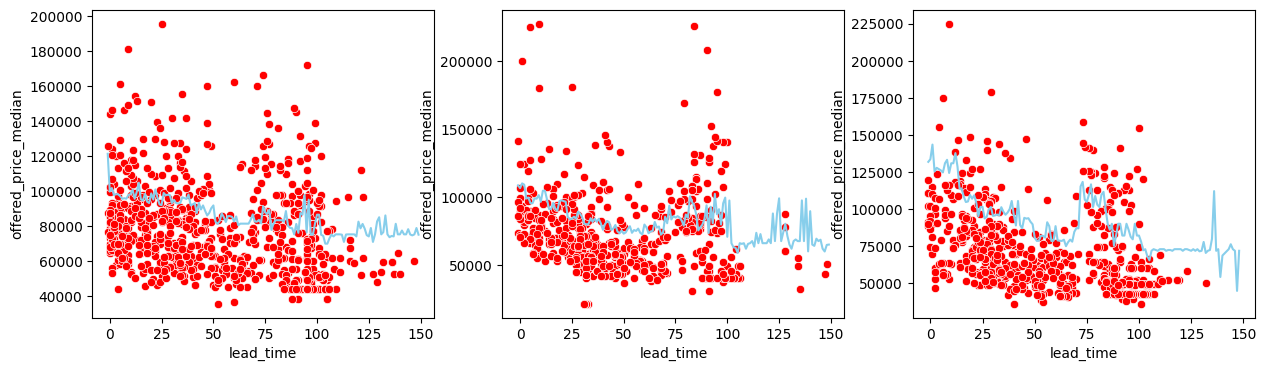

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,4))

sns.lineplot(ax=ax1, data=hotel1[hotel1['lead_time']<150][['lead_time','offered_price_median']].groupby(by='lead_time').median().reset_index(), x='lead_time', y='offered_price_median', ci=None, color='skyblue')
sns.scatterplot(ax=ax1, data=hotel1[hotel1['lead_time']<150][['lead_time','total_price_p_night']], x='lead_time', y='total_price_p_night', color='red')

sns.lineplot(ax=ax2, data=hotel2[hotel2['lead_time']<150][['lead_time','offered_price_median']].groupby(by='lead_time').median().reset_index(), x='lead_time', y='offered_price_median', ci=None, color='skyblue')
sns.scatterplot(ax=ax2, data=hotel2[hotel2['lead_time']<150][['lead_time','total_price_p_night']], x='lead_time', y='total_price_p_night', color='red')

sns.lineplot(ax=ax3, data=hotel3[hotel3['lead_time']<150][['lead_time','offered_price_median']].groupby(by='lead_time').median().reset_index(), x='lead_time', y='offered_price_median', ci=None, color='skyblue')
sns.scatterplot(ax=ax3, data=hotel3[hotel3['lead_time']<150][['lead_time','total_price_p_night']], x='lead_time', y='total_price_p_night', color='red')

In [ ]:
# foin median prices to the original dataframe for each hotel
merged = hotel1[['arrival','total_price_p_night']].join(hotel1[['arrival','offered_price_median']].groupby(by='arrival').median(), on='arrival', validate='m:1')
# Add the new column with adjusted logic
hotel1['higher_than_medium_price'] = np.where(
    merged['total_price_p_night'].isna(),  # condition if total_price_p_night is NaN
    float("NAN"),  # set False when total_price_p_night is NaN
    merged['total_price_p_night'] > merged['offered_price_median']  # Original condition
)

merged = hotel2[['arrival','total_price_p_night']].join(hotel2[['arrival','offered_price_median']].groupby(by='arrival').median(), on='arrival', validate='m:1')
hotel2['higher_than_medium_price'] = np.where(
    merged['total_price_p_night'].isna(),  # condition if total_price_p_night is NaN
    float("NAN"),  # set False when total_price_p_night is NaN
    merged['total_price_p_night'] > merged['offered_price_median']  # Original condition
)

merged = hotel3[['arrival','total_price_p_night']].join(hotel3[['arrival','offered_price_median']].groupby(by='arrival').median(), on='arrival', validate='m:1')
hotel3['higher_than_medium_price'] = np.where(
    merged['total_price_p_night'].isna(),  # condition if total_price_p_night is NaN
    float("NAN"),  # set False when total_price_p_night is NaN
    merged['total_price_p_night'] > merged['offered_price_median']  # Original condition
)

<Axes: xlabel='arrival', ylabel='offered_price_median'>

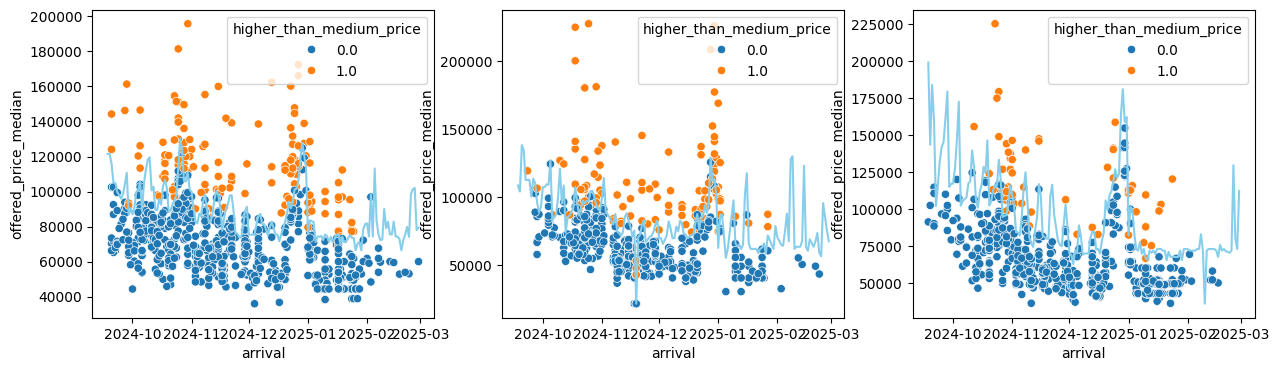

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,4))

sns.lineplot(ax=ax1, data=hotel1[hotel1['arrival']<'2025-03-01'][['arrival','offered_price_median']].groupby(by='arrival').median().reset_index(), x='arrival', y='offered_price_median', ci=None, color='skyblue')
sns.scatterplot(ax=ax1, data=hotel1[hotel1['arrival']<'2025-03-01'], x='arrival', y='total_price_p_night', hue='higher_than_medium_price', color='red')

sns.lineplot(ax=ax2, data=hotel2[hotel2['arrival']<'2025-03-01'][['arrival','offered_price_median']].groupby(by='arrival').median().reset_index(), x='arrival', y='offered_price_median', ci=None, color='skyblue')
sns.scatterplot(ax=ax2, data=hotel2[hotel2['arrival']<'2025-03-01'], x='arrival', y='total_price_p_night', hue='higher_than_medium_price', color='red')

sns.lineplot(ax=ax3, data=hotel3[hotel3['arrival']<'2025-03-01'][['arrival','offered_price_median']].groupby(by='arrival').median().reset_index(), x='arrival', y='offered_price_median', ci=None, color='skyblue')
sns.scatterplot(ax=ax3, data=hotel3[hotel3['arrival']<'2025-03-01'], x='arrival', y='total_price_p_night', hue='higher_than_medium_price', color='red')

<Axes: xlabel='arrival', ylabel='offered_price_median'>

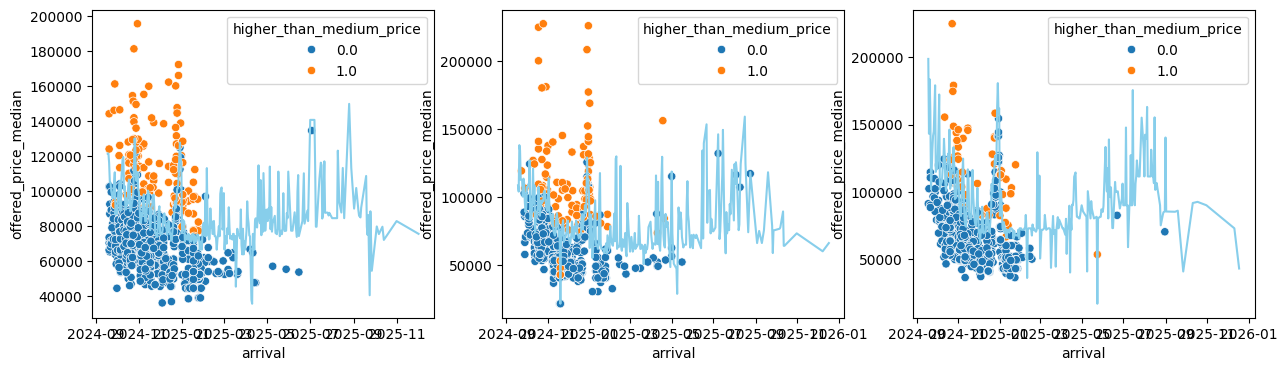

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,4))

sns.lineplot(ax=ax1, data=hotel1[['arrival','offered_price_median']].groupby(by='arrival').median().reset_index(), x='arrival', y='offered_price_median', ci=None, color='skyblue')
sns.scatterplot(ax=ax1, data=hotel1, x='arrival', y='total_price_p_night', hue='higher_than_medium_price', color='red')

sns.lineplot(ax=ax2, data=hotel2[['arrival','offered_price_median']].groupby(by='arrival').median().reset_index(), x='arrival', y='offered_price_median', ci=None, color='skyblue')
sns.scatterplot(ax=ax2, data=hotel2, x='arrival', y='total_price_p_night', hue='higher_than_medium_price', color='red')

sns.lineplot(ax=ax3, data=hotel3[['arrival','offered_price_median']].groupby(by='arrival').median().reset_index(), x='arrival', y='offered_price_median', ci=None, color='skyblue')
sns.scatterplot(ax=ax3, data=hotel3, x='arrival', y='total_price_p_night', hue='higher_than_medium_price', color='red')

In [ ]:
hotel1[['nights', 'adults', 'children', 'if_children','children_age_mean','sel_num_of_rooms',
        'upsell_total_price','lead_time','higher_than_medium_price']].groupby(by='higher_than_medium_price').mean()

nights    adults  children  if_children  \
higher_than_medium_price                                              
0.0                       2.625000  2.360937  0.387500     0.234375   
1.0                       2.402597  2.500000  1.422078     0.798701   

                          children_age_mean  sel_num_of_rooms  \
higher_than_medium_price                                        
0.0                                7.015815          1.239062   
1.0                                9.402778          1.058442   

                          upsell_total_price  lead_time  
higher_than_medium_price                                 
0.0                               961.321799  53.753125  
1.0                              1036.688312  54.629870

<Axes: xlabel='upsell_total_price', ylabel='Count'>

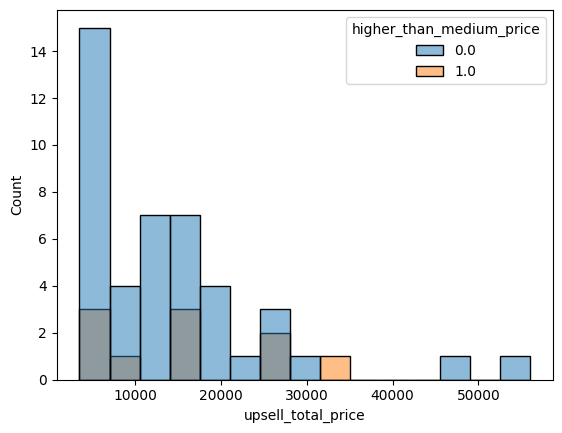

In [ ]:
sns.histplot(data=hotel1[hotel1['upsell_total_price']>0], x='upsell_total_price',hue='higher_than_medium_price', bins=15)

In [ ]:
hotel1[['utm_medium', 'higher_than_medium_price']].groupby(by='utm_medium').mean()

higher_than_medium_price
utm_medium                          
(not set)                   0.203125
cpc                         0.201389
ct                          1.000000
direct                      0.163636
email                       0.142857
offline                     0.500000
organic                     0.165517
other                            NaN
referral                    0.192308

In [ ]:
hotel1[['utm_source', 'higher_than_medium_price']].groupby(by='utm_source').mean()

higher_than_medium_price
utm_source                          
bing                        0.346154
facebook                    0.142857
google                      0.189944
instagram                        NaN
na                          0.203125
other                       0.183007

In [ ]:
hotel2[['nights', 'adults', 'children', 'if_children','children_age_mean','sel_num_of_rooms',
        'upsell_total_price','lead_time','higher_than_medium_price']].groupby(by='higher_than_medium_price').mean()

nights    adults  children  if_children  \
higher_than_medium_price                                              
0.0                       2.493182  2.097727  0.311364     0.227273   
1.0                       2.360000  2.360000  0.888000     0.528000   

                          children_age_mean  sel_num_of_rooms  \
higher_than_medium_price                                        
0.0                                6.201754          1.140909   
1.0                                8.977273          1.056000   

                          upsell_total_price  lead_time  
higher_than_medium_price                                 
0.0                               802.484361  52.404545  
1.0                               704.329552  56.368000

<Axes: xlabel='upsell_total_price', ylabel='Count'>

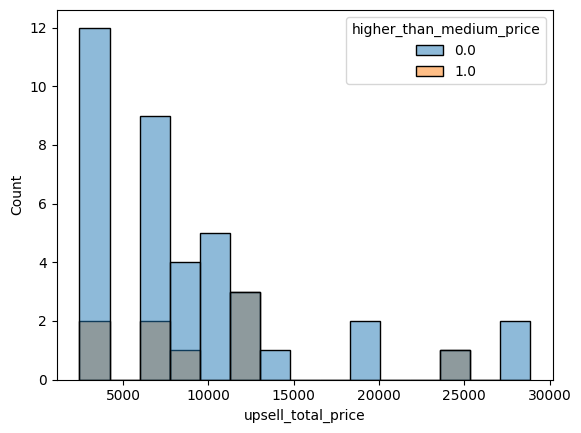

In [ ]:
sns.histplot(data=hotel2[hotel2['upsell_total_price']>0], x='upsell_total_price',hue='higher_than_medium_price', bins=15)

In [ ]:
print(hotel2[['utm_medium', 'higher_than_medium_price']].groupby(by='utm_medium').mean())
print(hotel2[['utm_source', 'higher_than_medium_price']].groupby(by='utm_source').mean())

            higher_than_medium_price
utm_medium                          
(not set)                   0.358974
cpc                         0.206897
ct                          0.000000
direct                      0.253012
email                       0.000000
offline                     0.500000
organic                     0.196078
other                            NaN
referral                    0.300000
            higher_than_medium_price
utm_source                          
bing                        0.181818
facebook                    0.400000
google                      0.203046
instagram                   1.000000
na                          0.358974
other                       0.230769


In [ ]:
hotel3[['nights', 'adults', 'children', 'if_children','children_age_mean','sel_num_of_rooms',
        'upsell_total_price','lead_time','higher_than_medium_price']].groupby(by='higher_than_medium_price').mean()

nights    adults  children  if_children  \
higher_than_medium_price                                              
0.0                       2.507513  2.220367  0.163606     0.111853   
1.0                       2.468750  2.156250  1.203125     0.687500   

                          children_age_mean  sel_num_of_rooms  \
higher_than_medium_price                                        
0.0                                5.597701          1.160267   
1.0                                9.261364          1.062500   

                          upsell_total_price  lead_time  
higher_than_medium_price                                 
0.0                              2310.477933  56.634391  
1.0                              1140.468750  53.859375

<Axes: xlabel='upsell_total_price', ylabel='Count'>

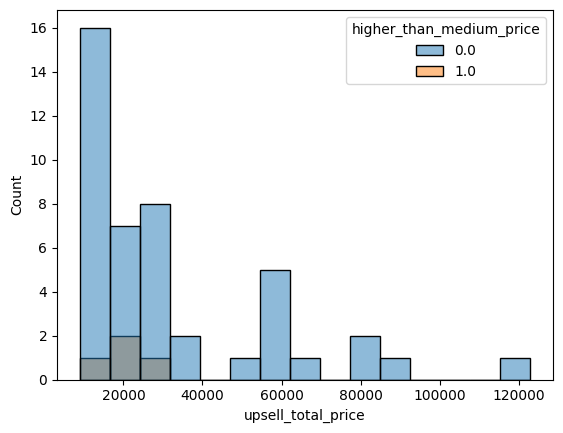

In [ ]:
sns.histplot(data=hotel3[hotel3['upsell_total_price']>0], x='upsell_total_price',hue='higher_than_medium_price', bins=15)

In [ ]:
print(hotel3[['utm_medium', 'higher_than_medium_price']].groupby(by='utm_medium').mean())
print(hotel3[['utm_source', 'higher_than_medium_price']].groupby(by='utm_source').mean())

            higher_than_medium_price
utm_medium                          
(not set)                   0.060000
cpc                         0.115789
ct                          0.000000
direct                      0.056075
email                       0.000000
offline                     0.000000
organic                     0.101852
other                            NaN
referral                    0.000000
            higher_than_medium_price
utm_source                          
bing                        0.083333
facebook                    0.142857
google                      0.113978
instagram                        NaN
na                          0.060000
other                       0.046512


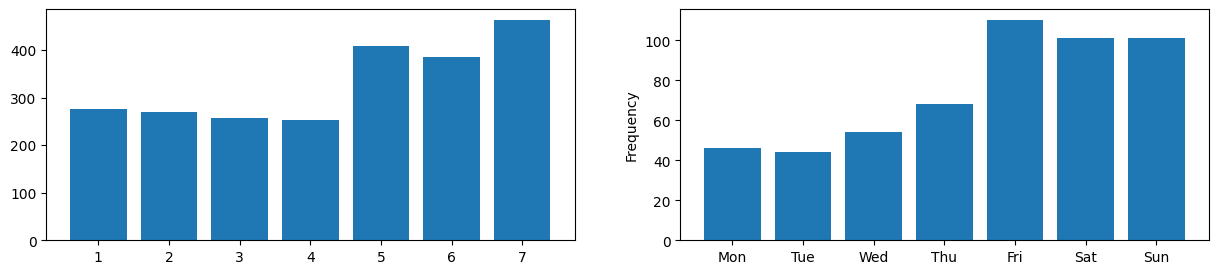

In [ ]:
# which days are less popular for each monetary group?
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,3))

ltm_h1 = Counter(day for days in hotel1[hotel1['higher_than_medium_price']==0]['days_of_week_in_stay'] for day in days)
htm_h1 = Counter(day for days in hotel1[hotel1['higher_than_medium_price']==1]['days_of_week_in_stay'] for day in days)
ax1.bar(ltm_h1.keys(), ltm_h1.values())
ax2.bar(htm_h1.keys(), htm_h1.values())
plt.xticks(range(1, 8), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.ylabel("Frequency")
plt.show()

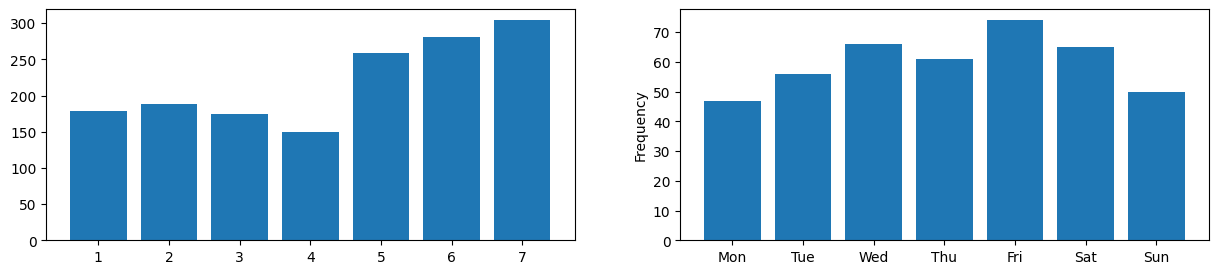

In [ ]:
# which days are less popular for each monetary group?
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,3))

ltm_h2 = Counter(day for days in hotel2[hotel2['higher_than_medium_price']==0]['days_of_week_in_stay'] for day in days)
htm_h2 = Counter(day for days in hotel2[hotel2['higher_than_medium_price']==1]['days_of_week_in_stay'] for day in days)
ax1.bar(ltm_h2.keys(), ltm_h2.values())
ax2.bar(htm_h2.keys(), htm_h2.values())
plt.xticks(range(1, 8), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.ylabel("Frequency")
plt.show()

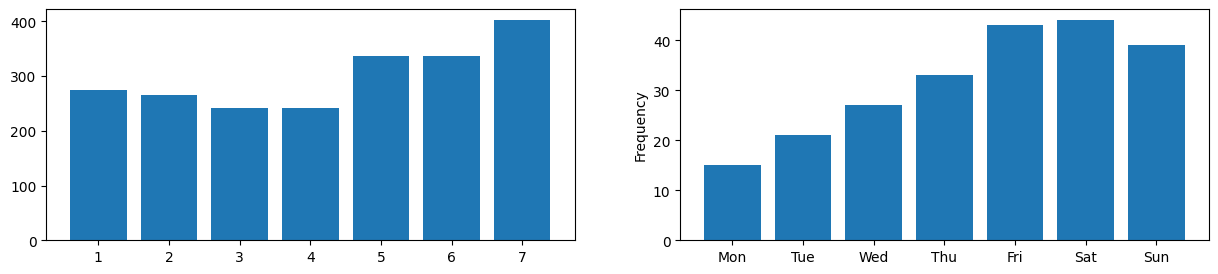

In [ ]:
# which days are less popular for each monetary group?
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,3))

ltm_h3 = Counter(day for days in hotel3[hotel3['higher_than_medium_price']==0]['days_of_week_in_stay'] for day in days)
htm_h3 = Counter(day for days in hotel3[hotel3['higher_than_medium_price']==1]['days_of_week_in_stay'] for day in days)
ax1.bar(ltm_h3.keys(), ltm_h3.values())
ax2.bar(htm_h3.keys(), htm_h3.values())
plt.xticks(range(1, 8), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.ylabel("Frequency")
plt.show()

In [ ]:
# mi az oka, hogy egy időszakot nagyon keresnek, de aztán nem foglalnak?

In [ ]:
hotel1[['session_id','uuid']].groupby(by='session_id').count().sort_values(by='uuid', ascending=False).value_counts()#.plot(kind='hist', bins=30)

uuid
1       7476
2       2187
3        896
4        448
5        219
6        142
7         70
8         56
9         29
11        22
10        20
13        10
12         8
17         7
14         6
15         4
18         4
19         4
16         3
20         2
21         1
22         1
24         1
26         1
35         1
Name: count, dtype: int64

In [ ]:
hotel2[['session_id','uuid']].groupby(by='session_id').count().sort_values(by='uuid', ascending=False).value_counts()#.plot(kind='hist', bins=30)

uuid
1       5983
2       1741
3        701
4        289
5        154
6         91
7         59
8         35
9         19
10        16
11        13
12         7
13         7
16         4
15         3
18         2
14         1
17         1
19         1
28         1
Name: count, dtype: int64

In [ ]:
hotel3[['session_id','uuid']].groupby(by='session_id').count().sort_values(by='uuid', ascending=False).value_counts()#.plot(kind='hist', bins=30)

uuid
1       8569
2       2355
3        889
4        422
5        198
6        114
7         61
8         57
9         30
10        21
11        19
12        10
13         6
15         5
16         4
17         3
20         3
22         3
14         1
18         1
24         1
32         1
Name: count, dtype: int64

In [ ]:
df.columns

Index(['search_log_session_id', 'search_log_id', 'session_id',
       'search_log_room_id', 'uuid', 'utc_datetime', 'utm_source',
       'utm_medium', 'utm_campaign', 'lang_code', 'currency', 'arrival',
       'departure', 'nights', 'adults', 'children', 'if_children',
       'children_age_mean', 'conversion', 'sel_num_of_rooms',
       'mean_room_price', 'total_price_p_night', 'picked_room', 'baby_bed',
       'pieces', 'sum_price', 'total_price_final', 'rooms_total_price',
       'upsell_total_price', 'vouchers_total_price', 'loyalty_discount_total',
       'redeemed_loyalty_points_total', 'hotel_id', 'rfm_monetary_score',
       'rfm_duration_score', '0_age', '1_age', '2_age', '3_age', '4_age',
       'ROOMAA_room_price_min', 'offered_price_median', 'offered_price_min',
       'offered_price_max', 'ROOMAA_room_price_max', 'ROOMBB_room_price_min',
       'ROOMBB_room_price_max', 'ROOMCC_room_price_min',
       'ROOMCC_room_price_max', 'ROOMDD_room_price_min',
       'ROOMDD_room_pric

# for k-means clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [ ]:
df_unique.columns

Index(['search_log_session_id', 'search_log_id', 'session_id',
       'search_log_room_id', 'uuid', 'utc_datetime', 'utm_source',
       'utm_medium', 'utm_campaign', 'lang_code', 'currency', 'arrival',
       'departure', 'nights', 'adults', 'children', 'if_children',
       'children_age_mean', 'conversion', 'sel_num_of_rooms',
       'mean_room_price', 'total_price_p_night', 'picked_room', 'baby_bed',
       'pieces', 'sum_price', 'total_price_final', 'rooms_total_price',
       'upsell_total_price', 'vouchers_total_price', 'loyalty_discount_total',
       'redeemed_loyalty_points_total', 'hotel_id', 'rfm_monetary_score',
       'rfm_duration_score', '0_age', '1_age', '2_age', '3_age', '4_age',
       'ROOMAA_room_price_min', 'offered_price_median', 'offered_price_min',
       'offered_price_max', 'ROOMAA_room_price_max', 'ROOMBB_room_price_min',
       'ROOMBB_room_price_max', 'ROOMCC_room_price_min',
       'ROOMCC_room_price_max', 'ROOMDD_room_price_min',
       'ROOMDD_room_pric

In [ ]:
X = df_unique[['sel_num_of_rooms','if_children','nights','adults','children','children_age_mean','conversion','total_price_p_night','upsell_total_price','lead_time']].fillna(value=0)

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# preprocessing: one hot encoding currency, pca?

In [ ]:
km_inertias, km_scores = [], []

for k in range(2, 8):
    km = KMeans(n_clusters=k).fit(X_scaled)
    km_inertias.append(km.inertia_)
    km_scores.append(silhouette_score(X_scaled, km.labels_))

KeyboardInterrupt: 

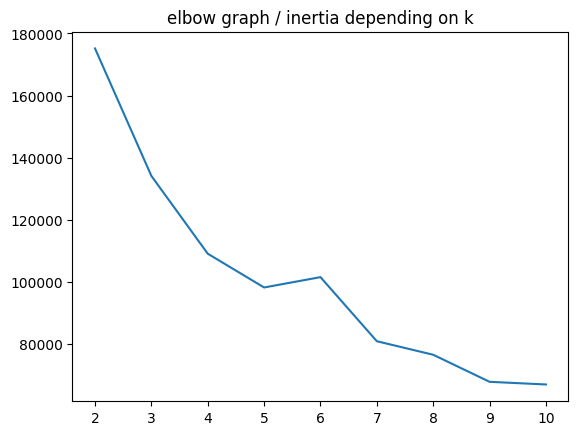

In [ ]:
sns.lineplot(x=range(2, 8), y=km_inertias)
plt.title('elbow graph / inertia depending on k')
plt.show()

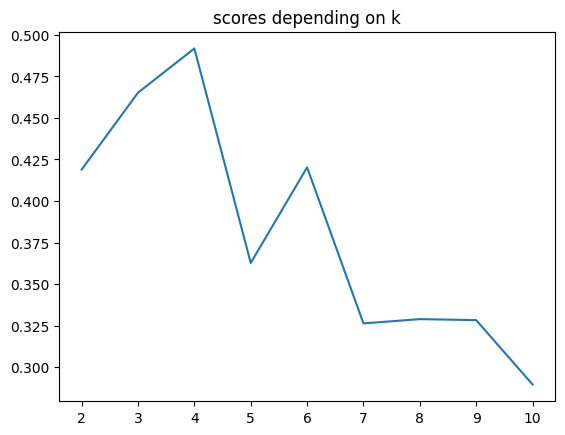

In [ ]:
sns.lineplot(x=range(2, 8), y=km_scores)
plt.title('scores depending on k')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)  # Adjust n_clusters based on your analysis
df_unique['cluster'] = kmeans.fit_predict(X_scaled)

In [ ]:
km = KMeans(n_clusters=4).fit(X_scaled)

In [ ]:
print("silhouette_score is :",silhouette_score(X_scaled, kmeans.labels_, metric='euclidean'))

silhouette_score is : 0.4918115866952646


In [ ]:
X.columns

Index(['sel_num_of_rooms', 'if_children', 'nights', 'adults', 'children',
       'children_age_mean', 'conversion', 'total_price_p_night',
       'upsell_total_price', 'lead_time'],
      dtype='object')

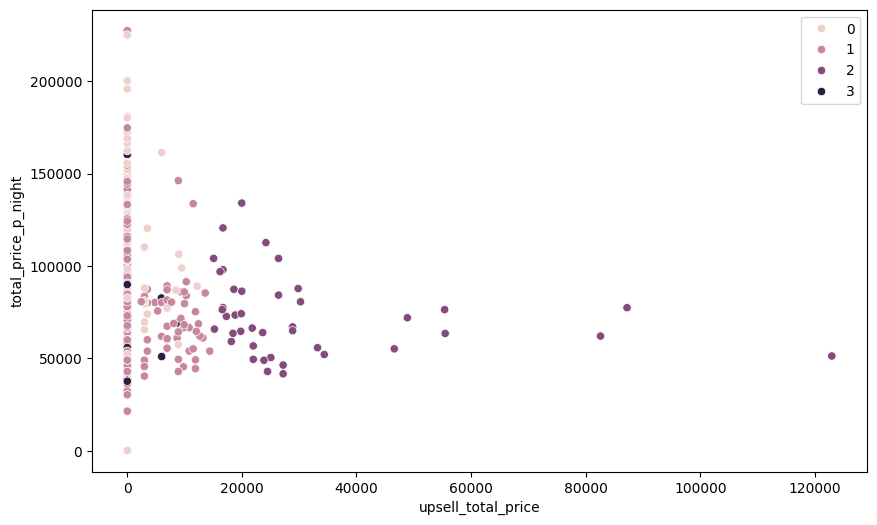

In [ ]:
# K-Means visualization on pair of 2 features
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X.iloc[:, 8], y=X.iloc[:, 7], hue=km.labels_)
plt.show()

In [ ]:
cluster_analysis = df_unique.groupby('cluster')[['sel_num_of_rooms','if_children','nights','adults','children','children_age_mean','conversion','total_price_p_night','upsell_total_price','lead_time']].mean()
cluster_analysis

sel_num_of_rooms  if_children    nights    adults  children  \
cluster                                                                
0                1.056518     1.000000  2.508296  2.003855  1.575499   
1                2.270638     0.388085  2.481702  4.291064  0.767660   
2                1.092939     0.250000  2.522334  2.144092  0.389049   
3                1.002926     0.000000  2.401102  2.012315  0.000000   

         children_age_mean  conversion  total_price_p_night  \
cluster                                                       
0                 7.920679    0.000000                  NaN   
1                 7.671528    0.039149         62408.192705   
2                 7.878205    1.000000         73615.192391   
3                      NaN    0.000000                  NaN   

         upsell_total_price  lead_time  
cluster                                 
0                       NaN  46.397520  
1                733.695652  55.834043  
2               1286.661562  52.997839  
3                       NaN  41.584745

In [ ]:
df_unique['cluster'].value_counts()

cluster
3    14697
0     5967
2     1388
1     1175
Name: count, dtype: int64

In [ ]:
df_unique.columns

Index(['search_log_session_id', 'search_log_id', 'session_id',
       'search_log_room_id', 'uuid', 'utc_datetime', 'utm_source',
       'utm_medium', 'utm_campaign', 'lang_code', 'currency', 'arrival',
       'departure', 'nights', 'adults', 'children', 'if_children',
       'children_age_mean', 'conversion', 'sel_num_of_rooms',
       'mean_room_price', 'total_price_p_night', 'picked_room', 'baby_bed',
       'pieces', 'sum_price', 'total_price_final', 'rooms_total_price',
       'upsell_total_price', 'vouchers_total_price', 'loyalty_discount_total',
       'redeemed_loyalty_points_total', 'hotel_id', 'rfm_monetary_score',
       'rfm_duration_score', '0_age', '1_age', '2_age', '3_age', '4_age',
       'ROOMAA_room_price_min', 'offered_price_median', 'offered_price_min',
       'offered_price_max', 'ROOMAA_room_price_max', 'ROOMBB_room_price_min',
       'ROOMBB_room_price_max', 'ROOMCC_room_price_min',
       'ROOMCC_room_price_max', 'ROOMDD_room_price_min',
       'ROOMDD_room_pric

In [ ]:
for k in range(4):
    print(f'cluster nb : {k}')
    print(df_unique[df_unique['cluster'] == k][['nights','adults','children','if_children','children_age_mean','conversion','sel_num_of_rooms','total_price_p_night','upsell_total_price','offered_price_median']].describe())#.iloc[[0, 1, 3, 7], :-1])
    print('\n\n')

cluster nb : 0
            nights       adults     children  if_children  children_age_mean  \
count  5967.000000  5967.000000  5967.000000       5967.0        5919.000000   
mean      2.508296     2.003855     1.575499          1.0           7.920679   
std       1.000447     0.403411     0.657066          0.0           4.406163   
min       0.000000     1.000000     1.000000          1.0           0.000000   
25%       2.000000     2.000000     1.000000          1.0           4.000000   
50%       2.000000     2.000000     1.000000          1.0           8.000000   
75%       3.000000     2.000000     2.000000          1.0          11.000000   
max       9.000000     6.000000     6.000000          1.0          17.000000   

       conversion  sel_num_of_rooms  total_price_p_night  upsell_total_price  \
count      5967.0       5945.000000                  0.0                 0.0   
mean          0.0          1.056518                  NaN                 NaN   
std           0.0       

In [ ]:
df_unique[df_unique['cluster'] == 2][['nights','adults','children','if_children','children_age_mean','conversion','sel_num_of_rooms','total_price_p_night','upsell_total_price','offered_price_median']].describe()

nights       adults     children  if_children  children_age_mean  \
count  1388.000000  1388.000000  1388.000000  1388.000000         338.000000   
mean      2.522334     2.144092     0.389049     0.250000           7.878205   
std       0.999750     0.626949     0.747943     0.433169           4.838391   
min       1.000000     1.000000     0.000000     0.000000           0.000000   
25%       2.000000     2.000000     0.000000     0.000000           4.000000   
50%       2.000000     2.000000     0.000000     0.000000           7.500000   
75%       3.000000     2.000000     0.250000     0.250000          12.000000   
max       7.000000     5.000000     4.000000     1.000000          17.000000   

       conversion  sel_num_of_rooms  total_price_p_night  upsell_total_price  \
count      1388.0       1388.000000          1388.000000         1388.000000   
mean          1.0          1.092939         73615.192391         1286.661562   
std           0.0          0.292924         28507.724564         6619.152331   
min           1.0          1.000000         21345.000000            0.000000   
25%           1.0          1.000000         52644.725000            0.000000   
50%           1.0          1.000000         67239.445000            0.000000   
75%           1.0          1.000000         87852.352119            0.000000   
max           1.0          3.000000        227410.160000       122960.175800   

       offered_price_median  
count           1388.000000  
mean           86848.255681  
std            30737.892351  
min            10672.500000  
25%            68844.375000  
50%            84463.638340  
75%           102380.570283  
max           237099.000000